# Preprocessing

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import librosa as lr

In [31]:
data_folder = "/Users/harsh/Downloads/Audio_1/LibriSpeech/"

In [33]:
x=np.array((),dtype='int32')
y=np.array((),dtype='int32')
file = open(data_folder+'SPEAKERS.txt','r')
for i in range(12):
    file.readline()
line = file.readline().split('|')
Dict = {'F':0,'M':1}
while (len(line)>1):
    package = line[2].strip()
    if(package=='dev-clean'):
        y = np.append(y,Dict.get(line[1].strip()))
        x = np.append(x,int(line[0].strip()))
    line = file.readline().split('|')
file.close() 
data = {}
for i in range(len(x)):
    data[int(x[i])] = np.array(())

In [63]:
#y,x

(array([0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
        0., 0., 0., 0., 1., 0.]),
 array([  84.,  174.,  251.,  422.,  652.,  777., 1272., 1462., 1673.,
        1919., 1988., 1993., 2035., 2078., 2086., 2277., 2412., 2428.,
        2803., 2902., 3000., 3081., 3170., 3536., 3576., 3752., 3853.,
        5338., 5536., 5694., 5895., 6241., 6295., 6313., 6319., 6345.,
        7850., 7976., 8297., 8842.]))

In [34]:
dict_y = dict(zip(x,y))

In [131]:
dict_y

{84: 0,
 174: 1,
 251: 1,
 422: 1,
 652: 1,
 777: 1,
 1272: 1,
 1462: 0,
 1673: 0,
 1919: 0,
 1988: 0,
 1993: 0,
 2035: 0,
 2078: 0,
 2086: 1,
 2277: 0,
 2412: 0,
 2428: 1,
 2803: 1,
 2902: 1,
 3000: 1,
 3081: 0,
 3170: 1,
 3536: 0,
 3576: 0,
 3752: 1,
 3853: 0,
 5338: 0,
 5536: 1,
 5694: 1,
 5895: 0,
 6241: 1,
 6295: 1,
 6313: 0,
 6319: 0,
 6345: 0,
 7850: 0,
 7976: 0,
 8297: 1,
 8842: 0}

In [6]:
#from progress.bar import Bar

In [7]:
t_j = 0
j = 0
for subdirs,dirs,files in os.walk(data_folder+'dev-clean'):
    t_j+=1
for subdirs,dirs,files in os.walk(data_folder+'dev-clean'):
    for file in files:
        if file.endswith('.flac'):
            audio,sf = lr.load(subdirs+'/'+file)
            data[int(subdirs.split('/')[-2])] = np.append(data[int(subdirs.split('/')[-2])],audio)    
    j+=1
    print(float(j)/t_j*100)
            


0.37453183520599254
0.7490636704119851
1.1235955056179776
1.4981273408239701
1.8726591760299627
2.247191011235955
2.6217228464419478
2.9962546816479403
3.3707865168539324
3.7453183520599254
4.119850187265917
4.49438202247191
4.868913857677903
5.2434456928838955
5.617977528089887
5.992509363295881
6.367041198501873
6.741573033707865
7.116104868913857
7.490636704119851
7.865168539325842
8.239700374531834
8.614232209737828
8.98876404494382
9.363295880149813
9.737827715355806
10.112359550561797
10.486891385767791
10.861423220973784
11.235955056179774
11.610486891385769
11.985018726591761
12.359550561797752
12.734082397003746
13.108614232209737
13.48314606741573
13.857677902621724
14.232209737827715
14.606741573033707
14.981273408239701
15.355805243445692
15.730337078651685
16.10486891385768
16.479400749063668
16.853932584269664
17.228464419475657
17.60299625468165
17.97752808988764
18.352059925093634
18.726591760299627
19.101123595505616
19.475655430711612
19.850187265917604
20.22471910112

In [8]:
#plt.plot(np.arange(0,len(data[x[1]]))/sf,data[x[1]])

In [66]:
seg = 550      #0.025*sf
log_en = np.zeros((100,26))
for i in range(len(x)):
    l = 0
    ctr = 0
    while(l<len(data.get(x[i]))):
        pow_spec = (np.abs(np.fft.fftshift(np.fft.fft(data.get(x[i])[l:l+seg],512))[:257])**2)/seg
        mfb = lr.filters.mel(sr=22050,n_fft=512,n_mels=26)
        energy = np.matmul(mfb,pow_spec)
        energy = np.where(energy == 0, np.finfo(float).eps, energy)
        log_en[ctr%100] = 20*np.log10(energy)
        if(ctr%100==99):
            fig = plt.figure(ctr,frameon=False)
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            ax.imshow(log_en,aspect='auto')
            fig.savefig(data_folder+'dev-clean/Spectrograms/'+str(int(x[i]))+'_png/'+str(ctr//100)+'.png')
            plt.close()
        ctr += 1
        l += 220
        #print(float(l+1)/len(data.get(x[i]))*100)
    print(float(i+1)/len(x)*100)

17.5


# CNN

In [17]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

## DataGenerator

In [67]:
im_size = 256
train_gen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
train_set = train_gen.flow_from_directory(data_folder+'dev-clean/Spectrograms/',subset='training',target_size=(im_size,im_size),color_mode='rgb',class_mode='categorical',batch_size=50)
test_set = train_gen.flow_from_directory(data_folder+'dev-clean/Spectrograms/',subset='validation',target_size=(im_size,im_size),color_mode='rgb',class_mode='categorical',batch_size=50)


Found 17493 images belonging to 40 classes.
Found 1928 images belonging to 40 classes.


## Feature Layers

In [14]:
im_size = 256
inpt = Input((im_size,im_size,3))

In [15]:
c1 = Conv2D(8,(3,3),activation='relu',padding='same')(inpt)
#c12 = Conv2D(8,(3,3),activation='relu',padding='same')(c1)
m1 = MaxPooling2D((2,2))(c1)
c2 = Conv2D(16,(3,3),activation='relu',padding='same')(m1)
#c22 = Conv2D(16,(3,3),activation='relu',padding='same')(c2)
m2 = MaxPooling2D((2,2))(c2)
#c3 = Conv2D(32,(3,3),activation='relu',padding='same')(m2)
#c32 = Conv2D(32,(3,3),activation='relu',padding='same')(c3)
#m3 = MaxPooling2D((2,2))(c3)

In [16]:
f = Flatten()(m2)

## Classifier Layers

In [17]:
#d1 = Dense(64,activation='relu')(f)
#drp1 = Dropout(0.2)(d1)
#d2 = Dense(64,activation='relu')(d1)
#drp2 = Dropout(0.5)(d2)
outpt = Dense(40,activation='softmax')(f)

In [18]:
model = Model(inpt,outpt)

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 40)                2621480   
Total para

In [19]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

In [75]:
model.fit_generator(train_set,steps_per_epoch=220,epochs=10,validation_data=test_set,validation_steps=22)

Epoch 1/10
220/220 [==============================] - 344s 2s/step - loss: 3.4582 - acc: 0.1403 - val_loss: 2.9661 - val_acc: 0.2000
Epoch 2/10
220/220 [==============================] - 306s 1s/step - loss: 2.6626 - acc: 0.2714 - val_loss: 2.6078 - val_acc: 0.2987
Epoch 3/10
220/220 [==============================] - 278s 1s/step - loss: 2.2486 - acc: 0.3803 - val_loss: 2.2295 - val_acc: 0.3755
Epoch 4/10
220/220 [==============================] - 275s 1s/step - loss: 1.8100 - acc: 0.4943 - val_loss: 2.0556 - val_acc: 0.4193
Epoch 5/10
220/220 [==============================] - 277s 1s/step - loss: 1.5486 - acc: 0.5595 - val_loss: 1.8595 - val_acc: 0.4718
Epoch 6/10
220/220 [==============================] - 289s 1s/step - loss: 1.2897 - acc: 0.6248 - val_loss: 1.7136 - val_acc: 0.5232
Epoch 7/10
220/220 [==============================] - 325s 1s/step - loss: 1.0920 - acc: 0.6834 - val_loss: 1.6095 - val_acc: 0.5418
Epoch 8/10
220/220 [==============================] - 303s 1s/step - 

In [76]:
model.save_weights('audio_cnn2.h5')

In [77]:
test_audio,sf = lr.load('/Users/harsh/Downloads/Audio_1/sample_debate.mp3')

In [78]:
seg = 550      #0.025*sf
log_en = np.zeros((100,26))
l = 0
ctr = 0
while(l<len(test_audio)):
    pow_spec = (np.abs(np.fft.fftshift(np.fft.fft(test_audio[l:l+seg],512))[:257])**2)/seg
    mfb = lr.filters.mel(sr=22050,n_fft=512,n_mels=26)
    energy = np.matmul(mfb,pow_spec)
    energy = np.where(energy == 0, np.finfo(float).eps, energy)
    log_en[ctr%100] = 20*np.log10(energy)
    if(ctr%100==99):
        fig = plt.figure(ctr,frameon=False)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        ax.imshow(log_en,aspect='auto')
        fig.savefig('/Users/harsh/Downloads/Audio_1/sample_debate_png/'+str(ctr//100)+'.png')
        plt.close()
    #print(float(l+1)/len(test_audio)*100)
    ctr += 1
    l += 220

2.6076739881807697e-06
0.0005762959513879501
0.0011499842287877194
0.001723672506187489
0.002297360783587258
0.0028710490609870276
0.003444737338386797
0.004018425615786567
0.004592113893186336
0.005165802170586105
0.005739490447985875
0.006313178725385644
0.006886867002785413
0.007460555280185183
0.008034243557584952
0.008607931834984721
0.00918162011238449
0.009755308389784261
0.010328996667184029
0.010902684944583798
0.011476373221983568
0.012050061499383338
0.012623749776783107
0.013197438054182878
0.013771126331582645
0.014344814608982414
0.014918502886382185
0.015492191163781954
0.01606587944118172
0.01663956771858149
0.017213255995981263
0.017786944273381032
0.018360632550780798
0.01893432082818057
0.01950800910558034
0.02008169738298011
0.020655385660379878
0.021229073937779647
0.021802762215179416
0.022376450492579185
0.022950138769978954
0.023523827047378723
0.024097515324778496
0.02467120360217826
0.025244891879578034
0.025818580156977803
0.02639226843437757
0.02696595671177

0.2598833973360837
0.26045708561348346
0.2610307738908832
0.261604462168283
0.26217815044568277
0.26275183872308255
0.26332552700048234
0.2638992152778821
0.26447290355528186
0.26504659183268164
0.26562028011008143
0.26619396838748116
0.26676765666488095
0.2673413449422807
0.26791503321968047
0.26848872149708025
0.26906240977448
0.26963609805187977
0.27020978632927956
0.2707834746066793
0.2713571628840791
0.27193085116147886
0.2725045394388786
0.2730782277162784
0.27365191599367816
0.2742256042710779
0.27479929254847774
0.27537298082587747
0.27594666910327725
0.27652035738067704
0.27709404565807677
0.27766773393547656
0.27824142221287634
0.2788151104902761
0.27938879876767586
0.27996248704507565
0.2805361753224754
0.28110986359987516
0.28168355187727495
0.2822572401546747
0.28283092843207447
0.28340461670947426
0.283978304986874
0.2845519932642738
0.28512568154167356
0.2856993698190733
0.2862730580964731
0.28684674637387286
0.28742043465127265
0.28799412292867244
0.28856781120607217
0.

0.5593486781387633
0.5599223664161631
0.5604960546935629
0.5610697429709626
0.5616434312483624
0.5622171195257621
0.5627908078031619
0.5633644960805617
0.5639381843579615
0.5645118726353612
0.565085560912761
0.5656592491901608
0.5662329374675605
0.5668066257449602
0.5673803140223601
0.5679540022997598
0.5685276905771596
0.5691013788545595
0.5696750671319591
0.5702487554093589
0.5708224436867587
0.5713961319641585
0.5719698202415582
0.5725435085189581
0.5731171967963578
0.5736908850737575
0.5742645733511573
0.5748382616285571
0.5754119499059568
0.5759856381833567
0.5765593264607564
0.5771330147381561
0.5777067030155559
0.5782803912929557
0.5788540795703554
0.5794277678477553
0.580001456125155
0.5805751444025548
0.5811488326799545
0.5817225209573543
0.5822962092347541
0.5828698975121538
0.5834435857895537
0.5840172740669534
0.5845909623443531
0.5851646506217529
0.5857383388991527
0.5863120271765524
0.5868857154539523
0.587459403731352
0.5880330920087518
0.5886067802861515
0.5891804685635

0.8599613354962424
0.8605350237736422
0.8611087120510419
0.8616824003284418
0.8622560886058416
0.8628297768832413
0.863403465160641
0.8639771534380409
0.8645508417154406
0.8651245299928403
0.8656982182702401
0.86627190654764
0.8668455948250396
0.8674192831024394
0.8679929713798391
0.868566659657239
0.8691403479346388
0.8697140362120385
0.8702877244894384
0.8708614127668381
0.8714351010442378
0.8720087893216375
0.8725824775990374
0.8731561658764372
0.8737298541538369
0.8743035424312366
0.8748772307086365
0.8754509189860362
0.876024607263436
0.8765982955408357
0.8771719838182356
0.8777456720956354
0.878319360373035
0.8788930486504347
0.8794667369278346
0.8800404252052344
0.8806141134826341
0.8811878017600339
0.8817614900374338
0.8823351783148334
0.8829088665922332
0.8834825548696331
0.8840562431470328
0.8846299314244325
0.8852036197018323
0.8857773079792322
0.8863509962566318
0.8869246845340316
0.8874983728114313
0.8880720610888312
0.888645749366231
0.8892194376436307
0.8897931259210303


1.1663108756277192
1.166884563905119
1.1674582521825188
1.1680319404599186
1.1686056287373183
1.1691793170147182
1.169753005292118
1.1703266935695176
1.1709003818469175
1.1714740701243171
1.172047758401717
1.1726214466791167
1.1731951349565166
1.1737688232339163
1.174342511511316
1.1749161997887159
1.1754898880661158
1.1760635763435154
1.1766372646209151
1.1772109528983148
1.1777846411757147
1.1783583294531144
1.1789320177305143
1.179505706007914
1.1800793942853138
1.1806530825627135
1.1812267708401132
1.1818004591175129
1.182374147394913
1.1829478356723127
1.1835215239497123
1.1840952122271122
1.184668900504512
1.1852425887819116
1.1858162770593115
1.1863899653367114
1.186963653614111
1.1875373418915107
1.1881110301689104
1.1886847184463103
1.18925840672371
1.1898320950011099
1.1904057832785095
1.1909794715559094
1.1915531598333091
1.1921268481107088
1.1927005363881087
1.1932742246655086
1.1938479129429083
1.194421601220308
1.1949952894977078
1.1955689777751075
1.1961426660525072
1.19

1.4514339494954045
1.4520076377728044
1.4525813260502043
1.453155014327604
1.4537287026050036
1.4543023908824035
1.4548760791598032
1.455449767437203
1.4560234557146028
1.4565971439920027
1.4571708322694024
1.457744520546802
1.458318208824202
1.4588918971016016
1.4594655853790015
1.4600392736564012
1.460612961933801
1.4611866502112008
1.4617603384886004
1.462334026766
1.4629077150434
1.4634814033208
1.4640550915981996
1.4646287798755993
1.4652024681529991
1.4657761564303988
1.4663498447077987
1.4669235329851984
1.4674972212625983
1.468070909539998
1.4686445978173976
1.4692182860947973
1.4697919743721972
1.4703656626495971
1.4709393509269968
1.4715130392043967
1.4720867274817964
1.472660415759196
1.473234104036596
1.4738077923139958
1.4743814805913955
1.4749551688687952
1.4755288571461949
1.4761025454235948
1.4766762337009944
1.4772499219783943
1.477823610255794
1.478397298533194
1.4789709868105936
1.4795446750879933
1.480118363365393
1.480692051642793
1.4812657399201927
1.4818394281975

1.7445886592466868
1.7451623475240867
1.7457360358014862
1.746309724078886
1.746883412356286
1.7474571006336856
1.7480307889110855
1.748604477188485
1.749178165465885
1.7497518537432848
1.7503255420206845
1.7508992302980844
1.7514729185754843
1.7520466068528837
1.7526202951302836
1.7531939834076833
1.753767671685083
1.754341359962483
1.7549150482398825
1.7554887365172824
1.7560624247946823
1.7566361130720818
1.7572098013494817
1.7577834896268816
1.7583571779042813
1.7589308661816812
1.7595045544590806
1.7600782427364805
1.7606519310138804
1.76122561929128
1.76179930756868
1.7623729958460799
1.7629466841234793
1.7635203724008792
1.764094060678279
1.7646677489556788
1.7652414372330787
1.7658151255104781
1.766388813787878
1.766962502065278
1.7675361903426774
1.7681098786200773
1.768683566897477
1.7692572551748769
1.7698309434522768
1.7704046317296762
1.7709783200070761
1.771552008284476
1.7721256965618757
1.7726993848392756
1.7732730731166755
1.773846761394075
1.7744204496714748
1.7749941

2.046922381436365
2.047496069713765
2.048069757991165
2.0486434462685645
2.049217134545964
2.0497908228233643
2.050364511100764
2.0509381993781637
2.0515118876555634
2.052085575932963
2.052659264210363
2.0532329524877624
2.0538066407651625
2.054380329042562
2.054954017319962
2.055527705597362
2.056101393874761
2.0566750821521613
2.057248770429561
2.0578224587069607
2.058396146984361
2.0589698352617605
2.05954352353916
2.06011721181656
2.06069090009396
2.0612645883713596
2.0618382766487593
2.062411964926159
2.0629856532035586
2.0635593414809588
2.0641330297583584
2.064706718035758
2.065280406313158
2.0658540945905575
2.0664277828679576
2.067001471145357
2.067575159422757
2.0681488477001566
2.0687225359775563
2.0692962242549564
2.069869912532356
2.0704436008097558
2.0710172890871554
2.0715909773645556
2.0721646656419552
2.072738353919355
2.0733120421967546
2.0738857304741543
2.0744594187515544
2.075033107028954
2.0756067953063537
2.076180483583754
2.076754171861153
2.077327860138553
2.07

2.33376652013625
2.3343402084136495
2.3349138966910497
2.3354875849684493
2.336061273245849
2.3366349615232487
2.337208649800649
2.337782338078048
2.338356026355448
2.338929714632848
2.3395034029102475
2.3400770911876476
2.340650779465047
2.341224467742447
2.3417981560198466
2.3423718442972463
2.3429455325746464
2.3435192208520457
2.344092909129446
2.3446665974068455
2.345240285684245
2.3458139739616453
2.346387662239045
2.3469613505164446
2.3475350387938443
2.3481087270712444
2.348682415348644
2.3492561036260438
2.3498297919034434
2.350403480180843
2.3509771684582432
2.3515508567356425
2.3521245450130426
2.3526982332904423
2.353271921567842
2.353845609845242
2.3544192981226413
2.3549929864000414
2.355566674677441
2.3561403629548408
2.356714051232241
2.3572877395096405
2.35786142778704
2.35843511606444
2.35900880434184
2.3595824926192397
2.3601561808966394
2.360729869174039
2.3613035574514387
2.361877245728839
2.3624509340062385
2.363024622283638
2.363598310561038
2.3641719988384375
2.

2.6383949954355277
2.638968683712927
2.639542371990327
2.6401160602677267
2.6406897485451264
2.6412634368225265
2.6418371250999257
2.642410813377326
2.6429845016547255
2.643558189932125
2.6441318782095253
2.644705566486925
2.6452792547643247
2.6458529430417244
2.6464266313191245
2.647000319596524
2.647574007873924
2.6481476961513235
2.648721384428723
2.6492950727061233
2.6498687609835225
2.6504424492609227
2.6510161375383223
2.651589825815722
2.652163514093122
2.6527372023705214
2.6533108906479215
2.653884578925321
2.654458267202721
2.655031955480121
2.6556056437575206
2.6561793320349203
2.65675302031232
2.6573267085897196
2.6579003968671198
2.6584740851445194
2.659047773421919
2.659621461699319
2.660195149976719
2.6607688382541186
2.6613425265315183
2.661916214808918
2.6624899030863176
2.6630635913637177
2.663637279641117
2.664210967918517
2.6647846561959168
2.6653583444733164
2.6659320327507166
2.6665057210281162
2.667079409305516
2.6676530975829156
2.6682267858603153
2.6688004741377

2.9476129769540034
2.9481866652314026
2.9487603535088027
2.9493340417862024
2.949907730063602
2.950481418341002
2.9510551066184014
2.9516287948958015
2.952202483173201
2.952776171450601
2.953349859728001
2.9539235480054007
2.9544972362828004
2.9550709245602
2.9556446128375997
2.956218301115
2.9567919893923995
2.957365677669799
2.957939365947199
2.958513054224599
2.9590867425019987
2.9596604307793983
2.960234119056798
2.9608078073341977
2.961381495611598
2.961955183888997
2.962528872166397
2.963102560443797
2.9636762487211965
2.9642499369985966
2.9648236252759963
2.965397313553396
2.9659710018307957
2.9665446901081953
2.9671183783855954
2.967692066662995
2.968265754940395
2.9688394432177945
2.9694131314951946
2.9699868197725943
2.970560508049994
2.9711341963273936
2.9717078846047933
2.9722815728821934
2.9728552611595926
2.9734289494369928
2.9740026377143924
2.974576325991792
2.9751500142691922
2.975723702546592
2.9762973908239916
2.9768710791013913
2.977444767378791
2.978018455656191
2.

3.22872023287989
3.2292939211572897
3.22986760943469
3.2304412977120895
3.2310149859894897
3.231588674266889
3.2321623625442886
3.2327360508216882
3.2333097390990884
3.2338834273764885
3.2344571156538873
3.2350308039312874
3.235604492208687
3.236178180486087
3.236751868763487
3.237325557040887
3.237899245318286
3.238472933595686
3.239046621873086
3.2396203101504857
3.240193998427886
3.240767686705285
3.2413413749826847
3.241915063260085
3.2424887515374845
3.2430624398148846
3.2436361280922843
3.2442098163696835
3.2447835046470836
3.2453571929244833
3.2459308812018834
3.246504569479283
3.2470782577566824
3.2476519460340825
3.248225634311482
3.2487993225888823
3.249373010866282
3.249946699143682
3.2505203874210813
3.251094075698481
3.251667763975881
3.2522414522532808
3.252815140530681
3.25338882880808
3.25396251708548
3.25453620536288
3.2551098936402796
3.2556835819176797
3.2562572701950785
3.2568309584724786
3.2574046467498787
3.2579783350272784
3.258552023304678
3.259125711582078
3.25

3.5213012543537725
3.521874942631172
3.5224486309085723
3.523022319185972
3.523596007463371
3.5241696957407713
3.524743384018171
3.525317072295571
3.525890760572971
3.526464448850371
3.52703813712777
3.52761182540517
3.52818551368257
3.5287592019599696
3.5293328902373697
3.529906578514769
3.5304802667921686
3.5310539550695683
3.5316276433469684
3.5322013316243686
3.5327750199017673
3.5333487081791675
3.533922396456567
3.5344960847339673
3.535069773011367
3.535643461288767
3.5362171495661663
3.536790837843566
3.537364526120966
3.5379382143983658
3.538511902675766
3.539085590953165
3.539659279230565
3.540232967507965
3.5408066557853646
3.5413803440627647
3.5419540323401644
3.5425277206175636
3.5431014088949637
3.5436750971723634
3.5442487854497635
3.544822473727163
3.5453961620045624
3.5459698502819625
3.546543538559362
3.5471172268367623
3.547690915114162
3.548264603391562
3.5488382916689614
3.549411979946361
3.549985668223761
3.550559356501161
3.551133044778561
3.55170673305596
3.55228

3.80011375717006
3.80068744544746
3.80126113372486
3.80183482200226
3.8024085102796596
3.8029821985570598
3.8035558868344586
3.8041295751118587
3.804703263389259
3.8052769516666585
3.805850639944058
3.8064243282214574
3.8069980164988575
3.807571704776257
3.8081453930536573
3.808719081331057
3.809292769608456
3.8098664578858563
3.810440146163256
3.811013834440656
3.811587522718056
3.812161210995456
3.812734899272855
3.813308587550255
3.813882275827655
3.8144559641050546
3.8150296523824547
3.815603340659854
3.8161770289372536
3.8167507172146538
3.8173244054920534
3.8178980937694535
3.8184717820468532
3.8190454703242525
3.8196191586016526
3.8201928468790523
3.8207665351564524
3.821340223433852
3.8219139117112513
3.8224875999886514
3.823061288266051
3.823634976543451
3.824208664820851
3.824782353098251
3.82535604137565
3.82592972965305
3.82650341793045
3.8270771062078497
3.82765079448525
3.828224482762649
3.8287981710400487
3.8293718593174484
3.8299455475948485
3.8305192358722486
3.8310929

4.072615688934951
4.073189377212351
4.07376306548975
4.07433675376715
4.07491044204455
4.07548413032195
4.07605781859935
4.076631506876749
4.077205195154149
4.077778883431549
4.078352571708948
4.078926259986348
4.079499948263749
4.080073636541147
4.080647324818547
4.081221013095948
4.081794701373347
4.082368389650747
4.082942077928147
4.083515766205546
4.084089454482946
4.084663142760346
4.085236831037746
4.085810519315146
4.086384207592545
4.086957895869945
4.087531584147345
4.088105272424745
4.088678960702144
4.089252648979544
4.089826337256944
4.090400025534343
4.090973713811744
4.091547402089144
4.092121090366542
4.092694778643943
4.093268466921343
4.093842155198742
4.094415843476142
4.0949895317535425
4.095563220030941
4.096136908308341
4.0967105965857415
4.097284284863141
4.097857973140541
4.098431661417941
4.09900534969534
4.09957903797274
4.10015272625014
4.10072641452754
4.10130010280494
4.101873791082339
4.102447479359739
4.103021167637139
4.1035948559145385
4.104168544191938

4.3594598276348355
4.360033515912235
4.360607204189635
4.3611808924670346
4.361754580744435
4.362328269021835
4.362901957299234
4.363475645576634
4.364049333854034
4.3646230221314335
4.365196710408833
4.365770398686233
4.3663440869636325
4.366917775241032
4.367491463518433
4.368065151795832
4.368638840073231
4.369212528350632
4.3697862166280315
4.370359904905431
4.370933593182831
4.371507281460231
4.37208096973763
4.37265465801503
4.37322834629243
4.37380203456983
4.37437572284723
4.3749494111246285
4.375523099402029
4.376096787679429
4.3766704759568285
4.377244164234229
4.377817852511629
4.3783915407890275
4.378965229066427
4.379538917343828
4.380112605621227
4.380686293898627
4.381259982176027
4.381833670453426
4.382407358730826
4.382981047008226
4.383554735285626
4.384128423563025
4.384702111840425
4.385275800117825
4.385849488395225
4.386423176672625
4.386996864950024
4.387570553227424
4.388144241504824
4.388717929782223
4.389291618059624
4.389865306337024
4.390438994614422
4.39101

4.6663830560437125
4.666956744321111
4.667530432598512
4.6681041208759115
4.668677809153311
4.669251497430711
4.6698251857081114
4.67039887398551
4.67097256226291
4.6715462505403105
4.67211993881771
4.67269362709511
4.6732673153725095
4.673841003649909
4.674414691927309
4.6749883802047085
4.675562068482108
4.676135756759509
4.6767094450369076
4.677283133314307
4.677856821591708
4.6784305098691075
4.679004198146507
4.679577886423907
4.6801515747013065
4.680725262978706
4.681298951256106
4.681872639533506
4.682446327810905
4.683020016088305
4.683593704365705
4.684167392643105
4.684741080920505
4.6853147691979045
4.685888457475304
4.686462145752704
4.6870358340301035
4.687609522307504
4.688183210584904
4.6887568988623025
4.689330587139703
4.689904275417103
4.690477963694502
4.691051651971902
4.691625340249303
4.6921990285267015
4.692772716804101
4.693346405081502
4.693920093358901
4.694493781636301
4.695067469913701
4.6956411581911
4.6962148464685
4.6967885347459
4.6973622230233
4.6979359

4.946916623692199
4.947490311969599
4.948064000246999
4.948637688524399
4.949211376801799
4.9497850650791975
4.950358753356598
4.950932441633998
4.951506129911397
4.952079818188797
4.952653506466198
4.953227194743596
4.953800883020996
4.954374571298397
4.954948259575796
4.955521947853196
4.956095636130596
4.956669324407995
4.957243012685395
4.957816700962795
4.958390389240195
4.958964077517594
4.959537765794994
4.960111454072394
4.960685142349794
4.961258830627194
4.961832518904593
4.962406207181993
4.962979895459393
4.963553583736792
4.964127272014193
4.964700960291593
4.965274648568991
4.965848336846392
4.966422025123792
4.966995713401191
4.967569401678591
4.9681430899559915
4.96871677823339
4.96929046651079
4.9698641547881905
4.97043784306559
4.97101153134299
4.971585219620389
4.972158907897789
4.972732596175189
4.973306284452589
4.973879972729989
4.974453661007389
4.975027349284788
4.975601037562187
4.976174725839588
4.9767484141169875
4.977322102394387
4.977895790671787
4.97846947

5.240645021720882
5.241218709998281
5.24179239827568
5.242366086553081
5.2429397748304805
5.24351346310788
5.24408715138528
5.24466083966268
5.245234527940079
5.245808216217479
5.2463819044948785
5.246955592772279
5.247529281049679
5.2481029693270775
5.248676657604478
5.249250345881878
5.2498240341592775
5.250397722436677
5.250971410714078
5.2515450989914765
5.252118787268876
5.252692475546277
5.253266163823676
5.253839852101076
5.254413540378476
5.254987228655875
5.255560916933275
5.256134605210675
5.256708293488075
5.257281981765474
5.257855670042874
5.258429358320274
5.259003046597674
5.259576734875074
5.260150423152473
5.260724111429873
5.261297799707273
5.261871487984672
5.262445176262073
5.263018864539473
5.263592552816871
5.264166241094272
5.264739929371672
5.265313617649071
5.265887305926471
5.266460994203872
5.26703468248127
5.26760837075867
5.268182059036071
5.26875574731347
5.26932943559087
5.26990312386827
5.270476812145669
5.271050500423069
5.271624188700469
5.272197876977

5.5533051329037555
5.553878821181155
5.554452509458555
5.555026197735955
5.555599886013354
5.556173574290754
5.556747262568154
5.557320950845554
5.557894639122954
5.5584683274003535
5.559042015677753
5.559615703955153
5.5601893922325525
5.560763080509953
5.561336768787353
5.5619104570647515
5.562484145342152
5.563057833619552
5.563631521896951
5.564205210174351
5.564778898451752
5.5653525867291505
5.56592627500655
5.566499963283951
5.56707365156135
5.56764733983875
5.568221028116149
5.568794716393549
5.569368404670949
5.569942092948349
5.570515781225749
5.571089469503148
5.571663157780548
5.5722368460579474
5.572810534335348
5.573384222612748
5.573957910890147
5.574531599167547
5.575105287444947
5.575678975722346
5.576252663999746
5.576826352277147
5.577400040554545
5.577973728831945
5.578547417109346
5.579121105386745
5.579694793664145
5.580268481941545
5.580842170218944
5.581415858496344
5.581989546773744
5.582563235051144
5.583136923328544
5.583710611605943
5.584284299883343
5.58485

5.851049348874236
5.851623037151636
5.852196725429035
5.852770413706435
5.8533441019838355
5.853917790261234
5.854491478538634
5.8550651668160345
5.855638855093434
5.856212543370834
5.8567862316482335
5.857359919925633
5.857933608203033
5.858507296480433
5.859080984757833
5.859654673035233
5.860228361312632
5.860802049590032
5.861375737867432
5.8619494261448315
5.862523114422231
5.863096802699632
5.8636704909770305
5.86424417925443
5.864817867531831
5.86539155580923
5.86596524408663
5.86653893236403
5.8671126206414295
5.867686308918829
5.868259997196229
5.8688336854736285
5.869407373751028
5.869981062028428
5.8705547503058275
5.871128438583228
5.871702126860628
5.872275815138027
5.872849503415427
5.873423191692827
5.8739968799702265
5.874570568247626
5.875144256525027
5.8757179448024255
5.876291633079825
5.876865321357226
5.877439009634625
5.878012697912025
5.878586386189425
5.879160074466824
5.879733762744224
5.880307451021624
5.880881139299024
5.881454827576424
5.882028515853823
5.88

6.159119953837912
6.159693642115312
6.160267330392712
6.160841018670111
6.161414706947511
6.161988395224911
6.16256208350231
6.163135771779711
6.1637094600571105
6.16428314833451
6.164856836611909
6.1654305248893095
6.166004213166709
6.166577901444109
6.1671515897215095
6.167725277998908
6.168298966276308
6.168872654553708
6.169446342831108
6.170020031108508
6.1705937193859075
6.171167407663307
6.171741095940707
6.1723147842181065
6.172888472495506
6.173462160772907
6.174035849050306
6.174609537327705
6.175183225605106
6.1757569138825055
6.176330602159905
6.176904290437305
6.1774779787147045
6.178051666992104
6.178625355269504
6.179199043546904
6.179772731824304
6.180346420101703
6.180920108379103
6.181493796656503
6.182067484933903
6.1826411732113025
6.183214861488702
6.183788549766102
6.1843622380435015
6.184935926320902
6.185509614598302
6.186083302875701
6.186656991153101
6.187230679430501
6.1878043677079
6.1883780559853
6.188951744262701
6.1895254325400995
6.190099120817499
6.1906

6.469485311911187
6.470059000188587
6.470632688465987
6.471206376743386
6.471780065020787
6.4723537532981865
6.472927441575586
6.473501129852986
6.474074818130385
6.474648506407784
6.475222194685185
6.475795882962585
6.476369571239984
6.476943259517384
6.4775169477947845
6.478090636072184
6.478664324349584
6.4792380126269835
6.479811700904384
6.480385389181782
6.4809590774591825
6.481532765736582
6.482106454013982
6.482680142291382
6.483253830568782
6.483827518846182
6.4844012071235815
6.484974895400981
6.485548583678382
6.48612227195578
6.486695960233179
6.48726964851058
6.4878433367879795
6.488417025065379
6.48899071334278
6.4895644016201794
6.490138089897579
6.490711778174979
6.4912854664523785
6.491859154729779
6.492432843007177
6.4930065312845775
6.493580219561977
6.494153907839377
6.4947275961167765
6.495301284394177
6.495874972671577
6.496448660948976
6.497022349226376
6.497596037503777
6.498169725781176
6.498743414058575
6.499317102335975
6.4998907906133745
6.500464478890774
6.

6.767803216159067
6.768376904436467
6.768950592713867
6.769524280991266
6.770097969268667
6.770671657546067
6.771245345823466
6.771819034100866
6.772392722378265
6.772966410655664
6.773540098933065
6.774113787210465
6.774687475487864
6.775261163765264
6.775834852042665
6.776408540320064
6.776982228597464
6.777555916874864
6.778129605152264
6.778703293429662
6.779276981707063
6.779850669984462
6.780424358261862
6.780998046539262
6.781571734816662
6.782145423094062
6.7827191113714616
6.783292799648861
6.783866487926262
6.78444017620366
6.78501386448106
6.78558755275846
6.78616124103586
6.786734929313259
6.787308617590659
6.7878823058680595
6.788455994145459
6.789029682422859
6.789603370700259
6.790177058977659
6.790750747255057
6.791324435532458
6.791898123809857
6.792471812087257
6.793045500364657
6.793619188642057
6.794192876919457
6.7947665651968565
6.795340253474256
6.795913941751657
6.796487630029056
6.797061318306455
6.797635006583855
6.798208694861255
6.798782383138654
6.799356071

7.0557947314137515
7.056368419691152
7.056942107968552
7.057515796245951
7.05808948452335
7.05866317280075
7.0592368610781495
7.05981054935555
7.06038423763295
7.060957925910349
7.061531614187749
7.062105302465149
7.062678990742549
7.063252679019949
7.063826367297349
7.0644000555747475
7.064973743852147
7.065547432129547
7.066121120406947
7.066694808684347
7.067268496961747
7.067842185239146
7.068415873516547
7.068989561793947
7.069563250071346
7.070136938348746
7.070710626626145
7.0712843149035445
7.071858003180945
7.072431691458345
7.073005379735744
7.073579068013144
7.074152756290545
7.074726444567944
7.075300132845344
7.075873821122744
7.076447509400142
7.077021197677542
7.077594885954943
7.078168574232342
7.078742262509742
7.079315950787142
7.079889639064542
7.080463327341942
7.081037015619342
7.081610703896741
7.082184392174142
7.08275808045154
7.083331768728939
7.08390545700634
7.08447914528374
7.085052833561139
7.08562652183854
7.08620021011594
7.086773898393339
7.0873475866707

7.370749595706225
7.3713232839836245
7.371896972261024
7.372470660538425
7.373044348815824
7.373618037093224
7.374191725370624
7.3747654136480225
7.375339101925422
7.375912790202823
7.376486478480222
7.377060166757622
7.377633855035022
7.378207543312422
7.378781231589822
7.379354919867222
7.379928608144621
7.380502296422022
7.38107598469942
7.38164967297682
7.38222336125422
7.38279704953162
7.383370737809019
7.383944426086419
7.38451811436382
7.385091802641219
7.385665490918619
7.38623917919602
7.386812867473419
7.387386555750817
7.387960244028218
7.388533932305617
7.389107620583017
7.389681308860417
7.390254997137817
7.390828685415217
7.391402373692617
7.391976061970016
7.392549750247417
7.393123438524817
7.393697126802215
7.394270815079615
7.394844503357015
7.395418191634414
7.395991879911815
7.396565568189215
7.397139256466614
7.397712944744014
7.3982866330214145
7.398860321298814
7.399434009576214
7.400007697853613
7.400581386131012
7.401155074408412
7.401728762685813
7.40230245096

7.6627569289027075
7.663330617180107
7.663904305457507
7.664477993734907
7.665051682012307
7.665625370289707
7.6661990585671065
7.666772746844506
7.667346435121905
7.667920123399305
7.668493811676705
7.669067499954105
7.6696411882315045
7.670214876508904
7.670788564786305
7.6713622530637045
7.671935941341104
7.672509629618504
7.673083317895903
7.673657006173302
7.674230694450703
7.6748043827281025
7.675378071005502
7.675951759282902
7.676525447560302
7.677099135837702
7.677672824115102
7.678246512392501
7.678820200669902
7.6793938889473
7.6799675772247
7.6805412655021
7.6811149537795
7.6816886420568995
7.6822623303343
7.6828360186117
7.683409706889099
7.683983395166499
7.684557083443899
7.685130771721299
7.685704459998697
7.686278148276098
7.6868518365534975
7.687425524830897
7.687999213108297
7.688572901385697
7.689146589663097
7.689720277940497
7.690293966217896
7.690867654495297
7.691441342772697
7.692015031050095
7.692588719327495
7.693162407604895
7.6937360958822945
7.694309784159

7.954764262099189
7.95533795037659
7.95591163865399
7.956485326931389
7.95705901520879
7.95763270348619
7.958206391763589
7.958780080040989
7.959353768318388
7.959927456595787
7.960501144873187
7.961074833150588
7.961648521427987
7.962222209705387
7.962795897982787
7.963369586260187
7.963943274537587
7.964516962814987
7.965090651092385
7.965664339369785
7.966238027647185
7.966811715924585
7.967385404201985
7.967959092479385
7.968532780756784
7.969106469034185
7.9696801573115845
7.970253845588984
7.970827533866384
7.971401222143783
7.971974910421182
7.972548598698583
7.973122286975983
7.973695975253382
7.974269663530782
7.9748433518081825
7.975417040085582
7.975990728362982
7.9765644166403815
7.977138104917782
7.97771179319518
7.9782854814725805
7.97885916974998
7.97943285802738
7.98000654630478
7.980580234582179
7.98115392285958
7.9817276111369795
7.982301299414379
7.98287498769178
7.983448675969179
7.984022364246577
7.984596052523978
7.9851697408013775
7.985743429078777
7.986317117356

8.260540113953267
8.261113802230668
8.261687490508066
8.262261178785467
8.262834867062868
8.263408555340265
8.263982243617665
8.264555931895066
8.265129620172464
8.265703308449865
8.266276996727266
8.266850685004664
8.267424373282065
8.267998061559464
8.268571749836864
8.269145438114265
8.269719126391664
8.270292814669062
8.270866502946463
8.271440191223862
8.272013879501262
8.272587567778663
8.273161256056062
8.273734944333462
8.274308632610863
8.274882320888262
8.275456009165662
8.276029697443061
8.27660338572046
8.27717707399786
8.27775076227526
8.27832445055266
8.27889813883006
8.279471827107459
8.28004551538486
8.28061920366226
8.281192891939659
8.28176658021706
8.282340268494458
8.282913956771857
8.283487645049258
8.284061333326658
8.284635021604057
8.285208709881458
8.285782398158856
8.286356086436257
8.286929774713657
8.287503462991056
8.288077151268457
8.288650839545856
8.289224527823254
8.289798216100655
8.290371904378055
8.290945592655454
8.291519280932855
8.292092969210255


8.572626536858742
8.573200225136143
8.573773913413541
8.57434760169094
8.57492128996834
8.57549497824574
8.57606866652314
8.57664235480054
8.57721604307794
8.57778973135534
8.57836341963274
8.57893710791014
8.57951079618754
8.580084484464939
8.580658172742337
8.581231861019738
8.581805549297137
8.582379237574537
8.582952925851938
8.583526614129337
8.584100302406737
8.584673990684138
8.585247678961537
8.585821367238937
8.586395055516336
8.586968743793735
8.587542432071135
8.588116120348536
8.588689808625935
8.589263496903335
8.589837185180734
8.590410873458135
8.590984561735535
8.591558250012934
8.592131938290335
8.592705626567735
8.593279314845132
8.593853003122533
8.594426691399933
8.595000379677332
8.595574067954733
8.596147756232133
8.596721444509532
8.597295132786932
8.597868821064331
8.598442509341732
8.59901619761913
8.599589885896531
8.60016357417393
8.60073726245133
8.60131095072873
8.60188463900613
8.60245832728353
8.60303201556093
8.60360570383833
8.604179392115729
8.60475308

8.87553394732582
8.87610763560322
8.87668132388062
8.87725501215802
8.877828700435419
8.87840238871282
8.878976076990218
8.879549765267617
8.880123453545018
8.880697141822418
8.881270830099817
8.881844518377218
8.882418206654616
8.882991894932017
8.883565583209418
8.884139271486816
8.884712959764217
8.885286648041616
8.885860336319015
8.886434024596415
8.887007712873816
8.887581401151214
8.888155089428615
8.888728777706016
8.889302465983414
8.889876154260815
8.890449842538214
8.891023530815612
8.891597219093013
8.892170907370414
8.892744595647812
8.893318283925213
8.893891972202612
8.894465660480012
8.895039348757413
8.895613037034812
8.896186725312212
8.896760413589613
8.89733410186701
8.89790779014441
8.898481478421811
8.89905516669921
8.89962885497661
8.90020254325401
8.90077623153141
8.90134991980881
8.901923608086209
8.90249729636361
8.90307098464101
8.903644672918407
8.904218361195808
8.904792049473208
8.905365737750607
8.905939426028008
8.906513114305408
8.907086802582807
8.9076

9.20024151233409
9.20081520061149
9.20138888888889
9.201962577166288
9.202536265443689
9.203109953721087
9.203683641998488
9.204257330275887
9.204831018553287
9.205404706830688
9.205978395108087
9.206552083385487
9.207125771662888
9.207699459940287
9.208273148217685
9.208846836495086
9.209420524772485
9.209994213049885
9.210567901327286
9.211141589604685
9.211715277882085
9.212288966159484
9.212862654436885
9.213436342714285
9.214010030991684
9.214583719269083
9.215157407546483
9.215731095823882
9.216304784101283
9.216878472378683
9.217452160656082
9.218025848933483
9.218599537210883
9.219173225488282
9.219746913765682
9.220320602043081
9.22089429032048
9.22146797859788
9.222041666875281
9.22261535515268
9.22318904343008
9.22376273170748
9.22433641998488
9.22491010826228
9.22548379653968
9.22605748481708
9.226631173094479
9.227204861371877
9.227778549649278
9.228352237926678
9.228925926204077
9.229499614481478
9.230073302758877
9.230646991036277
9.231220679313678
9.231794367591077
9.23

9.508885805575165
9.509459493852566
9.510033182129964
9.510606870407365
9.511180558684766
9.511754246962164
9.512327935239565
9.512901623516964
9.513475311794362
9.514049000071763
9.514622688349164
9.515196376626562
9.515770064903963
9.516343753181362
9.516917441458762
9.517491129736163
9.518064818013562
9.518638506290962
9.519212194568361
9.51978588284576
9.52035957112316
9.520933259400561
9.52150694767796
9.52208063595536
9.52265432423276
9.52322801251016
9.52380170078756
9.524375389064959
9.524949077342358
9.525522765619758
9.526096453897157
9.526670142174558
9.527243830451958
9.527817518729357
9.528391207006758
9.528964895284158
9.529538583561557
9.530112271838957
9.530685960116356
9.531259648393755
9.531833336671156
9.532407024948556
9.532980713225955
9.533554401503356
9.534128089780754
9.534701778058155
9.535275466335555
9.535849154612954
9.536422842890355
9.536996531167755
9.537570219445152
9.538143907722553
9.538717595999954
9.539291284277352
9.539864972554753
9.540438660832153

9.807203709823046
9.807777398100445
9.808351086377845
9.808924774655244
9.809498462932645
9.810072151210045
9.810645839487444
9.811219527764843
9.811793216042243
9.812366904319642
9.812940592597043
9.813514280874443
9.814087969151842
9.814661657429243
9.815235345706643
9.815809033984042
9.816382722261443
9.816956410538841
9.81753009881624
9.81810378709364
9.81867747537104
9.81925116364844
9.81982485192584
9.82039854020324
9.82097222848064
9.82154591675804
9.82211960503544
9.82269329331284
9.823266981590239
9.823840669867637
9.824414358145038
9.824988046422439
9.825561734699837
9.826135422977238
9.826709111254637
9.827282799532037
9.827856487809438
9.828430176086837
9.829003864364237
9.829577552641636
9.830151240919035
9.830724929196435
9.831298617473836
9.831872305751235
9.832445994028635
9.833019682306036
9.833593370583435
9.834167058860835
9.834740747138234
9.835314435415635
9.835888123693033
9.836461811970434
9.837035500247833
9.837609188525233
9.838182876802632
9.838756565080033
9.

10.09634260163253
10.096916289909927
10.097489978187328
10.098063666464729
10.098637354742127
10.099211043019528
10.099784731296928
10.100358419574327
10.100932107851728
10.101505796129127
10.102079484406527
10.102653172683928
10.103226860961326
10.103800549238725
10.104374237516126
10.104947925793525
10.105521614070925
10.106095302348326
10.106668990625725
10.107242678903125
10.107816367180526
10.108390055457924
10.108963743735325
10.109537432012724
10.110111120290123
10.110684808567523
10.111258496844924
10.111832185122323
10.112405873399723
10.112979561677122
10.113553249954522
10.114126938231923
10.114700626509322
10.11527431478672
10.115848003064121
10.11642169134152
10.11699537961892
10.117569067896321
10.11814275617372
10.11871644445112
10.11929013272852
10.11986382100592
10.12043750928332
10.121011197560719
10.121584885838118
10.122158574115518
10.122732262392917
10.123305950670318
10.123879638947718
10.124453327225117
10.125027015502518
10.125600703779918
10.126174392057317
10

10.403265830041406
10.403839518318806
10.404413206596205
10.404986894873606
10.405560583151004
10.406134271428405
10.406707959705805
10.407281647983204
10.407855336260603
10.408429024538004
10.409002712815402
10.409576401092803
10.410150089370203
10.410723777647602
10.411297465925003
10.411871154202403
10.412444842479802
10.413018530757203
10.413592219034602
10.414165907312
10.4147395955894
10.415313283866801
10.4158869721442
10.4164606604216
10.417034348699
10.4176080369764
10.4181817252538
10.4187554135312
10.4193291018086
10.419902790085999
10.420476478363398
10.421050166640798
10.421623854918199
10.422197543195598
10.422771231472998
10.423344919750397
10.423918608027797
10.424492296305198
10.425065984582597
10.425639672859997
10.426213361137396
10.426787049414795
10.427360737692196
10.427934425969596
10.428508114246995
10.429081802524395
10.429655490801796
10.430229179079195
10.430802867356595
10.431376555633994
10.431950243911395
10.432523932188793
10.433097620466194
10.4336713087

10.68781521563169
10.688388903909091
10.68896259218649
10.68953628046389
10.69010996874129
10.69068365701869
10.69125734529609
10.69183103357349
10.69240472185089
10.69297841012829
10.693552098405688
10.694125786683088
10.694699474960489
10.695273163237887
10.695846851515288
10.696420539792689
10.696994228070087
10.697567916347488
10.698141604624887
10.698715292902287
10.699288981179688
10.699862669457087
10.700436357734485
10.701010046011886
10.701583734289285
10.702157422566685
10.702731110844086
10.703304799121485
10.703878487398885
10.704452175676286
10.705025863953685
10.705599552231083
10.706173240508484
10.706746928785883
10.707320617063283
10.707894305340684
10.708467993618083
10.709041681895483
10.709615370172882
10.710189058450283
10.710762746727683
10.711336435005082
10.71191012328248
10.712483811559881
10.71305749983728
10.71363118811468
10.714204876392081
10.71477856466948
10.71535225294688
10.715925941224281
10.71649962950168
10.71707331777908
10.71764700605648
10.7182206

11.005064833033764
11.005638521311162
11.006212209588563
11.006785897865964
11.007359586143362
11.007933274420763
11.008506962698164
11.009080650975562
11.009654339252963
11.010228027530362
11.01080171580776
11.011375404085161
11.01194909236256
11.01252278063996
11.013096468917361
11.01367015719476
11.01424384547216
11.01481753374956
11.01539122202696
11.01596491030436
11.016538598581759
11.017112286859158
11.017685975136558
11.018259663413959
11.018833351691358
11.019407039968758
11.019980728246157
11.020554416523558
11.021128104800958
11.021701793078357
11.022275481355758
11.022849169633156
11.023422857910555
11.023996546187956
11.024570234465356
11.025143922742755
11.025717611020156
11.026291299297556
11.026864987574955
11.027438675852355
11.028012364129754
11.028586052407155
11.029159740684554
11.029733428961954
11.030307117239353
11.030880805516754
11.031454493794152
11.032028182071553
11.032601870348953
11.033175558626352
11.033749246903753
11.034322935181153
11.034896623458552
1

11.298219542785045
11.298793231062445
11.299366919339846
11.299940607617245
11.300514295894645
11.301087984172046
11.301661672449445
11.302235360726844
11.302809049004244
11.303382737281643
11.303956425559043
11.304530113836444
11.305103802113843
11.305677490391243
11.306251178668642
11.306824866946043
11.307398555223443
11.307972243500842
11.30854593177824
11.309119620055641
11.30969330833304
11.31026699661044
11.310840684887841
11.31141437316524
11.31198806144264
11.31256174972004
11.31313543799744
11.31370912627484
11.31428281455224
11.314856502829638
11.315430191107039
11.316003879384438
11.316577567661838
11.317151255939239
11.317724944216637
11.318298632494038
11.318872320771439
11.319446009048837
11.320019697326238
11.320593385603637
11.321167073881035
11.321740762158436
11.322314450435837
11.322888138713235
11.323461826990636
11.324035515268035
11.324609203545435
11.325182891822836
11.325756580100235
11.326330268377635
11.326903956655036
11.327477644932433
11.328051333209833
11

11.58793212287193
11.588505811149329
11.58907949942673
11.589653187704128
11.590226875981529
11.590800564258927
11.591374252536328
11.591947940813728
11.592521629091127
11.593095317368528
11.593669005645928
11.594242693923325
11.594816382200726
11.595390070478127
11.595963758755525
11.596537447032926
11.597111135310326
11.597684823587725
11.598258511865126
11.598832200142525
11.599405888419925
11.599979576697326
11.600553264974724
11.601126953252123
11.601700641529524
11.602274329806923
11.602848018084323
11.603421706361724
11.603995394639123
11.604569082916523
11.605142771193924
11.605716459471322
11.606290147748723
11.606863836026122
11.60743752430352
11.608011212580921
11.608584900858322
11.60915858913572
11.609732277413121
11.61030596569052
11.61087965396792
11.611453342245321
11.61202703052272
11.61260071880012
11.61317440707752
11.613748095354918
11.614321783632318
11.614895471909719
11.615469160187118
11.616042848464518
11.616616536741917
11.617190225019318
11.617763913296718
11

11.891986909893808
11.892560598171206
11.893134286448607
11.893707974726006
11.894281663003406
11.894855351280805
11.895429039558206
11.896002727835606
11.896576416113005
11.897150104390406
11.897723792667806
11.898297480945205
11.898871169222604
11.899444857500004
11.900018545777403
11.900592234054804
11.901165922332204
11.901739610609603
11.902313298887004
11.902886987164402
11.903460675441803
11.904034363719203
11.904608051996602
11.905181740274001
11.905755428551402
11.9063291168288
11.906902805106201
11.907476493383601
11.908050181661
11.9086238699384
11.909197558215801
11.9097712464932
11.9103449347706
11.910918623048
11.911492311325398
11.912065999602799
11.912639687880198
11.913213376157598
11.913787064434999
11.914360752712398
11.914934440989798
11.915508129267199
11.916081817544597
11.916655505821998
11.917229194099397
11.917802882376796
11.918376570654196
11.918950258931597
11.919523947208996
11.920097635486396
11.920671323763795
11.921245012041195
11.921818700318596
11.9223

12.18456793136769
12.185141619645089
12.18571530792249
12.186288996199888
12.186862684477289
12.187436372754687
12.188010061032088
12.188583749309489
12.189157437586887
12.189731125864288
12.190304814141689
12.190878502419086
12.191452190696486
12.192025878973887
12.192599567251285
12.193173255528686
12.193746943806087
12.194320632083485
12.194894320360886
12.195468008638285
12.196041696915685
12.196615385193086
12.197189073470485
12.197762761747883
12.198336450025284
12.198910138302683
12.199483826580083
12.200057514857484
12.200631203134883
12.201204891412283
12.201778579689684
12.202352267967083
12.202925956244483
12.203499644521882
12.20407333279928
12.204647021076681
12.20522070935408
12.20579439763148
12.206368085908881
12.20694177418628
12.20751546246368
12.208089150741081
12.20866283901848
12.20923652729588
12.20981021557328
12.210383903850678
12.210957592128079
12.21153128040548
12.212104968682878
12.212678656960279
12.213252345237677
12.213826033515078
12.214399721792478
12.2

12.493212224608765
12.493785912886166
12.494359601163566
12.494933289440965
12.495506977718364
12.496080665995764
12.496654354273163
12.497228042550564
12.497801730827964
12.498375419105363
12.498949107382764
12.499522795660162
12.500096483937561
12.500670172214962
12.501243860492362
12.501817548769761
12.502391237047162
12.50296492532456
12.503538613601961
12.504112301879362
12.50468599015676
12.505259678434161
12.50583336671156
12.50640705498896
12.506980743266361
12.50755443154376
12.50812811982116
12.50870180809856
12.50927549637596
12.50984918465336
12.51042287293076
12.510996561208158
12.511570249485557
12.512143937762957
12.512717626040356
12.513291314317756
12.513865002595157
12.514438690872556
12.515012379149956
12.515586067427357
12.516159755704756
12.516733443982156
12.517307132259555
12.517880820536956
12.518454508814356
12.519028197091755
12.519601885369156
12.520175573646556
12.520749261923955
12.521322950201355
12.521896638478754
12.522470326756155
12.523044015033555
12.

12.785793246082648
12.786366934360046
12.786940622637447
12.787514310914846
12.788087999192246
12.788661687469647
12.789235375747046
12.789809064024446
12.790382752301847
12.790956440579246
12.791530128856646
12.792103817134045
12.792677505411445
12.793251193688846
12.793824881966245
12.794398570243645
12.794972258521046
12.795545946798445
12.796119635075845
12.796693323353244
12.797267011630641
12.797840699908042
12.798414388185442
12.798988076462841
12.799561764740242
12.800135453017642
12.800709141295041
12.801282829572441
12.801856517849842
12.80243020612724
12.803003894404641
12.80357758268204
12.80415127095944
12.804724959236841
12.80529864751424
12.80587233579164
12.80644602406904
12.80701971234644
12.80759340062384
12.80816708890124
12.80874077717864
12.809314465456037
12.809888153733437
12.810461842010836
12.811035530288237
12.811609218565637
12.812182906843036
12.812756595120437
12.813330283397836
12.813903971675236
12.814477659952637
12.815051348230035
12.815625036507436
12.

13.079521644111331
13.08009533238873
13.08066902066613
13.081242708943531
13.08181639722093
13.08239008549833
13.082963773775727
13.083537462053126
13.084111150330527
13.084684838607927
13.085258526885326
13.085832215162727
13.086405903440127
13.086979591717526
13.087553279994927
13.088126968272325
13.088700656549726
13.089274344827126
13.089848033104525
13.090421721381926
13.090995409659326
13.091569097936725
13.092142786214126
13.092716474491525
13.093290162768925
13.093863851046326
13.094437539323724
13.095011227601121
13.095584915878522
13.096158604155923
13.096732292433321
13.097305980710722
13.09787966898812
13.098453357265521
13.099027045542922
13.09960073382032
13.100174422097721
13.100748110375122
13.10132179865252
13.101895486929921
13.102469175207322
13.10304286348472
13.103616551762121
13.10419024003952
13.10476392831692
13.105337616594321
13.10591130487172
13.10648499314912
13.107058681426519
13.107632369703918
13.108206057981317
13.108779746258717
13.109353434536116
13.10

13.388165937352406
13.388739625629805
13.389313313907206
13.389887002184606
13.390460690462005
13.391034378739405
13.391608067016806
13.392181755294205
13.392755443571605
13.393329131849002
13.393902820126403
13.394476508403802
13.395050196681202
13.395623884958601
13.396197573236002
13.396771261513402
13.397344949790801
13.397918638068202
13.3984923263456
13.399066014623001
13.399639702900402
13.4002133911778
13.4007870794552
13.401360767732601
13.40193445601
13.4025081442874
13.403081832564801
13.4036555208422
13.4042292091196
13.404802897397
13.4053765856744
13.405950273951797
13.406523962229198
13.407097650506596
13.407671338783997
13.408245027061398
13.408818715338796
13.409392403616197
13.409966091893596
13.410539780170996
13.411113468448397
13.411687156725796
13.412260845003196
13.412834533280597
13.413408221557996
13.413981909835396
13.414555598112795
13.415129286390195
13.415702974667596
13.416276662944995
13.416850351222395
13.417424039499796
13.417997727777195
13.41857141605

13.691073347819485
13.691647036096882
13.692220724374282
13.692794412651683
13.693368100929082
13.693941789206482
13.694515477483883
13.695089165761281
13.695662854038682
13.69623654231608
13.696810230593481
13.697383918870882
13.69795760714828
13.698531295425681
13.69910498370308
13.69967867198048
13.700252360257881
13.70082604853528
13.70139973681268
13.701973425090081
13.70254711336748
13.70312080164488
13.703694489922281
13.704268178199678
13.704841866477077
13.705415554754477
13.705989243031876
13.706562931309277
13.707136619586677
13.707710307864076
13.708283996141477
13.708857684418877
13.709431372696276
13.710005060973677
13.710578749251075
13.711152437528476
13.711726125805876
13.712299814083275
13.712873502360676
13.713447190638076
13.714020878915475
13.714594567192876
13.715168255470275
13.715741943747675
13.716315632025076
13.716889320302473
13.717463008579871
13.718036696857272
13.718610385134673
13.719184073412071
13.719757761689472
13.72033144996687
13.720905138244271
13

13.997422887950961
13.997996576228362
13.99857026450576
13.999143952783161
13.99971764106056
14.00029132933796
14.00086501761536
14.00143870589276
14.00201239417016
14.002586082447557
14.003159770724958
14.003733459002357
14.004307147279757
14.004880835557158
14.005454523834556
14.006028212111957
14.006601900389356
14.007175588666756
14.007749276944157
14.008322965221556
14.008896653498956
14.009470341776357
14.010044030053756
14.010617718331156
14.011191406608555
14.011765094885956
14.012338783163356
14.012912471440755
14.013486159718155
14.014059847995556
14.014633536272955
14.015207224550352
14.015780912827752
14.016354601105153
14.016928289382552
14.017501977659952
14.018075665937351
14.018649354214752
14.019223042492152
14.019796730769551
14.020370419046952
14.02094410732435
14.021517795601751
14.022091483879151
14.02266517215655
14.02323886043395
14.023812548711351
14.02438623698875
14.02495992526615
14.025533613543551
14.02610730182095
14.02668099009835
14.027254678375748
14.027

14.307788246024236
14.308361934301637
14.308935622579035
14.309509310856436
14.310082999133837
14.310656687411235
14.311230375688636
14.311804063966035
14.312377752243435
14.312951440520836
14.313525128798233
14.314098817075632
14.314672505353032
14.315246193630433
14.315819881907832
14.316393570185232
14.316967258462633
14.317540946740031
14.318114635017432
14.31868832329483
14.319262011572231
14.319835699849632
14.32040938812703
14.320983076404431
14.32155676468183
14.32213045295923
14.322704141236631
14.32327782951403
14.32385151779143
14.324425206068831
14.32499889434623
14.325572582623627
14.326146270901027
14.326719959178428
14.327293647455827
14.327867335733227
14.328441024010626
14.329014712288027
14.329588400565427
14.330162088842826
14.330735777120227
14.331309465397627
14.331883153675026
14.332456841952427
14.333030530229825
14.333604218507226
14.334177906784626
14.334751595062025
14.335325283339426
14.335898971616826
14.336472659894225
14.337046348171626
14.337620036449024


14.618727292374912
14.61930098065231
14.619874668929711
14.620448357207112
14.62102204548451
14.621595733761911
14.62216942203931
14.62274311031671
14.62331679859411
14.623890486871508
14.624464175148907
14.625037863426307
14.625611551703708
14.626185239981107
14.626758928258507
14.627332616535908
14.627906304813306
14.628479993090707
14.629053681368106
14.629627369645506
14.630201057922907
14.630774746200306
14.631348434477706
14.631922122755107
14.632495811032506
14.633069499309906
14.633643187587305
14.634216875864706
14.634790564142106
14.635364252419505
14.635937940696905
14.636511628974302
14.637085317251703
14.637659005529102
14.638232693806502
14.638806382083903
14.639380070361302
14.639953758638702
14.640527446916101
14.641101135193502
14.641674823470902
14.642248511748301
14.642822200025702
14.6433958883031
14.643969576580501
14.644543264857901
14.6451169531353
14.6456906414127
14.646264329690101
14.6468380179675
14.6474117062449
14.647985394522301
14.6485590827997
14.6491327

14.915324131790591
14.915897820067991
14.916471508345392
14.91704519662279
14.917618884900191
14.918192573177592
14.91876626145499
14.919339949732391
14.91991363800979
14.92048732628719
14.921061014564591
14.92163470284199
14.922208391119387
14.922782079396788
14.923355767674188
14.923929455951587
14.924503144228987
14.925076832506386
14.925650520783787
14.926224209061187
14.926797897338586
14.927371585615987
14.927945273893387
14.928518962170786
14.929092650448187
14.929666338725585
14.930240027002986
14.930813715280387
14.931387403557785
14.931961091835186
14.932534780112587
14.933108468389985
14.933682156667386
14.934255844944785
14.934829533222182
14.935403221499582
14.935976909776983
14.936550598054382
14.937124286331782
14.937697974609183
14.938271662886581
14.938845351163982
14.939419039441383
14.939992727718781
14.940566415996182
14.94114010427358
14.941713792550981
14.942287480828382
14.94286116910578
14.943434857383181
14.94400854566058
14.94458223393798
14.945155922215381
14

15.228557931250867
15.229131619528266
15.229705307805666
15.230278996083065
15.230852684360466
15.231426372637866
15.232000060915265
15.232573749192666
15.233147437470063
15.233721125747463
15.234294814024862
15.234868502302263
15.235442190579661
15.236015878857062
15.236589567134462
15.237163255411861
15.237736943689262
15.238310631966662
15.238884320244061
15.239458008521462
15.240031696798862
15.240605385076261
15.241179073353662
15.24175276163106
15.242326449908461
15.242900138185862
15.24347382646326
15.24404751474066
15.24462120301806
15.245194891295458
15.245768579572857
15.246342267850258
15.246915956127657
15.247489644405057
15.248063332682458
15.248637020959857
15.249210709237257
15.249784397514658
15.250358085792056
15.250931774069457
15.251505462346856
15.252079150624256
15.252652838901657
15.253226527179056
15.253800215456456
15.254373903733857
15.254947592011256
15.255521280288656
15.256094968566055
15.256668656843456
15.257242345120856
15.257816033398253
15.2583897216756

15.533760094827542
15.534333783104943
15.534907471382342
15.535481159659742
15.536054847937141
15.536628536214542
15.537202224491942
15.537775912769341
15.538349601046741
15.538923289324142
15.53949697760154
15.540070665878941
15.540644354156342
15.54121804243374
15.541791730711141
15.54236541898854
15.54293910726594
15.543512795543338
15.544086483820738
15.544660172098137
15.545233860375538
15.545807548652938
15.546381236930337
15.546954925207737
15.547528613485136
15.548102301762537
15.548675990039937
15.549249678317336
15.549823366594737
15.550397054872137
15.550970743149536
15.551544431426937
15.552118119704335
15.552691807981736
15.553265496259137
15.553839184536535
15.554412872813936
15.554986561091336
15.555560249368735
15.556133937646132
15.556707625923533
15.557281314200932
15.557855002478332
15.558428690755733
15.559002379033132
15.559576067310532
15.560149755587933
15.560723443865331
15.561297132142732
15.561870820420133
15.562444508697531
15.563018196974932
15.5635918852523

15.833225375630223
15.833799063907621
15.834372752185022
15.834946440462423
15.835520128739821
15.836093817017222
15.83666750529462
15.837241193572021
15.837814881849422
15.83838857012682
15.838962258404221
15.839535946681622
15.84010963495902
15.840683323236421
15.841257011513822
15.841830699791219
15.842404388068617
15.842978076346018
15.843551764623417
15.844125452900817
15.844699141178218
15.845272829455617
15.845846517733017
15.846420206010418
15.846993894287817
15.847567582565217
15.848141270842616
15.848714959120016
15.849288647397417
15.849862335674816
15.850436023952216
15.851009712229617
15.851583400507016
15.852157088784416
15.852730777061815
15.853304465339216
15.853878153616616
15.854451841894013
15.855025530171412
15.855599218448813
15.856172906726213
15.856746595003612
15.857320283281013
15.857893971558411
15.858467659835812
15.859041348113212
15.859615036390611
15.860188724668012
15.860762412945412
15.861336101222811
15.861909789500212
15.862483477777612
15.863057166055

16.147032863367897
16.147606551645296
16.148180239922695
16.148753928200097
16.149327616477496
16.149901304754895
16.150474993032297
16.151048681309696
16.151622369587095
16.152196057864497
16.152769746141892
16.15334343441929
16.153917122696694
16.154490810974092
16.15506449925149
16.155638187528893
16.156211875806292
16.15678556408369
16.157359252361093
16.157932940638492
16.15850662891589
16.159080317193293
16.159654005470692
16.16022769374809
16.16080138202549
16.161375070302892
16.16194875858029
16.16252244685769
16.163096135135092
16.16366982341249
16.16424351168989
16.164817199967292
16.165390888244687
16.16596457652209
16.166538264799488
16.167111953076887
16.167685641354286
16.168259329631688
16.168833017909087
16.169406706186486
16.169980394463888
16.170554082741287
16.171127771018686
16.171701459296088
16.172275147573487
16.172848835850886
16.173422524128288
16.173996212405687
16.174569900683085
16.175143588960488
16.175717277237887
16.176290965515285
16.176864653792684
16.1

16.431582248958183
16.43215593723558
16.43272962551298
16.433303313790383
16.43387700206778
16.43445069034518
16.435024378622582
16.43559806689998
16.43617175517738
16.436745443454782
16.43731913173218
16.43789282000958
16.43846650828698
16.439040196564378
16.439613884841776
16.44018757311918
16.440761261396577
16.441334949673976
16.44190863795138
16.442482326228777
16.443056014506176
16.44362970278358
16.444203391060977
16.444777079338376
16.44535076761578
16.445924455893177
16.446498144170576
16.447071832447975
16.447645520725377
16.448219209002776
16.448792897280175
16.449366585557577
16.449940273834976
16.450513962112375
16.451087650389773
16.451661338667172
16.45223502694457
16.452808715221973
16.453382403499372
16.45395609177677
16.454529780054173
16.455103468331572
16.45567715660897
16.456250844886373
16.456824533163772
16.45739822144117
16.457971909718573
16.458545597995972
16.45911928627337
16.459692974550773
16.46026666282817
16.46084035110557
16.461414039382973
16.4619877276

16.727031711819063
16.72760540009646
16.728179088373864
16.728752776651262
16.72932646492866
16.729900153206064
16.730473841483462
16.73104752976086
16.731621218038264
16.732194906315662
16.73276859459306
16.73334228287046
16.733915971147862
16.73448965942526
16.73506334770266
16.735637035980062
16.73621072425746
16.73678441253486
16.73735810081226
16.737931789089657
16.738505477367056
16.73907916564446
16.739652853921857
16.740226542199256
16.74080023047666
16.741373918754057
16.741947607031456
16.74252129530886
16.743094983586257
16.743668671863656
16.744242360141058
16.744816048418457
16.745389736695856
16.745963424973258
16.746537113250657
16.747110801528056
16.747684489805454
16.748258178082857
16.748831866360256
16.749405554637654
16.749979242915053
16.750552931192452
16.751126619469854
16.751700307747253
16.752273996024652
16.752847684302054
16.753421372579453
16.75399506085685
16.75456874913425
16.755142437411653
16.75571612568905
16.75628981396645
16.756863502243853
16.7574371

17.031086498840942
17.03166018711834
17.03223387539574
17.032807563673142
17.03338125195054
17.03395494022794
17.034528628505342
17.035102316782737
17.03567600506014
17.03624969333754
17.036823381614937
17.03739706989234
17.037970758169738
17.038544446447137
17.039118134724536
17.039691823001938
17.040265511279337
17.040839199556736
17.041412887834138
17.041986576111537
17.042560264388936
17.043133952666338
17.043707640943737
17.044281329221135
17.044855017498538
17.045428705775937
17.046002394053335
17.046576082330738
17.047149770608137
17.04772345888553
17.048297147162934
17.048870835440333
17.04944452371773
17.050018211995134
17.050591900272533
17.05116558854993
17.051739276827334
17.052312965104733
17.05288665338213
17.05346034165953
17.054034029936933
17.05460771821433
17.05518140649173
17.055755094769133
17.05632878304653
17.05690247132393
17.057476159601332
17.05804984787873
17.05862353615613
17.059197224433532
17.059770912710928
17.060344600988326
17.06091828926573
17.061491977

17.324814896869622
17.32538858514702
17.325962273424423
17.326535961701822
17.32710964997922
17.327683338256623
17.328257026534022
17.32883071481142
17.329404403088823
17.329978091366222
17.33055177964362
17.331125467921023
17.33169915619842
17.33227284447582
17.332846532753223
17.333420221030618
17.333993909308017
17.33456759758542
17.335141285862818
17.335714974140217
17.33628866241762
17.336862350695018
17.337436038972417
17.33800972724982
17.338583415527218
17.339157103804617
17.339730792082015
17.340304480359418
17.340878168636817
17.341451856914215
17.342025545191618
17.342599233469016
17.343172921746415
17.343746610023818
17.344320298301216
17.344893986578615
17.345467674856017
17.346041363133413
17.34661505141081
17.347188739688214
17.347762427965613
17.34833611624301
17.348909804520414
17.349483492797813
17.35005718107521
17.350630869352614
17.351204557630012
17.35177824590741
17.352351934184814
17.352925622462212
17.35349931073961
17.354072999017014
17.354646687294412
17.3552

17.638048696329896
17.6386223846073
17.639196072884697
17.639769761162096
17.640343449439495
17.640917137716897
17.641490825994296
17.642064514271695
17.642638202549097
17.643211890826496
17.643785579103895
17.644359267381294
17.644932955658692
17.645506643936095
17.646080332213494
17.646654020490892
17.64722770876829
17.647801397045694
17.648375085323092
17.64894877360049
17.649522461877893
17.650096150155292
17.65066983843269
17.651243526710093
17.651817214987492
17.65239090326489
17.652964591542293
17.653538279819692
17.65411196809709
17.65468565637449
17.655259344651892
17.65583303292929
17.65640672120669
17.65698040948409
17.657554097761487
17.65812778603889
17.65870147431629
17.659275162593687
17.65984885087109
17.660422539148488
17.660996227425887
17.661569915703286
17.662143603980688
17.662717292258087
17.663290980535486
17.663864668812888
17.664438357090287
17.665012045367686
17.665585733645088
17.666159421922487
17.666733110199885
17.667306798477288
17.667880486754687
17.6684

17.947266677848372
17.94784036612577
17.948414054403173
17.948987742680572
17.94956143095797
17.950135119235373
17.950708807512772
17.95128249579017
17.951856184067573
17.952429872344972
17.95300356062237
17.953577248899773
17.95415093717717
17.954724625454567
17.95529831373197
17.955872002009368
17.956445690286767
17.95701937856417
17.957593066841568
17.958166755118967
17.95874044339637
17.959314131673768
17.959887819951167
17.96046150822857
17.961035196505968
17.961608884783367
17.962182573060765
17.962756261338168
17.963329949615567
17.963903637892965
17.964477326170368
17.965051014447766
17.965624702725165
17.966198391002568
17.966772079279966
17.96734576755736
17.967919455834764
17.968493144112163
17.96906683238956
17.969640520666964
17.970214208944363
17.97078789722176
17.971361585499164
17.971935273776563
17.97250896205396
17.973082650331364
17.973656338608762
17.97423002688616
17.974803715163564
17.975377403440962
17.97595109171836
17.976524779995763
17.977098468273162
17.97767

18.241568764154454
18.242142452431853
18.242716140709252
18.243289828986654
18.243863517264053
18.244437205541452
18.245010893818854
18.245584582096253
18.246158270373652
18.246731958651054
18.247305646928453
18.24787933520585
18.24845302348325
18.249026711760653
18.24960040003805
18.25017408831545
18.250747776592853
18.25132146487025
18.25189515314765
18.252468841425053
18.253042529702448
18.253616217979847
18.25418990625725
18.254763594534648
18.255337282812047
18.25591097108945
18.256484659366848
18.257058347644247
18.25763203592165
18.258205724199048
18.258779412476446
18.25935310075385
18.259926789031248
18.260500477308646
18.26107416558605
18.261647853863447
18.262221542140846
18.262795230418245
18.263368918695647
18.263942606973046
18.264516295250445
18.265089983527847
18.265663671805243
18.266237360082645
18.266811048360044
18.267384736637442
18.267958424914845
18.268532113192244
18.269105801469642
18.26967948974704
18.270253178024443
18.270826866301842
18.27140055457924
18.271

18.52956027940914
18.530133967686538
18.530707655963937
18.53128134424134
18.531855032518738
18.532428720796137
18.533002409073536
18.533576097350938
18.534149785628337
18.534723473905736
18.535297162183138
18.535870850460537
18.536444538737936
18.537018227015338
18.537591915292737
18.538165603570135
18.538739291847534
18.539312980124933
18.539886668402332
18.540460356679734
18.541034044957133
18.54160773323453
18.542181421511934
18.542755109789333
18.54332879806673
18.543902486344134
18.544476174621533
18.54504986289893
18.545623551176334
18.546197239453733
18.54677092773113
18.54734461600853
18.547918304285933
18.54849199256333
18.54906568084073
18.549639369118132
18.55021305739553
18.55078674567293
18.55136043395033
18.551934122227728
18.55250781050513
18.55308149878253
18.553655187059928
18.554228875337326
18.55480256361473
18.555376251892127
18.555949940169526
18.55652362844693
18.557097316724327
18.557671005001726
18.55824469327913
18.558818381556527
18.559392069833926
18.5599657

18.841646702314613
18.84222039059201
18.842794078869414
18.843367767146812
18.84394145542421
18.844515143701614
18.845088831979012
18.84566252025641
18.846236208533814
18.846809896811212
18.84738358508861
18.847957273366013
18.848530961643412
18.84910464992081
18.84967833819821
18.85025202647561
18.850825714753007
18.85139940303041
18.85197309130781
18.852546779585207
18.85312046786261
18.85369415614001
18.854267844417407
18.854841532694806
18.85541522097221
18.855988909249607
18.856562597527006
18.85713628580441
18.857709974081807
18.858283662359206
18.858857350636608
18.859431038914007
18.860004727191406
18.860578415468808
18.861152103746207
18.861725792023606
18.862299480301004
18.862873168578403
18.863446856855802
18.864020545133204
18.864594233410603
18.865167921688002
18.865741609965404
18.866315298242803
18.866888986520202
18.867462674797604
18.868036363075003
18.8686100513524
18.869183739629804
18.869757427907203
18.8703311161846
18.870904804462
18.871478492739403
18.8720521810

19.1325066589563
19.133080347233697
19.133654035511096
19.134227723788495
19.134801412065897
19.135375100343293
19.135948788620695
19.136522476898094
19.137096165175493
19.137669853452895
19.138243541730294
19.138817230007692
19.139390918285095
19.139964606562494
19.140538294839892
19.14111198311729
19.141685671394693
19.142259359672092
19.14283304794949
19.143406736226893
19.143980424504292
19.14455411278169
19.145127801059093
19.145701489336492
19.14627517761389
19.146848865891293
19.147422554168692
19.147996242446087
19.14856993072349
19.14914361900089
19.149717307278287
19.15029099555569
19.15086468383309
19.151438372110487
19.15201206038789
19.152585748665288
19.153159436942687
19.15373312522009
19.154306813497488
19.154880501774887
19.155454190052286
19.156027878329688
19.156601566607087
19.157175254884486
19.157748943161888
19.158322631439287
19.158896319716685
19.159470007994088
19.160043696271487
19.160617384548885
19.161191072826284
19.161764761103683
19.16233844938108
19.162

19.423366615597978
19.42394030387538
19.42451399215278
19.425087680430178
19.425661368707576
19.42623505698498
19.426808745262377
19.427382433539776
19.42795612181718
19.428529810094577
19.429103498371976
19.42967718664938
19.430250874926777
19.430824563204176
19.43139825148158
19.431971939758977
19.432545628036376
19.43311931631378
19.433693004591174
19.434266692868572
19.434840381145975
19.435414069423373
19.435987757700772
19.436561445978175
19.437135134255573
19.437708822532972
19.438282510810375
19.438856199087773
19.439429887365172
19.44000357564257
19.440577263919973
19.441150952197372
19.44172464047477
19.442298328752173
19.442872017029572
19.44344570530697
19.444019393584373
19.444593081861772
19.44516677013917
19.445740458416573
19.446314146693968
19.446887834971367
19.44746152324877
19.448035211526168
19.448608899803567
19.44918258808097
19.449756276358368
19.450329964635767
19.45090365291317
19.451477341190568
19.452051029467967
19.45262471774537
19.453198406022768
19.45377

19.702752806691667
19.70332649496907
19.703900183246468
19.704473871523867
19.705047559801265
19.705621248078668
19.706194936356066
19.706768624633465
19.707342312910864
19.707916001188263
19.708489689465665
19.709063377743064
19.709637066020463
19.71021075429786
19.710784442575264
19.711358130852663
19.71193181913006
19.712505507407464
19.713079195684863
19.71365288396226
19.714226572239664
19.714800260517062
19.71537394879446
19.715947637071864
19.716521325349262
19.71709501362666
19.717668701904064
19.718242390181462
19.71881607845886
19.719389766736263
19.71996345501366
19.720537143291057
19.72111083156846
19.72168451984586
19.722258208123257
19.72283189640066
19.72340558467806
19.723979272955457
19.72455296123286
19.72512664951026
19.725700337787657
19.726274026065056
19.72684771434246
19.727421402619857
19.727995090897256
19.72856877917466
19.729142467452057
19.729716155729456
19.730289844006858
19.730863532284257
19.731437220561656
19.732010908839055
19.732584597116453
19.733158

19.986154815727154
19.986728504004553
19.987302192281952
19.987875880559354
19.988449568836753
19.98902325711415
19.989596945391554
19.990170633668953
19.99074432194635
19.99131801022375
19.991891698501153
19.99246538677855
19.99303907505595
19.99361276333335
19.994186451610748
19.99476013988815
19.99533382816555
19.995907516442948
19.996481204720347
19.99705489299775
19.997628581275148
19.998202269552547
19.99877595782995
19.999349646107348
19.999923334384746
20.00049702266215
20.001070710939548
20.001644399216946
20.00221808749435
20.002791775771747
20.003365464049146
20.00393915232655
20.004512840603947
20.005086528881346
20.005660217158745
20.006233905436144
20.006807593713543
20.007381281990945
20.007954970268344
20.008528658545742
20.009102346823145
20.009676035100544
20.010249723377942
20.010823411655345
20.011397099932744
20.011970788210142
20.01254447648754
20.013118164764943
20.013691853042342
20.01426554131974
20.014839229597143
20.015412917874542
20.01598660615194
20.016560

20.29537279724563
20.29594648552303
20.296520173800428
20.297093862077826
20.29766755035523
20.298241238632627
20.298814926910026
20.29938861518743
20.299962303464827
20.300535991742226
20.30110968001963
20.301683368297027
20.302257056574426
20.30283074485183
20.303404433129227
20.303978121406622
20.304551809684025
20.305125497961424
20.305699186238822
20.306272874516225
20.306846562793623
20.307420251071022
20.307993939348425
20.308567627625823
20.309141315903222
20.309715004180624
20.310288692458023
20.310862380735422
20.31143606901282
20.312009757290223
20.312583445567622
20.31315713384502
20.313730822122423
20.314304510399822
20.31487819867722
20.315451886954623
20.31602557523202
20.31659926350942
20.31717295178682
20.317746640064218
20.318320328341617
20.31889401661902
20.319467704896418
20.320041393173817
20.32061508145122
20.321188769728618
20.321762458006017
20.32233614628342
20.322909834560818
20.323483522838217
20.32405721111562
20.324630899393018
20.325204587670417
20.325778

20.59483807804831
20.595411766325707
20.59598545460311
20.59655914288051
20.597132831157907
20.597706519435306
20.59828020771271
20.598853895990107
20.599427584267506
20.600001272544908
20.600574960822307
20.601148649099706
20.601722337377108
20.602296025654503
20.602869713931902
20.603443402209304
20.604017090486703
20.604590778764102
20.605164467041504
20.605738155318903
20.606311843596302
20.606885531873704
20.607459220151103
20.608032908428502
20.608606596705904
20.609180284983303
20.609753973260702
20.610327661538104
20.610901349815503
20.6114750380929
20.612048726370304
20.612622414647703
20.6131961029251
20.6137697912025
20.6143434794799
20.614917167757298
20.6154908560347
20.6160645443121
20.616638232589498
20.6172119208669
20.6177856091443
20.618359297421698
20.618932985699097
20.6195066739765
20.620080362253898
20.620654050531297
20.6212277388087
20.621801427086098
20.622375115363496
20.6229488036409
20.623522491918298
20.624096180195696
20.6246698684731
20.625243556750497
20

20.906350812676383
20.90692450095378
20.907498189231184
20.908071877508583
20.90864556578598
20.909219254063384
20.909792942340783
20.91036663061818
20.910940318895584
20.911514007172983
20.91208769545038
20.91266138372778
20.91323507200518
20.913808760282578
20.91438244855998
20.91495613683738
20.915529825114778
20.91610351339218
20.91667720166958
20.917250889946978
20.91782457822438
20.91839826650178
20.918971954779177
20.919545643056576
20.92011933133398
20.920693019611377
20.921266707888776
20.92184039616618
20.922414084443577
20.922987772720976
20.92356146099838
20.924135149275777
20.924708837553176
20.925282525830575
20.925856214107974
20.926429902385372
20.927003590662775
20.927577278940173
20.928150967217572
20.928724655494975
20.929298343772373
20.929872032049772
20.930445720327175
20.931019408604573
20.931593096881972
20.932166785159374
20.932740473436773
20.933314161714172
20.93388784999157
20.934461538268973
20.935035226546372
20.93560891482377
20.936182603101173
20.9367562

21.21728985902706
21.217863547304457
21.21843723558186
21.21901092385926
21.219584612136657
21.220158300414056
21.22073198869146
21.221305676968857
21.221879365246256
21.222453053523658
21.223026741801057
21.223600430078456
21.224174118355855
21.224747806633253
21.225321494910652
21.225895183188054
21.226468871465453
21.227042559742852
21.227616248020254
21.228189936297653
21.228763624575052
21.229337312852454
21.229911001129853
21.230484689407252
21.231058377684654
21.231632065962053
21.232205754239452
21.232779442516854
21.233353130794253
21.23392681907165
21.234500507349054
21.235074195626453
21.23564788390385
21.23622157218125
21.23679526045865
21.237368948736048
21.23794263701345
21.23851632529085
21.239090013568248
21.23966370184565
21.24023739012305
21.240811078400448
21.241384766677847
21.24195845495525
21.242532143232648
21.243105831510046
21.24367951978745
21.244253208064848
21.244826896342246
21.24540058461965
21.245974272897048
21.246547961174446
21.24712164945185
21.247695

21.51273932188794
21.513313010165337
21.51388669844274
21.51446038672014
21.515034074997537
21.51560776327494
21.516181451552338
21.516755139829737
21.51732882810714
21.517902516384538
21.518476204661937
21.51904989293934
21.519623581216738
21.520197269494137
21.520770957771536
21.521344646048938
21.521918334326333
21.522492022603736
21.523065710881134
21.523639399158533
21.524213087435935
21.524786775713334
21.525360463990733
21.525934152268135
21.526507840545534
21.527081528822933
21.52765521710033
21.528228905377734
21.528802593655133
21.52937628193253
21.529949970209934
21.530523658487333
21.53109734676473
21.531671035042134
21.532244723319533
21.53281841159693
21.533392099874334
21.533965788151733
21.534539476429128
21.53511316470653
21.53568685298393
21.536260541261328
21.53683422953873
21.53740791781613
21.537981606093528
21.53855529437093
21.53912898264833
21.539702670925728
21.54027635920313
21.54085004748053
21.541423735757927
21.541997424035326
21.54257111231273
21.543144800

21.823104679961215
21.823678368238614
21.824252056516013
21.824825744793415
21.825399433070814
21.825973121348213
21.82654680962561
21.827120497903014
21.827694186180413
21.82826787445781
21.828841562735214
21.829415251012612
21.82998893929001
21.830562627567414
21.831136315844812
21.83171000412221
21.832283692399614
21.83285738067701
21.833431068954408
21.83400475723181
21.83457844550921
21.835152133786607
21.83572582206401
21.83629951034141
21.836873198618807
21.83744688689621
21.83802057517361
21.838594263451007
21.83916795172841
21.83974164000581
21.840315328283207
21.84088901656061
21.84146270483801
21.842036393115407
21.842610081392806
21.84318376967021
21.843757457947607
21.844331146225006
21.844904834502405
21.845478522779803
21.846052211057206
21.846625899334605
21.847199587612003
21.847773275889402
21.848346964166804
21.848920652444203
21.849494340721602
21.850068028999004
21.850641717276403
21.851215405553802
21.851789093831204
21.852362782108603
21.852936470386002
21.853510

22.13633847942149
22.13691216769889
22.137485855976287
22.13805954425369
22.138633232531088
22.139206920808487
22.13978060908589
22.140354297363288
22.140927985640687
22.14150167391809
22.142075362195488
22.142649050472887
22.143222738750286
22.143796427027684
22.144370115305083
22.144943803582485
22.145517491859884
22.146091180137283
22.146664868414685
22.147238556692084
22.147812244969483
22.148385933246885
22.148959621524284
22.149533309801683
22.15010699807908
22.150680686356484
22.151254374633883
22.15182806291128
22.152401751188684
22.152975439466083
22.15354912774348
22.154122816020884
22.154696504298283
22.15527019257568
22.15584388085308
22.15641756913048
22.156991257407878
22.15756494568528
22.15813863396268
22.158712322240078
22.15928601051748
22.15985969879488
22.160433387072278
22.16100707534968
22.16158076362708
22.162154451904478
22.16272814018188
22.16330182845928
22.163875516736677
22.164449205014076
22.16502289329148
22.165596581568877
22.166170269846276
22.1667439581

22.43064056572757
22.43121425400497
22.43178794228237
22.432361630559768
22.43293531883717
22.43350900711457
22.434082695391968
22.434656383669367
22.43523007194677
22.435803760224168
22.436377448501567
22.43695113677897
22.437524825056368
22.438098513333767
22.43867220161117
22.439245889888568
22.439819578165967
22.44039326644337
22.440966954720768
22.441540642998163
22.442114331275565
22.442688019552964
22.443261707830363
22.443835396107765
22.444409084385164
22.444982772662563
22.445556460939965
22.446130149217364
22.446703837494763
22.447277525772165
22.447851214049564
22.448424902326963
22.44899859060436
22.449572278881764
22.450145967159163
22.45071965543656
22.451293343713964
22.451867031991362
22.45244072026876
22.453014408546164
22.453588096823562
22.45416178510096
22.45473547337836
22.45530916165576
22.455882849933158
22.45645653821056
22.45703022648796
22.457603914765357
22.45817760304276
22.45875129132016
22.459324979597557
22.45989866787496
22.46047235615236
22.46104604442

22.741005923800845
22.741579612078244
22.742153300355643
22.742726988633045
22.743300676910444
22.743874365187843
22.744448053465245
22.745021741742644
22.745595430020042
22.746169118297445
22.746742806574844
22.747316494852242
22.747890183129645
22.748463871407044
22.749037559684442
22.749611247961845
22.750184936239243
22.750758624516642
22.75133231279404
22.751906001071443
22.75247968934884
22.75305337762624
22.75362706590364
22.75420075418104
22.75477444245844
22.75534813073584
22.75592181901324
22.756495507290637
22.75706919556804
22.75764288384544
22.758216572122837
22.75879026040024
22.75936394867764
22.759937636955037
22.76051132523244
22.761085013509838
22.761658701787237
22.76223239006464
22.762806078342038
22.763379766619437
22.76395345489684
22.764527143174234
22.765100831451633
22.765674519729036
22.766248208006434
22.766821896283833
22.767395584561235
22.767969272838634
22.768542961116033
22.769116649393435
22.769690337670834
22.770264025948233
22.770837714225635
22.77141

23.046781775654924
23.047355463932323
23.047929152209722
23.048502840487124
23.049076528764523
23.049650217041922
23.05022390531932
23.05079759359672
23.05137128187412
23.05194497015152
23.05251865842892
23.05309234670632
23.05366603498372
23.05423972326112
23.054813411538518
23.05538709981592
23.05596078809332
23.056534476370718
23.057108164648117
23.05768185292552
23.058255541202918
23.058829229480317
23.05940291775772
23.059976606035118
23.060550294312517
23.06112398258992
23.061697670867318
23.062271359144717
23.062845047422115
23.063418735699514
23.063992423976913
23.064566112254315
23.065139800531714
23.065713488809113
23.066287177086515
23.066860865363914
23.067434553641313
23.068008241918715
23.068581930196114
23.069155618473513
23.069729306750915
23.070302995028314
23.070876683305713
23.07145037158311
23.072024059860514
23.072597748137913
23.07317143641531
23.073745124692714
23.074318812970112
23.07489250124751
23.07546618952491
23.07603987780231
23.07661356607971
23.077187254

23.3485418095672
23.3491154978446
23.349689186122
23.350262874399398
23.3508365626768
23.3514102509542
23.351983939231598
23.352557627509
23.3531313157864
23.353705004063798
23.3542786923412
23.3548523806186
23.355426068895998
23.3559997571734
23.3565734454508
23.357147133728198
23.357720822005597
23.358294510283
23.358868198560398
23.359441886837796
23.3600155751152
23.360589263392598
23.361162951669996
23.361736639947395
23.362310328224794
23.362884016502193
23.363457704779595
23.364031393056994
23.364605081334393
23.365178769611795
23.365752457889194
23.366326146166593
23.366899834443995
23.367473522721394
23.368047210998792
23.368620899276195
23.369194587553594
23.369768275830992
23.370341964108395
23.370915652385793
23.371489340663192
23.372063028940595
23.372636717217993
23.373210405495392
23.37378409377279
23.37435778205019
23.37493147032759
23.37550515860499
23.37607884688239
23.37665253515979
23.37722622343719
23.37779991171459
23.37837359999199
23.378947288269387
23.379520976

23.65890716764048
23.659480855917874
23.660054544195276
23.660628232472675
23.661201920750074
23.661775609027476
23.662349297304875
23.662922985582274
23.663496673859676
23.664070362137075
23.664644050414473
23.665217738691872
23.665791426969275
23.666365115246673
23.666938803524072
23.667512491801475
23.668086180078873
23.668659868356272
23.669233556633674
23.669807244911073
23.670380933188472
23.670954621465874
23.671528309743273
23.67210199802067
23.67267568629807
23.67324937457547
23.67382306285287
23.67439675113027
23.67497043940767
23.675544127685068
23.67611781596247
23.67669150423987
23.677265192517268
23.67783888079467
23.67841256907207
23.678986257349468
23.679559945626867
23.68013363390427
23.680707322181668
23.681281010459067
23.68185469873647
23.682428387013868
23.683002075291267
23.68357576356867
23.684149451846068
23.684723140123467
23.685296828400865
23.685870516678264
23.686444204955663
23.687017893233065
23.687591581510464
23.688165269787863
23.688738958065265
23.6893

23.965830396049352
23.966404084326754
23.966977772604153
23.967551460881552
23.968125149158954
23.968698837436353
23.96927252571375
23.969846213991154
23.97041990226855
23.970993590545948
23.97156727882335
23.97214096710075
23.972714655378148
23.97328834365555
23.97386203193295
23.974435720210348
23.97500940848775
23.97558309676515
23.976156785042548
23.97673047331995
23.97730416159735
23.977877849874748
23.97845153815215
23.97902522642955
23.979598914706948
23.980172602984346
23.98074629126175
23.981319979539148
23.981893667816546
23.982467356093945
23.983041044371344
23.983614732648746
23.984188420926145
23.984762109203544
23.985335797480943
23.985909485758345
23.986483174035744
23.987056862313143
23.987630550590545
23.988204238867944
23.988777927145343
23.989351615422745
23.989925303700144
23.990498991977542
23.991072680254945
23.991646368532344
23.992220056809742
23.992793745087145
23.993367433364543
23.993941121641942
23.994514809919345
23.99508849819674
23.99566218647414
23.99623

24.26644305340683
24.267016741684234
24.267590429961633
24.26816411823903
24.26873780651643
24.26931149479383
24.26988518307123
24.27045887134863
24.27103255962603
24.271606247903428
24.27217993618083
24.27275362445823
24.273327312735628
24.27390100101303
24.27447468929043
24.275048377567828
24.27562206584523
24.27619575412263
24.276769442400028
24.27734313067743
24.27791681895483
24.278490507232227
24.27906419550963
24.27963788378703
24.280211572064427
24.280785260341826
24.281358948619225
24.281932636896624
24.282506325174026
24.283080013451425
24.283653701728824
24.284227390006226
24.284801078283625
24.285374766561024
24.285948454838426
24.286522143115825
24.287095831393223
24.287669519670622
24.288243207948025
24.288816896225423
24.289390584502822
24.289964272780225
24.290537961057623
24.291111649335022
24.291685337612424
24.292259025889823
24.292832714167222
24.29340640244462
24.29398009072202
24.29455377899942
24.29512746727682
24.29570115555422
24.29627484383162
24.2968485321090

24.57852947631231
24.579103164589704
24.579676852867106
24.580250541144505
24.580824229421903
24.581397917699306
24.581971605976705
24.582545294254103
24.583118982531506
24.583692670808905
24.584266359086303
24.584840047363706
24.585413735641104
24.585987423918503
24.586561112195902
24.587134800473304
24.587708488750703
24.588282177028102
24.588855865305504
24.589429553582903
24.590003241860302
24.590576930137704
24.591150618415103
24.5917243066925
24.5922979949699
24.5928716832473
24.593445371524698
24.5940190598021
24.5945927480795
24.595166436356898
24.5957401246343
24.5963138129117
24.596887501189098
24.5974611894665
24.5980348777439
24.598608566021298
24.5991822542987
24.5997559425761
24.600329630853498
24.6009033191309
24.6014770074083
24.602050695685698
24.602624383963096
24.6031980722405
24.603771760517898
24.604345448795296
24.604919137072695
24.605492825350094
24.606066513627496
24.606640201904895
24.607213890182294
24.607787578459693
24.608361266737095
24.608934955014494
24.

24.862505173625195
24.863078861902594
24.863652550179992
24.864226238457395
24.864799926734793
24.86537361501219
24.86594730328959
24.86652099156699
24.86709467984439
24.86766836812179
24.86824205639919
24.86881574467659
24.86938943295399
24.86996312123139
24.87053680950879
24.87111049778619
24.87168418606359
24.87225787434099
24.872831562618387
24.87340525089579
24.87397893917319
24.874552627450587
24.87512631572799
24.875700004005388
24.876273692282787
24.87684738056019
24.877421068837585
24.877994757114983
24.878568445392386
24.879142133669784
24.879715821947183
24.880289510224586
24.880863198501984
24.881436886779383
24.882010575056785
24.882584263334184
24.883157951611583
24.883731639888985
24.884305328166384
24.884879016443783
24.885452704721185
24.886026392998584
24.886600081275983
24.887173769553385
24.887747457830784
24.888321146108183
24.88889483438558
24.889468522662984
24.89004221094038
24.89061589921778
24.89118958749518
24.89176327577258
24.89233696404998
24.8929106523273

25.172296843421066
25.172870531698464
25.173444219975867
25.174017908253266
25.174591596530664
25.175165284808067
25.175738973085465
25.176312661362864
25.176886349640267
25.177460037917665
25.178033726195064
25.178607414472467
25.179181102749865
25.179754791027264
25.180328479304663
25.180902167582065
25.181475855859464
25.182049544136863
25.182623232414265
25.183196920691664
25.183770608969063
25.184344297246465
25.184917985523864
25.185491673801263
25.186065362078665
25.186639050356064
25.187212738633463
25.18778642691086
25.188360115188264
25.188933803465662
25.18950749174306
25.190081180020464
25.190654868297862
25.19122855657526
25.191802244852664
25.192375933130062
25.19294962140746
25.193523309684863
25.194096997962262
25.194670686239657
25.195244374517056
25.195818062794455
25.196391751071857
25.196965439349256
25.197539127626655
25.198112815904057
25.198686504181456
25.199260192458855
25.199833880736257
25.200407569013656
25.200981257291055
25.201554945568454
25.2021286338458

25.468893682836747
25.469467371114145
25.470041059391548
25.470614747668947
25.471188435946345
25.471762124223744
25.472335812501147
25.472909500778545
25.473483189055944
25.474056877333346
25.474630565610745
25.475204253888144
25.475777942165546
25.476351630442945
25.476925318720344
25.477499006997746
25.478072695275145
25.478646383552544
25.479220071829943
25.479793760107345
25.480367448384744
25.480941136662143
25.481514824939545
25.482088513216944
25.482662201494342
25.483235889771745
25.483809578049144
25.484383266326542
25.484956954603945
25.485530642881344
25.486104331158742
25.486678019436145
25.487251707713543
25.487825395990942
25.488399084268345
25.488972772545743
25.489546460823142
25.49012014910054
25.490693837377943
25.491267525655342
25.49184121393274
25.492414902210143
25.492988590487535
25.493562278764937
25.494135967042336
25.494709655319735
25.495283343597137
25.495857031874536
25.496430720151935
25.497004408429337
25.497578096706736
25.498151784984135
25.49872547326

25.758032574646233
25.758606262923635
25.759179951201034
25.759753639478433
25.76032732775583
25.760901016033234
25.761474704310633
25.76204839258803
25.762622080865434
25.763195769142833
25.76376945742023
25.764343145697634
25.764916833975033
25.76549052225243
25.766064210529827
25.766637898807225
25.767211587084628
25.767785275362026
25.768358963639425
25.768932651916828
25.769506340194226
25.770080028471625
25.770653716749024
25.771227405026426
25.771801093303825
25.772374781581224
25.772948469858626
25.773522158136025
25.774095846413424
25.774669534690826
25.775243222968225
25.775816911245624
25.776390599523026
25.776964287800425
25.777537976077824
25.778111664355226
25.778685352632625
25.779259040910024
25.779832729187426
25.780406417464825
25.780980105742223
25.781553794019622
25.782127482297025
25.782701170574423
25.783274858851822
25.783848547129224
25.784422235406623
25.784995923684022
25.785569611961424
25.786143300238823
25.786716988516222
25.787290676793624
25.7878643650710

26.070118997551706
26.070692685829105
26.071266374106507
26.071840062383906
26.072413750661305
26.072987438938704
26.073561127216106
26.074134815493505
26.074708503770903
26.075282192048306
26.075855880325705
26.076429568603103
26.077003256880506
26.077576945157904
26.078150633435303
26.078724321712706
26.079298009990104
26.079871698267503
26.080445386544902
26.081019074822304
26.081592763099703
26.082166451377102
26.082740139654504
26.083313827931903
26.083887516209302
26.084461204486704
26.085034892764103
26.0856085810415
26.086182269318904
26.086755957596303
26.0873296458737
26.087903334151104
26.088477022428503
26.0890507107059
26.089624398983297
26.090198087260696
26.090771775538098
26.091345463815497
26.091919152092895
26.092492840370298
26.093066528647697
26.093640216925095
26.094213905202494
26.094787593479897
26.095361281757295
26.095934970034694
26.096508658312096
26.097082346589495
26.097656034866894
26.098229723144296
26.098803411421695
26.099377099699094
26.099950787976496

26.369584278354385
26.370157966631787
26.370731654909186
26.371305343186584
26.371879031463983
26.372452719741386
26.373026408018784
26.373600096296183
26.374173784573586
26.374747472850984
26.375321161128383
26.375894849405785
26.376468537683184
26.377042225960583
26.377615914237985
26.378189602515384
26.378763290792783
26.379336979070185
26.379910667347584
26.380484355624983
26.381058043902385
26.381631732179784
26.382205420457183
26.38277910873458
26.383352797011984
26.383926485289383
26.38450017356678
26.385073861844184
26.385647550121583
26.38622123839898
26.386794926676384
26.387368614953782
26.387942303231178
26.388515991508577
26.389089679785975
26.389663368063378
26.390237056340776
26.390810744618175
26.391384432895578
26.391958121172976
26.392531809450375
26.393105497727774
26.393679186005176
26.394252874282575
26.394826562559974
26.395400250837376
26.395973939114775
26.396547627392174
26.397121315669576
26.397695003946975
26.398268692224374
26.398842380501776
26.399416068779

26.675933818485863
26.676507506763265
26.677081195040664
26.677654883318063
26.678228571595465
26.678802259872864
26.679375948150263
26.679949636427665
26.680523324705064
26.681097012982463
26.68167070125986
26.682244389537264
26.682818077814662
26.68339176609206
26.683965454369464
26.684539142646862
26.68511283092426
26.685686519201656
26.686260207479055
26.686833895756457
26.687407584033856
26.687981272311255
26.688554960588657
26.689128648866056
26.689702337143455
26.690276025420857
26.690849713698256
26.691423401975655
26.691997090253057
26.692570778530456
26.693144466807855
26.693718155085257
26.694291843362656
26.694865531640055
26.695439219917453
26.696012908194856
26.696586596472255
26.697160284749653
26.697733973027056
26.698307661304455
26.698881349581853
26.699455037859256
26.700028726136654
26.700602414414053
26.701176102691456
26.701749790968854
26.702323479246253
26.702897167523652
26.703470855801054
26.704044544078453
26.704618232355852
26.705191920633254
26.705765608910

26.989741306223536
26.990314994500935
26.990888682778337
26.991462371055736
26.992036059333135
26.992609747610537
26.993183435887936
26.993757124165334
26.994330812442733
26.994904500720136
26.995478188997534
26.996051877274933
26.996625565552336
26.997199253829734
26.997772942107133
26.998346630384535
26.998920318661934
26.999494006939333
27.000067695216735
27.000641383494134
27.001215071771533
27.001788760048935
27.002362448326334
27.002936136603733
27.003509824881135
27.004083513158534
27.004657201435933
27.00523088971333
27.005804577990734
27.006378266268133
27.00695195454553
27.007525642822934
27.008099331100333
27.00867301937773
27.009246707655127
27.009820395932525
27.010394084209928
27.010967772487326
27.011541460764725
27.012115149042128
27.012688837319526
27.013262525596925
27.013836213874328
27.014409902151726
27.014983590429125
27.015557278706524
27.016130966983926
27.016704655261325
27.017278343538724
27.017852031816126
27.018425720093525
27.018999408370924
27.019573096648

27.292648716690614
27.293222404968017
27.293796093245415
27.294369781522814
27.294943469800216
27.295517158077615
27.296090846355014
27.296664534632413
27.297238222909815
27.297811911187214
27.298385599464613
27.298959287742015
27.299532976019414
27.300106664296813
27.300680352574215
27.301254040851614
27.301827729129013
27.302401417406415
27.302975105683814
27.303548793961212
27.30412248223861
27.304696170516014
27.305269858793412
27.30584354707081
27.306417235348214
27.306990923625612
27.307564611903008
27.308138300180406
27.308711988457805
27.309285676735207
27.309859365012606
27.310433053290005
27.311006741567407
27.311580429844806
27.312154118122205
27.312727806399607
27.313301494677006
27.313875182954405
27.314448871231807
27.315022559509206
27.315596247786605
27.316169936064007
27.316743624341406
27.317317312618805
27.317891000896203
27.318464689173606
27.319038377451005
27.319612065728403
27.320185754005806
27.320759442283205
27.321333130560603
27.321906818838006
27.32248050711

27.593835062325496
27.594408750602895
27.594982438880294
27.595556127157693
27.596129815435095
27.596703503712494
27.597277191989892
27.597850880267295
27.598424568544694
27.598998256822092
27.599571945099495
27.600145633376894
27.600719321654292
27.601293009931695
27.601866698209093
27.602440386486492
27.603014074763895
27.603587763041293
27.604161451318692
27.604735139596094
27.605308827873493
27.60588251615089
27.606456204428287
27.607029892705686
27.60760358098309
27.608177269260487
27.608750957537886
27.609324645815285
27.609898334092687
27.610472022370086
27.611045710647485
27.611619398924887
27.612193087202286
27.612766775479685
27.613340463757087
27.613914152034486
27.614487840311885
27.615061528589287
27.615635216866686
27.616208905144084
27.616782593421483
27.617356281698886
27.617929969976284
27.618503658253683
27.619077346531085
27.619651034808484
27.620224723085883
27.620798411363285
27.621372099640684
27.621945787918083
27.622519476195485
27.623093164472884
27.62366685275

27.908216238340565
27.908789926617967
27.909363614895366
27.909937303172764
27.910510991450167
27.911084679727566
27.911658368004964
27.912232056282367
27.912805744559765
27.913379432837164
27.913953121114567
27.914526809391965
27.915100497669364
27.915674185946767
27.916247874224165
27.916821562501564
27.917395250778966
27.917968939056365
27.918542627333764
27.919116315611163
27.919690003888565
27.920263692165964
27.920837380443363
27.921411068720765
27.921984756998164
27.922558445275563
27.923132133552965
27.923705821830364
27.924279510107763
27.924853198385165
27.925426886662564
27.926000574939962
27.92657426321736
27.927147951494764
27.927721639772162
27.92829532804956
27.928869016326956
27.929442704604355
27.930016392881758
27.930590081159156
27.931163769436555
27.931737457713957
27.932311145991356
27.932884834268755
27.933458522546157
27.934032210823556
27.934605899100955
27.935179587378357
27.935753275655756
27.936326963933155
27.936900652210557
27.937474340487956
27.93804802876

28.209976272252845
28.210549960530244
28.211123648807646
28.211697337085045
28.212271025362444
28.212844713639846
28.213418401917245
28.213992090194644
28.214565778472046
28.215139466749445
28.215713155026844
28.216286843304246
28.216860531581645
28.217434219859044
28.218007908136443
28.218581596413845
28.219155284691244
28.219728972968642
28.220302661246045
28.220876349523444
28.221450037800842
28.222023726078245
28.222597414355644
28.223171102633042
28.223744790910445
28.224318479187843
28.224892167465242
28.225465855742645
28.226039544020043
28.226613232297442
28.227186920574837
28.227760608852236
28.22833429712964
28.228907985407037
28.229481673684436
28.23005536196184
28.230629050239237
28.231202738516636
28.231776426794035
28.232350115071437
28.232923803348836
28.233497491626235
28.234071179903637
28.234644868181036
28.235218556458435
28.235792244735837
28.236365933013236
28.236939621290635
28.237513309568037
28.238086997845436
28.238660686122834
28.239234374400233
28.23980806267

28.511736306165126
28.512309994442525
28.512883682719924
28.513457370997326
28.514031059274725
28.514604747552124
28.515178435829526
28.515752124106925
28.516325812384324
28.516899500661726
28.517473188939125
28.518046877216523
28.518620565493926
28.519194253771325
28.519767942048723
28.520341630326122
28.520915318603524
28.521489006880923
28.522062695158322
28.522636383435724
28.523210071713123
28.523783759990522
28.524357448267924
28.524931136545323
28.52550482482272
28.526078513100117
28.526652201377516
28.52722588965492
28.527799577932317
28.528373266209716
28.528946954487118
28.529520642764517
28.530094331041916
28.530668019319315
28.531241707596717
28.531815395874116
28.532389084151514
28.532962772428917
28.533536460706316
28.534110148983714
28.534683837261117
28.535257525538515
28.535831213815914
28.536404902093317
28.536978590370715
28.537552278648114
28.538125966925517
28.538699655202915
28.539273343480314
28.539847031757716
28.540420720035115
28.540994408312514
28.54156809658

28.816938469741803
28.817512158019206
28.818085846296604
28.818659534574003
28.819233222851402
28.819806911128804
28.820380599406203
28.820954287683602
28.821527975961004
28.822101664238403
28.8226753525158
28.823249040793204
28.823822729070596
28.824396417347998
28.824970105625397
28.825543793902796
28.826117482180198
28.826691170457597
28.827264858734996
28.827838547012398
28.828412235289797
28.828985923567195
28.829559611844598
28.830133300121997
28.830706988399395
28.831280676676798
28.831854364954197
28.832428053231595
28.833001741508994
28.833575429786396
28.834149118063795
28.834722806341194
28.835296494618596
28.835870182895995
28.836443871173394
28.837017559450796
28.837591247728195
28.838164936005594
28.838738624282996
28.839312312560395
28.839886000837794
28.840459689115193
28.841033377392595
28.841607065669994
28.842180753947392
28.842754442224795
28.843328130502194
28.843901818779592
28.844475507056995
28.845049195334393
28.845622883611792
28.846196571889195
28.84677026016

29.129024892647276
29.129598580924675
29.130172269202077
29.130745957479476
29.131319645756875
29.131893334034274
29.132467022311676
29.133040710589075
29.133614398866474
29.134188087143876
29.134761775421275
29.135335463698674
29.135909151976076
29.136482840253475
29.137056528530874
29.137630216808276
29.138203905085675
29.138777593363073
29.139351281640476
29.139924969917875
29.140498658195273
29.141072346472676
29.141646034750075
29.142219723027473
29.142793411304872
29.143367099582274
29.143940787859673
29.144514476137072
29.145088164414474
29.145661852691873
29.146235540969272
29.146809229246667
29.147382917524066
29.14795660580147
29.148530294078867
29.149103982356266
29.149677670633668
29.150251358911067
29.150825047188466
29.151398735465868
29.151972423743267
29.152546112020666
29.153119800298064
29.153693488575467
29.154267176852866
29.154840865130264
29.155414553407667
29.155988241685066
29.156561929962464
29.157135618239867
29.157709306517265
29.158282994794664
29.1588566830

29.429637550004756
29.430211238282155
29.430784926559557
29.431358614836956
29.431932303114355
29.432505991391757
29.433079679669156
29.433653367946555
29.434227056223953
29.434800744501356
29.435374432778755
29.435948121056153
29.436521809333556
29.437095497610954
29.437669185888353
29.438242874165756
29.438816562443154
29.439390250720553
29.439963938997955
29.440537627275354
29.441111315552753
29.441685003830152
29.442258692107554
29.442832380384953
29.44340606866235
29.443979756939754
29.444553445217153
29.445127133494548
29.445700821771947
29.446274510049346
29.446848198326748
29.447421886604147
29.447995574881546
29.448569263158948
29.449142951436347
29.449716639713746
29.450290327991148
29.450864016268547
29.451437704545945
29.452011392823348
29.452585081100747
29.453158769378145
29.453732457655548
29.454306145932946
29.454879834210345
29.455453522487744
29.456027210765146
29.456600899042545
29.457174587319944
29.457748275597346
29.458321963874745
29.458895652152144
29.4594693404

29.738855531523235
29.739429219800634
29.740002908078033
29.740576596355435
29.741150284632834
29.741723972910233
29.742297661187635
29.742871349465034
29.74344503774243
29.744018726019828
29.744592414297227
29.74516610257463
29.745739790852028
29.746313479129427
29.746887167406825
29.747460855684228
29.748034543961626
29.748608232239025
29.749181920516428
29.749755608793826
29.750329297071225
29.750902985348628
29.751476673626026
29.752050361903425
29.752624050180827
29.753197738458226
29.753771426735625
29.754345115013024
29.754918803290426
29.755492491567825
29.756066179845224
29.756639868122626
29.757213556400025
29.757787244677424
29.758360932954826
29.758934621232225
29.759508309509624
29.760081997787026
29.760655686064425
29.761229374341823
29.761803062619226
29.762376750896625
29.762950439174023
29.763524127451426
29.764097815728825
29.764671504006223
29.765245192283622
29.765818880561024
29.766392568838423
29.766966257115822
29.767539945393224
29.768113633670616
29.76868732194

30.045205071654706
30.045778759932105
30.046352448209507
30.046926136486906
30.047499824764305
30.048073513041707
30.048647201319106
30.049220889596505
30.049794577873907
30.050368266151306
30.050941954428705
30.051515642706107
30.052089330983506
30.052663019260905
30.053236707538307
30.053810395815706
30.054384084093105
30.054957772370507
30.055531460647906
30.056105148925305
30.056678837202703
30.057252525480106
30.057826213757505
30.058399902034903
30.058973590312306
30.059547278589704
30.060120966867103
30.060694655144506
30.061268343421904
30.061842031699303
30.062415719976705
30.062989408254104
30.063563096531503
30.064136784808902
30.064710473086304
30.065284161363703
30.0658578496411
30.066431537918497
30.067005226195896
30.067578914473298
30.068152602750697
30.068726291028096
30.069299979305498
30.069873667582897
30.070447355860296
30.071021044137698
30.071594732415097
30.072168420692496
30.072742108969898
30.073315797247297
30.073889485524695
30.074463173802098
30.07503686207

30.347538793844386
30.348112482121785
30.348686170399187
30.349259858676586
30.349833546953985
30.350407235231387
30.350980923508786
30.351554611786185
30.352128300063587
30.352701988340986
30.353275676618384
30.353849364895787
30.354423053173186
30.354996741450584
30.355570429727983
30.356144118005385
30.356717806282784
30.357291494560183
30.357865182837585
30.358438871114984
30.359012559392383
30.359586247669785
30.360159935947184
30.360733624224583
30.361307312501985
30.361881000779384
30.362454689056783
30.363028377334185
30.363602065611584
30.364175753888983
30.364749442166378
30.365323130443777
30.36589681872118
30.366470506998578
30.367044195275977
30.36761788355338
30.368191571830778
30.368765260108177
30.369338948385575
30.369912636662978
30.370486324940376
30.371060013217775
30.371633701495178
30.372207389772576
30.372781078049975
30.373354766327378
30.373928454604776
30.374502142882175
30.375075831159577
30.375649519436976
30.376223207714375
30.376796895991774
30.37737058426

30.634382932544273
30.634956620821676
30.635530309099074
30.636103997376473
30.636677685653872
30.637251373931274
30.637825062208673
30.63839875048607
30.638972438763467
30.639546127040866
30.64011981531827
30.640693503595667
30.641267191873066
30.64184088015047
30.642414568427867
30.642988256705266
30.643561944982668
30.644135633260067
30.644709321537466
30.645283009814868
30.645856698092267
30.646430386369666
30.647004074647064
30.647577762924467
30.648151451201866
30.648725139479264
30.649298827756667
30.649872516034065
30.650446204311464
30.651019892588867
30.651593580866265
30.652167269143664
30.652740957421067
30.653314645698465
30.653888333975864
30.654462022253266
30.655035710530665
30.655609398808064
30.656183087085466
30.656756775362865
30.657330463640264
30.657904151917663
30.658477840195065
30.659051528472464
30.659625216749863
30.660198905027265
30.660772593304664
30.661346281582063
30.661919969859465
30.662493658136864
30.66306734641426
30.663641034691658
30.6642147229690

30.944174602340148
30.944748290617547
30.945321978894945
30.945895667172348
30.946469355449747
30.947043043727145
30.947616732004548
30.948190420281946
30.948764108559345
30.949337796836744
30.949911485114146
30.950485173391545
30.951058861668944
30.951632549946346
30.952206238223745
30.952779926501144
30.953353614778546
30.953927303055945
30.954500991333344
30.955074679610746
30.955648367888145
30.956222056165544
30.956795744442942
30.957369432720345
30.957943120997744
30.958516809275142
30.959090497552545
30.959664185829944
30.960237874107342
30.960811562384745
30.961385250662136
30.96195893893954
30.962532627216937
30.963106315494336
30.96368000377174
30.964253692049137
30.964827380326536
30.96540106860394
30.965974756881337
30.966548445158736
30.96712213343614
30.967695821713537
30.968269509990936
30.96884319826834
30.969416886545737
30.969990574823136
30.970564263100535
30.971137951377937
30.971711639655336
30.972285327932735
30.972859016210137
30.973432704487536
30.97400639276493

31.251097830749025
31.251671519026424
31.252245207303826
31.252818895581225
31.253392583858624
31.253966272136026
31.254539960413425
31.255113648690823
31.255687336968226
31.256261025245625
31.256834713523023
31.257408401800426
31.257982090077824
31.258555778355223
31.259129466632622
31.259703154910017
31.26027684318742
31.26085053146482
31.261424219742217
31.261997908019616
31.26257159629702
31.263145284574417
31.263718972851816
31.26429266112922
31.264866349406617
31.265440037684016
31.266013725961418
31.266587414238817
31.267161102516216
31.267734790793618
31.268308479071017
31.268882167348416
31.269455855625814
31.270029543903217
31.270603232180616
31.271176920458014
31.271750608735417
31.272324297012815
31.272897985290214
31.273471673567617
31.274045361845015
31.274619050122414
31.275192738399817
31.275766426677215
31.276340114954614
31.276913803232016
31.277487491509415
31.278061179786814
31.278634868064216
31.279208556341615
31.279782244619014
31.280355932896413
31.2809296211738

31.545973605332506
31.546547293609905
31.547120981887307
31.547694670164706
31.548268358442105
31.548842046719507
31.549415734996906
31.549989423274305
31.550563111551703
31.551136799829106
31.551710488106504
31.552284176383903
31.552857864661306
31.553431552938704
31.554005241216103
31.554578929493506
31.555152617770904
31.555726306048303
31.556299994325705
31.556873682603104
31.557447370880503
31.5580210591579
31.558594747435297
31.5591684357127
31.559742123990098
31.560315812267497
31.560889500544896
31.561463188822298
31.562036877099697
31.562610565377096
31.563184253654498
31.563757941931897
31.564331630209296
31.564905318486698
31.565479006764097
31.566052695041495
31.566626383318898
31.567200071596297
31.567773759873695
31.568347448151098
31.568921136428497
31.569494824705895
31.570068512983298
31.570642201260696
31.571215889538095
31.571789577815494
31.572363266092896
31.572936954370295
31.573510642647694
31.574084330925096
31.574658019202495
31.575231707479894
31.5758053957572

31.839128315083787
31.839702003361186
31.84027569163859
31.840849379915987
31.841423068193386
31.841996756470785
31.842570444748187
31.843144133025586
31.843717821302985
31.844291509580387
31.844865197857786
31.845438886135184
31.846012574412587
31.846586262689986
31.847159950967384
31.847733639244787
31.848307327522186
31.848881015799584
31.849454704076983
31.850028392354385
31.850602080631784
31.851175768909183
31.851749457186585
31.852323145463984
31.852896833741383
31.853470522018785
31.854044210296184
31.854617898573583
31.855191586850985
31.855765275128384
31.85633896340578
31.856912651683178
31.857486339960577
31.85806002823798
31.858633716515378
31.859207404792777
31.85978109307018
31.860354781347578
31.860928469624977
31.86150215790238
31.862075846179778
31.862649534457177
31.863223222734575
31.863796911011978
31.864370599289376
31.864944287566775
31.865517975844178
31.866091664121576
31.866665352398975
31.867239040676377
31.867812728953776
31.868386417231175
31.86896010550857

32.144330478660464
32.14490416693786
32.14547785521526
32.14605154349267
32.14662523177007
32.147198920047465
32.147772608324864
32.14834629660226
32.14891998487966
32.14949367315707
32.150067361434466
32.150641049711865
32.151214737989264
32.15178842626666
32.15236211454406
32.15293580282147
32.153509491098866
32.154083179376265
32.15465686765366
32.155230555931055
32.15580424420846
32.15637793248586
32.15695162076326
32.15752530904066
32.158098997318056
32.158672685595455
32.159246373872854
32.15982006215026
32.16039375042766
32.16096743870506
32.161541126982456
32.162114815259855
32.162688503537254
32.16326219181466
32.16383588009206
32.16440956836946
32.164983256646856
32.165556944924255
32.166130633201654
32.16670432147906
32.16727800975646
32.16785169803386
32.168425386311256
32.168999074588655
32.16957276286605
32.17014645114345
32.17072013942086
32.17129382769826
32.171867515975656
32.172441204253055
32.17301489253045
32.17358858080785
32.17416226908526
32.17473595736266
32.175

32.43117461736035
32.43174830563775
32.432321993915146
32.432895682192544
32.43346937046995
32.43404305874735
32.43461674702475
32.43519043530215
32.435764123579546
32.436337811856944
32.43691150013434
32.43748518841175
32.43805887668915
32.43863256496655
32.439206253243945
32.439779941521344
32.44035362979874
32.44092731807615
32.44150100635355
32.442074694630946
32.442648382908345
32.443222071185744
32.44379575946314
32.44436944774055
32.44494313601795
32.445516824295346
32.446090512572745
32.446664200850144
32.44723788912754
32.44781157740494
32.44838526568235
32.448958953959746
32.449532642237145
32.450106330514544
32.45068001879194
32.45125370706934
32.45182739534675
32.452401083624146
32.45297477190154
32.453548460178936
32.454122148456335
32.45469583673374
32.45526952501114
32.45584321328854
32.45641690156594
32.456990589843336
32.457564278120735
32.45813796639814
32.45871165467554
32.45928534295294
32.45985903123034
32.460432719507736
32.461006407785135
32.461580096062534
32.46

32.738097845769225
32.738671534046624
32.73924522232402
32.73981891060143
32.74039259887883
32.740966287156226
32.741539975433625
32.742113663711024
32.74268735198842
32.74326104026583
32.74383472854323
32.744408416820626
32.744982105098025
32.74555579337542
32.74612948165282
32.74670316993023
32.74727685820763
32.747850546485026
32.748424234762425
32.74899792303982
32.74957161131722
32.75014529959462
32.75071898787203
32.75129267614942
32.75186636442682
32.752440052704216
32.753013740981615
32.75358742925902
32.75416111753642
32.75473480581382
32.75530849409122
32.755882182368616
32.756455870646015
32.75702955892342
32.75760324720082
32.75817693547822
32.75875062375562
32.759324312033016
32.759898000310415
32.76047168858781
32.76104537686522
32.76161906514262
32.76219275342002
32.762766441697416
32.763340129974814
32.76391381825221
32.76448750652962
32.76506119480702
32.76563488308442
32.766208571361815
32.766782259639214
32.76735594791661
32.76792963619401
32.76850332447142
32.769077

33.043873697623305
33.0444473859007
33.0450210741781
33.04559476245551
33.04616845073291
33.046742139010306
33.047315827287704
33.0478895155651
33.0484632038425
33.0490368921199
33.0496105803973
33.0501842686747
33.0507579569521
33.051331645229496
33.051905333506895
33.0524790217843
33.0530527100617
33.0536263983391
33.0542000866165
33.054773774893896
33.055347463171294
33.0559211514487
33.0564948397261
33.0570685280035
33.0576422162809
33.058215904558296
33.058789592835694
33.05936328111309
33.0599369693905
33.0605106576679
33.0610843459453
33.061658034222695
33.062231722500094
33.06280541077749
33.0633790990549
33.0639527873323
33.064526475609696
33.065100163887095
33.065673852164494
33.06624754044189
33.0668212287193
33.0673949169967
33.067968605274096
33.068542293551495
33.069115981828894
33.06968967010629
33.07026335838369
33.0708370466611
33.071410734938496
33.071984423215895
33.072558111493294
33.07313179977069
33.07370548804809
33.07427917632549
33.07485286460289
33.07542655288

33.357107497083575
33.357681185360974
33.35825487363838
33.35882856191578
33.35940225019318
33.359975938470576
33.360549626747975
33.361123315025374
33.36169700330277
33.36227069158018
33.36284437985758
33.363418068134976
33.363991756412375
33.364565444689774
33.36513913296717
33.36571282124458
33.36628650952198
33.366860197799376
33.367433886076775
33.36800757435417
33.36858126263157
33.36915495090898
33.36972863918638
33.370302327463776
33.370876015741175
33.37144970401857
33.37202339229597
33.37259708057337
33.37317076885077
33.37374445712817
33.37431814540557
33.374891833682966
33.375465521960365
33.37603921023777
33.37661289851517
33.37718658679257
33.37776027506997
33.378333963347366
33.378907651624765
33.37948133990217
33.38005502817957
33.38062871645697
33.38120240473437
33.381776093011766
33.382349781289165
33.38292346956656
33.38349715784397
33.38407084612137
33.38464453439877
33.385218222676166
33.385791910953564
33.38636559923096
33.38693928750837
33.38751297578577
33.38808

33.66460441376986
33.66517810204726
33.665751790324656
33.666325478602054
33.66689916687945
33.66747285515685
33.66804654343426
33.66862023171166
33.669193919989056
33.669767608266454
33.67034129654385
33.67091498482125
33.67148867309865
33.67206236137605
33.67263604965345
33.67320973793085
33.673783426208246
33.674357114485645
33.67493080276305
33.67550449104045
33.67607817931785
33.67665186759525
33.677225555872646
33.677799244150044
33.67837293242745
33.67894662070485
33.67952030898225
33.68009399725965
33.680667685537045
33.681241373814444
33.68181506209184
33.68238875036925
33.68296243864665
33.68353612692405
33.684109815201445
33.684683503478844
33.68525719175624
33.68583088003365
33.68640456831105
33.686978256588446
33.687551944865845
33.688125633143244
33.68869932142064
33.68927300969805
33.68984669797545
33.690420386252846
33.690994074530245
33.691567762807644
33.69214145108504
33.69271513936244
33.69328882763985
33.693862515917246
33.694436204194645
33.695009892472044
33.6955

33.961774941462934
33.96234862974033
33.96292231801773
33.96349600629514
33.96406969457254
33.964643382849935
33.965217071127334
33.96579075940473
33.96636444768213
33.96693813595954
33.96751182423694
33.968085512514335
33.968659200791734
33.969232889069126
33.96980657734653
33.97038026562393
33.97095395390133
33.97152764217873
33.97210133045613
33.972675018733526
33.973248707010924
33.97382239528833
33.97439608356573
33.97496977184313
33.97554346012053
33.976117148397925
33.976690836675324
33.97726452495273
33.97783821323013
33.97841190150753
33.978985589784926
33.979559278062325
33.980132966339724
33.98070665461713
33.98128034289453
33.98185403117193
33.982427719449326
33.983001407726725
33.983575096004124
33.98414878428152
33.98472247255893
33.98529616083633
33.985869849113726
33.986443537391125
33.987017225668524
33.98759091394592
33.98816460222333
33.98873829050073
33.989311978778126
33.989885667055525
33.99045935533292
33.99103304361032
33.99160673188773
33.99218042016513
33.9927

34.271566611258805
34.27214029953621
34.27271398781361
34.27328767609101
34.27386136436841
34.274435052645806
34.275008740923205
34.275582429200604
34.27615611747801
34.27672980575541
34.27730349403281
34.277877182310206
34.278450870587605
34.279024558865004
34.27959824714241
34.28017193541981
34.28074562369721
34.281319311974606
34.281893000252005
34.282466688529404
34.28304037680681
34.28361406508421
34.28418775336161
34.284761441639006
34.285335129916405
34.2859088181938
34.2864825064712
34.28705619474861
34.28762988302601
34.288203571303406
34.288777259580804
34.2893509478582
34.2899246361356
34.29049832441301
34.29107201269041
34.291645700967806
34.2922193892452
34.292793077522596
34.2933667658
34.2939404540774
34.2945141423548
34.2950878306322
34.2956615189096
34.296235207186996
34.296808895464395
34.2973825837418
34.2979562720192
34.2985299602966
34.299103648574
34.299677336851396
34.300251025128794
34.3008247134062
34.3013984016836
34.301972089961
34.3025457782384
34.3031194665

34.577342463112885
34.57791615139028
34.57848983966769
34.57906352794509
34.57963721622249
34.580210904499886
34.580784592777285
34.58135828105468
34.58193196933209
34.58250565760949
34.58307934588689
34.583653034164286
34.584226722441684
34.58480041071908
34.58537409899648
34.58594778727389
34.58652147555129
34.587095163828685
34.587668852106084
34.58824254038348
34.58881622866088
34.58938991693829
34.58996360521569
34.59053729349308
34.59111098177048
34.591684670047876
34.59225835832528
34.59283204660268
34.59340573488008
34.59397942315748
34.59455311143488
34.595126799712276
34.595700487989674
34.59627417626708
34.59684786454448
34.59742155282188
34.59799524109928
34.598568929376675
34.599142617654074
34.59971630593148
34.60028999420888
34.60086368248628
34.601437370763676
34.602011059041075
34.602584747318474
34.60315843559588
34.60373212387328
34.60430581215068
34.604879500428076
34.605453188705475
34.606026876982874
34.60660056526027
34.60717425353768
34.60774794181508
34.6083216

34.879676185302564
34.88024987357996
34.88082356185737
34.88139725013477
34.88197093841217
34.882544626689565
34.883118314966964
34.88369200324436
34.88426569152176
34.88483937979917
34.885413068076566
34.885986756353965
34.886560444631364
34.88713413290876
34.88770782118616
34.88828150946357
34.88885519774096
34.88942888601836
34.89000257429576
34.890576262573155
34.89114995085056
34.89172363912796
34.89229732740536
34.89287101568276
34.89344470396016
34.894018392237555
34.89459208051496
34.89516576879236
34.89573945706976
34.89631314534716
34.896886833624556
34.897460521901955
34.898034210179354
34.89860789845676
34.89918158673416
34.89975527501156
34.900328963288956
34.900902651566355
34.901476339843754
34.90205002812116
34.90262371639856
34.90319740467596
34.903771092953356
34.904344781230755
34.904918469508154
34.90549215778556
34.90606584606296
34.90663953434036
34.907213222617756
34.907786910895155
34.90836059917255
34.90893428744995
34.90950797572736
34.91008166400476
34.910655

35.16709401227985
35.167667700557246
35.168241388834645
35.16881507711205
35.16938876538945
35.16996245366685
35.17053614194425
35.171109830221646
35.171683518499044
35.17225720677645
35.17283089505385
35.17340458333125
35.17397827160865
35.174551959886045
35.175125648163444
35.17569933644084
35.17627302471825
35.17684671299565
35.17742040127305
35.177994089550445
35.178567777827844
35.17914146610524
35.17971515438265
35.18028884266005
35.180862530937446
35.181436219214845
35.182009907492244
35.18258359576964
35.18315728404705
35.18373097232445
35.184304660601846
35.184878348879245
35.185452037156644
35.18602572543404
35.18659941371144
35.18717310198884
35.18774679026624
35.18832047854364
35.188894166821036
35.189467855098435
35.19004154337584
35.19061523165324
35.19118891993064
35.19176260820804
35.192336296485436
35.192909984762835
35.19348367304024
35.19405736131764
35.19463104959504
35.19520473787244
35.195778426149836
35.196352114427235
35.19692580270464
35.19749949098204
35.19807

35.49925952489431
35.49983321317172
35.50040690144912
35.50098058972652
35.501554278003915
35.502127966281314
35.50270165455871
35.50327534283612
35.50384903111352
35.50442271939092
35.504996407668315
35.505570095945714
35.50614378422311
35.50671747250051
35.50729116077792
35.507864849055316
35.508438537332715
35.509012225610114
35.50958591388751
35.51015960216491
35.51073329044231
35.51130697871971
35.51188066699711
35.51245435527451
35.513028043551905
35.51360173182931
35.51417542010671
35.51474910838411
35.51532279666151
35.51589648493891
35.516470173216305
35.51704386149371
35.51761754977111
35.51819123804851
35.51876492632591
35.519338614603306
35.519912302880705
35.520485991158104
35.52105967943551
35.52163336771291
35.52220705599031
35.522780744267706
35.523354432545105
35.523928120822504
35.52450180909991
35.52507549737731
35.52564918565471
35.526222873932106
35.526796562209505
35.527370250486904
35.52794393876431
35.52851762704171
35.52909131531911
35.529665003596506
35.530238

35.797577429142194
35.79815111741959
35.798724805697
35.7992984939744
35.7998721822518
35.800445870529195
35.801019558806594
35.80159324708399
35.8021669353614
35.8027406236388
35.803314311916196
35.803888000193595
35.804461688470994
35.80503537674839
35.8056090650258
35.8061827533032
35.806756441580596
35.807330129857995
35.807903818135394
35.80847750641279
35.80905119469019
35.80962488296759
35.81019857124499
35.81077225952239
35.811345947799786
35.811919636077185
35.81249332435459
35.81306701263199
35.81364070090939
35.81421438918679
35.814788077464186
35.815361765741585
35.81593545401899
35.81650914229639
35.81708283057379
35.81765651885119
35.818230207128586
35.818803895405985
35.81937758368339
35.81995127196079
35.82052496023819
35.82109864851559
35.821672336792986
35.822246025070385
35.82281971334778
35.82339340162519
35.82396708990259
35.82454077817999
35.825114466457386
35.825688154734785
35.82626184301218
35.82683553128959
35.82740921956699
35.82798290784439
35.82855659612178

36.08442156784208
36.08499525611948
36.085568944396876
36.08614263267428
36.08671632095168
36.08729000922908
36.08786369750648
36.08843738578388
36.089011074061276
36.089584762338674
36.09015845061608
36.09073213889348
36.09130582717088
36.09187951544828
36.092453203725675
36.093026892003074
36.09360058028048
36.09417426855788
36.09474795683528
36.095321645112676
36.095895333390075
36.096469021667474
36.09704270994488
36.09761639822228
36.09819008649968
36.098763774777076
36.099337463054475
36.099911151331874
36.10048483960927
36.10105852788668
36.10163221616408
36.102205904441476
36.102779592718875
36.103353280996274
36.10392696927367
36.10450065755108
36.10507434582848
36.105648034105876
36.106221722383275
36.106795410660666
36.10736909893807
36.10794278721547
36.10851647549287
36.10909016377027
36.10966385204767
36.110237540325066
36.11081122860247
36.11138491687987
36.11195860515727
36.11253229343467
36.11310598171207
36.113679669989466
36.114253358266865
36.11482704654427
36.11540

36.37126570654197
36.37183939481937
36.37241308309677
36.372986771374165
36.373560459651564
36.37413414792896
36.37470783620637
36.37528152448377
36.37585521276117
36.376428901038565
36.377002589315964
36.37757627759336
36.37814996587076
36.37872365414817
36.379297342425566
36.379871030702965
36.38044471898036
36.381018407257756
36.38159209553516
36.38216578381256
36.38273947208996
36.38331316036736
36.38388684864476
36.384460536922155
36.38503422519956
36.38560791347696
36.38618160175436
36.38675529003176
36.38732897830916
36.387902666586555
36.38847635486396
36.38905004314136
36.38962373141876
36.39019741969616
36.390771107973556
36.391344796250955
36.391918484528354
36.39249217280576
36.39306586108316
36.39363954936056
36.394213237637956
36.394786925915355
36.395360614192754
36.39593430247016
36.39650799074756
36.39708167902496
36.397655367302356
36.398229055579755
36.39880274385715
36.39937643213456
36.39995012041196
36.40052380868936
36.401097496966756
36.401671185244155
36.402244

36.68449950600224
36.68507319427964
36.68564688255704
36.686220570834436
36.686794259111835
36.68736794738924
36.68794163566664
36.68851532394404
36.68908901222144
36.689662700498836
36.690236388776235
36.69081007705364
36.69138376533104
36.69195745360844
36.69253114188584
36.693104830163236
36.693678518440635
36.69425220671803
36.69482589499544
36.69539958327284
36.69597327155024
36.696546959827636
36.697120648105034
36.69769433638243
36.69826802465984
36.69884171293724
36.69941540121464
36.699989089492036
36.700562777769434
36.70113646604683
36.70171015432423
36.70228384260164
36.70285753087904
36.70343121915643
36.70400490743383
36.704578595711226
36.70515228398863
36.70572597226603
36.70629966054343
36.70687334882083
36.70744703709823
36.708020725375626
36.70859441365303
36.70916810193043
36.70974179020783
36.71031547848523
36.71088916676263
36.711462855040025
36.712036543317424
36.71261023159483
36.71318391987223
36.71375760814963
36.71433129642703
36.714904984704425
36.7154786729

36.989127981301515
36.98970166957892
36.99027535785632
36.99084904613372
36.99142273441112
36.991996422688516
36.992570110965914
36.99314379924331
36.99371748752072
36.99429117579812
36.99486486407552
36.995438552352915
36.996012240630314
36.99658592890771
36.99715961718512
36.99773330546252
36.99830699373992
36.998880682017315
36.999454370294714
37.00002805857211
37.00060174684951
37.00117543512692
37.00174912340431
37.00232281168171
37.00289649995911
37.003470188236506
37.00404387651391
37.00461756479131
37.00519125306871
37.00576494134611
37.00633862962351
37.006912317900905
37.00748600617831
37.00805969445571
37.00863338273311
37.00920707101051
37.00978075928791
37.010354447565305
37.01092813584271
37.01150182412011
37.01207551239751
37.01264920067491
37.013222888952306
37.013796577229705
37.014370265507104
37.01494395378451
37.01551764206191
37.01609133033931
37.016665018616706
37.017238706894105
37.017812395171504
37.01838608344891
37.01895977172631
37.01953346000371
37.020107148

37.2891669503816
37.289740638659
37.2903143269364
37.290888015213795
37.291461703491194
37.29203539176859
37.292609080046
37.2931827683234
37.293756456600796
37.294330144878195
37.294903833155594
37.29547752143299
37.2960512097104
37.2966248979878
37.297198586265196
37.297772274542595
37.298345962819994
37.29891965109739
37.2994933393748
37.30006702765219
37.30064071592959
37.30121440420699
37.30178809248439
37.30236178076179
37.30293546903919
37.30350915731659
37.30408284559399
37.30465653387139
37.305230222148786
37.305803910426185
37.30637759870359
37.30695128698099
37.30752497525839
37.30809866353579
37.308672351813186
37.309246040090585
37.30981972836799
37.31039341664539
37.31096710492279
37.31154079320019
37.312114481477586
37.312688169754985
37.31326185803239
37.31383554630979
37.31440923458719
37.31498292286459
37.315556611141986
37.316130299419385
37.31670398769678
37.31727767597419
37.31785136425159
37.31842505252899
37.318998740806386
37.319572429083784
37.32014611736118
37

37.60240074984187
37.60297443811927
37.60354812639667
37.604121814674066
37.60469550295147
37.60526919122887
37.60584287950627
37.60641656778367
37.60699025606107
37.607563944338466
37.608137632615865
37.60871132089327
37.60928500917067
37.60985869744807
37.61043238572547
37.611006074002866
37.611579762280265
37.61215345055767
37.61272713883507
37.61330082711247
37.61387451538987
37.614448203667266
37.615021891944664
37.61559558022206
37.61616926849947
37.61674295677687
37.61731664505427
37.617890333331665
37.618464021609064
37.61903770988646
37.61961139816387
37.62018508644127
37.62075877471867
37.621332462996065
37.621906151273464
37.62247983955086
37.62305352782826
37.62362721610566
37.62420090438306
37.62477459266046
37.62534828093786
37.625921969215256
37.62649565749266
37.62706934577006
37.62764303404746
37.62821672232486
37.62879041060226
37.629364098879655
37.62993778715706
37.63051147543446
37.63108516371186
37.63165885198926
37.632232540266656
37.632806228544055
37.6333799168

37.907029225141144
37.90760291341855
37.90817660169595
37.90875028997335
37.90932397825075
37.909897666528146
37.910471354805544
37.91104504308295
37.91161873136035
37.91219241963775
37.91276610791515
37.913339796192545
37.913913484469944
37.91448717274734
37.91506086102475
37.91563454930215
37.916208237579546
37.916781925856945
37.917355614134344
37.91792930241174
37.91850299068915
37.91907667896655
37.919650367243946
37.920224055521345
37.920797743798744
37.92137143207614
37.92194512035354
37.92251880863094
37.92309249690834
37.92366618518574
37.92423987346314
37.92481356174054
37.92538725001794
37.92596093829534
37.92653462657274
37.92710831485014
37.927682003127536
37.928255691404935
37.92882937968234
37.92940306795974
37.92997675623714
37.93055044451454
37.931124132791936
37.931697821069335
37.93227150934674
37.93284519762414
37.93341888590154
37.93399257417894
37.934566262456336
37.935139950733735
37.93571363901114
37.93628732728854
37.93686101556594
37.93743470384334
37.93800839

38.20649450594383
38.20706819422123
38.20764188249863
38.20821557077603
38.208789259053425
38.209362947330824
38.20993663560823
38.21051032388563
38.21108401216303
38.211657700440426
38.212231388717825
38.212805076995224
38.21337876527263
38.21395245355003
38.21452614182743
38.215099830104826
38.215673518382225
38.216247206659624
38.21682089493702
38.21739458321443
38.21796827149183
38.218541959769226
38.219115648046625
38.219689336324016
38.22026302460142
38.22083671287882
38.22141040115622
38.22198408943362
38.22255777771102
38.223131465988416
38.22370515426582
38.22427884254322
38.22485253082062
38.22542621909802
38.22599990737542
38.226573595652816
38.22714728393022
38.22772097220762
38.22829466048502
38.22886834876242
38.22944203703982
38.230015725317216
38.230589413594615
38.23116310187202
38.23173679014942
38.23231047842682
38.23288416670422
38.233457854981616
38.234031543259015
38.23460523153642
38.23517891981382
38.23575260809122
38.23632629636862
38.236899984646016
38.2374736

38.49161757981152
38.492191268088916
38.492764956366315
38.49333864464371
38.49391233292111
38.49448602119851
38.49505970947591
38.49563339775331
38.49620708603071
38.49678077430811
38.497354462585506
38.49792815086291
38.49850183914031
38.49907552741771
38.49964921569511
38.50022290397251
38.500796592249905
38.50137028052731
38.50194396880471
38.50251765708211
38.50309134535951
38.503665033636906
38.504238721914305
38.50481241019171
38.50538609846911
38.50595978674651
38.50653347502391
38.507107163301306
38.507680851578705
38.508254539856104
38.50882822813351
38.50940191641091
38.50997560468831
38.510549292965706
38.511122981243105
38.511696669520504
38.51227035779791
38.51284404607531
38.51341773435271
38.513991422630106
38.514565110907505
38.5151387991849
38.51571248746231
38.51628617573971
38.51685986401711
38.517433552294506
38.5180072405719
38.5185809288493
38.5191546171267
38.5197283054041
38.5203019936815
38.5208756819589
38.5214493702363
38.522023058513696
38.5225967467911
38.

38.780756471621
38.781330159898395
38.781903848175794
38.7824775364532
38.7830512247306
38.783624913008
38.7841986012854
38.784772289562795
38.785345977840194
38.78591966611759
38.786493354395
38.7870670426724
38.787640730949796
38.788214419227195
38.788788107504594
38.78936179578199
38.7899354840594
38.7905091723368
38.791082860614196
38.79165654889159
38.79223023716899
38.79280392544639
38.79337761372379
38.79395130200119
38.79452499027859
38.79509867855599
38.79567236683339
38.79624605511079
38.79681974338819
38.79739343166559
38.79796711994299
38.79854080822039
38.799114496497786
38.799688184775185
38.80026187305259
38.80083556132999
38.80140924960739
38.80198293788479
38.802556626162186
38.803130314439585
38.80370400271699
38.80427769099439
38.80485137927179
38.80542506754919
38.805998755826586
38.806572444103985
38.80714613238139
38.80771982065879
38.80829350893619
38.80886719721359
38.809440885490986
38.810014573768385
38.81058826204578
38.81116195032319
38.81173563860059
38.812

39.08997445313947
39.09054814141687
39.091121829694266
39.09169551797167
39.09226920624907
39.09284289452647
39.09341658280387
39.09399027108127
39.094563959358666
39.09513764763607
39.09571133591347
39.09628502419087
39.09685871246827
39.09743240074567
39.098006089023066
39.09857977730047
39.09915346557787
39.09972715385527
39.10030084213267
39.10087453041007
39.101448218687466
39.102021906964865
39.10259559524227
39.10316928351967
39.10374297179707
39.10431666007447
39.104890348351866
39.105464036629265
39.10603772490667
39.10661141318407
39.10718510146147
39.10775878973887
39.108332478016266
39.108906166293664
39.10947985457106
39.11005354284847
39.11062723112587
39.11120091940327
39.111774607680665
39.112348295958064
39.11292198423546
39.11349567251287
39.11406936079027
39.11464304906766
39.11521673734506
39.11579042562246
39.11636411389986
39.11693780217726
39.11751149045466
39.11808517873206
39.11865886700946
39.11923255528686
39.119806243564256
39.12037993184166
39.1209536201190

39.375671215284555
39.37624490356196
39.37681859183936
39.37739228011676
39.37796596839416
39.378539656671556
39.379113344948955
39.379687033226354
39.38026072150376
39.38083440978116
39.38140809805856
39.381981786335956
39.382555474613355
39.383129162890754
39.38370285116816
39.38427653944556
39.38485022772296
39.385423916000356
39.385997604277755
39.38657129255515
39.38714498083256
39.38771866910995
39.38829235738735
39.38886604566475
39.38943973394215
39.39001342221955
39.39058711049695
39.39116079877435
39.39173448705175
39.39230817532915
39.39288186360655
39.393455551883946
39.39402924016135
39.39460292843875
39.39517661671615
39.39575030499355
39.39632399327095
39.396897681548346
39.39747136982575
39.39804505810315
39.39861874638055
39.39919243465795
39.39976612293535
39.400339811212746
39.400913499490144
39.40148718776755
39.40206087604495
39.40263456432235
39.40320825259975
39.403781940877145
39.404355629154544
39.40492931743195
39.40550300570935
39.40607669398675
39.4066503822

39.68374182024824
39.684315508525636
39.684889196803034
39.68546288508043
39.68603657335783
39.68661026163523
39.68718394991263
39.68775763819003
39.68833132646743
39.68890501474483
39.68947870302223
39.69005239129963
39.69062607957703
39.69119976785443
39.69177345613183
39.692347144409226
39.69292083268663
39.69349452096403
39.69406820924143
39.69464189751883
39.69521558579623
39.695789274073626
39.69636296235103
39.69693665062843
39.69751033890583
39.69808402718323
39.69865771546063
39.699231403738025
39.699805092015424
39.70037878029283
39.70095246857023
39.70152615684763
39.702099845125026
39.702673533402425
39.703247221679824
39.70382090995723
39.70439459823463
39.70496828651203
39.705541974789426
39.706115663066825
39.706689351344224
39.70726303962163
39.70783672789903
39.70841041617643
39.708984104453826
39.709557792731225
39.710131481008624
39.71070516928602
39.71127885756342
39.71185254584082
39.71242623411822
39.71299992239562
39.713573610673016
39.71414729895042
39.714720987

39.98550185416051
39.98607554243791
39.98664923071531
39.98722291899271
39.98779660727011
39.98837029554751
39.98894398382491
39.98951767210231
39.99009136037971
39.99066504865711
39.991238736934505
39.99181242521191
39.99238611348931
39.99295980176671
39.99353349004411
39.99410717832151
39.994680866598905
39.99525455487631
39.99582824315371
39.99640193143111
39.99697561970851
39.997549307985906
39.998122996263305
39.99869668454071
39.99927037281811
39.99984406109551
40.00041774937291
40.000991437650306
40.001565125927705
40.002138814205104
40.00271250248251
40.00328619075991
40.00385987903731
40.004433567314706
40.005007255592105
40.005580943869504
40.00615463214691
40.00672832042431
40.00730200870171
40.007875696979106
40.008449385256505
40.0090230735339
40.0095967618113
40.0101704500887
40.0107441383661
40.0113178266435
40.0118915149209
40.0124652031983
40.0130388914757
40.0136125797531
40.0141862680305
40.0147599563079
40.0153336445853
40.015907332862696
40.0164810211401
40.0170547

40.29529352395639
40.29586721223379
40.296440900511186
40.297014588788585
40.29758827706599
40.29816196534339
40.29873565362079
40.29930934189819
40.299883030175586
40.300456718452985
40.30103040673039
40.30160409500779
40.30217778328519
40.30275147156259
40.303325159839986
40.303898848117385
40.30447253639478
40.30504622467219
40.30561991294959
40.30619360122699
40.306767289504386
40.307340977781784
40.30791466605918
40.30848835433658
40.30906204261398
40.30963573089138
40.31020941916878
40.31078310744618
40.31135679572358
40.31193048400098
40.31250417227838
40.31307786055578
40.31365154883318
40.31422523711058
40.314798925387976
40.31537261366538
40.31594630194278
40.31651999022018
40.31709367849758
40.31766736677498
40.318241055052376
40.31881474332978
40.31938843160718
40.31996211988458
40.32053580816198
40.32110949643938
40.321683184716775
40.322256872994174
40.32283056127158
40.32340424954898
40.32397793782638
40.324551626103776
40.325125314381175
40.325699002658574
40.3262726909

40.577548156437075
40.578121844714474
40.57869553299188
40.57926922126928
40.57984290954668
40.580416597824076
40.58099028610147
40.581563974378874
40.58213766265627
40.58271135093367
40.58328503921107
40.58385872748847
40.58443241576587
40.585006104043266
40.58557979232067
40.58615348059807
40.58672716887547
40.58730085715287
40.58787454543027
40.588448233707666
40.58902192198507
40.58959561026247
40.59016929853987
40.59074298681727
40.59131667509467
40.591890363372066
40.59246405164947
40.59303773992687
40.59361142820427
40.59418511648167
40.59475880475907
40.595332493036466
40.595906181313865
40.59647986959127
40.59705355786867
40.59762724614607
40.59820093442347
40.598774622700866
40.599348310978264
40.59992199925567
40.60049568753307
40.60106937581047
40.60164306408787
40.602216752365266
40.602790440642664
40.60336412892006
40.60393781719747
40.60451150547487
40.60508519375227
40.605658882029665
40.60623257030706
40.60680625858446
40.60737994686186
40.60795363513926
40.60852732341

40.86840811307876
40.868981801356156
40.869555489633555
40.87012917791096
40.87070286618836
40.87127655446576
40.87185024274316
40.872423931020556
40.872997619297955
40.873571307575354
40.87414499585276
40.87471868413016
40.87529237240756
40.875866060684956
40.876439748962355
40.877013437239754
40.87758712551716
40.87816081379456
40.87873450207196
40.87930819034935
40.87988187862675
40.88045556690415
40.88102925518155
40.88160294345895
40.88217663173635
40.88275032001375
40.88332400829115
40.88389769656855
40.88447138484595
40.88504507312335
40.88561876140075
40.88619244967815
40.88676613795555
40.887339826232946
40.88791351451035
40.88848720278775
40.88906089106515
40.88963457934255
40.89020826761995
40.890781955897346
40.89135564417475
40.89192933245215
40.89250302072955
40.89307670900695
40.89365039728435
40.894224085561746
40.894797773839144
40.89537146211655
40.89594515039395
40.89651883867135
40.89709252694875
40.897666215226145
40.898239903503544
40.89881359178095
40.89938728005

41.17877347115203
41.17934715942943
41.17992084770683
41.18049453598423
41.18106822426163
41.18164191253903
41.18221560081643
41.18278928909383
41.18336297737123
41.18393666564863
41.18451035392603
41.18508404220343
41.18565773048083
41.186231418758226
41.18680510703563
41.18737879531303
41.18795248359043
41.18852617186783
41.18909986014523
41.189673548422626
41.19024723670003
41.19082092497743
41.19139461325483
41.19196830153223
41.19254198980963
41.193115678087025
41.193689366364424
41.19426305464183
41.19483674291923
41.19541043119663
41.195984119474026
41.196557807751425
41.197131496028824
41.19770518430623
41.19827887258363
41.19885256086103
41.199426249138426
41.199999937415825
41.200573625693224
41.20114731397063
41.20172100224803
41.20229469052542
41.20286837880282
41.20344206708022
41.204015755357624
41.20458944363502
41.20516313191242
41.20573682018982
41.20631050846722
41.20688419674462
41.207457885022016
41.20803157329942
41.20860526157682
41.20917894985422
41.2097526381316

41.47709137539991
41.47766506367731
41.47823875195471
41.47881244023211
41.47938612850951
41.47995981678691
41.48053350506431
41.48110719334171
41.48168088161911
41.48225456989651
41.48282825817391
41.48340194645131
41.48397563472871
41.48454932300611
41.485123011283505
41.48569669956091
41.48627038783831
41.48684407611571
41.48741776439311
41.48799145267051
41.488565140947905
41.48913882922531
41.48971251750271
41.49028620578011
41.49085989405751
41.491433582334906
41.492007270612305
41.49258095888971
41.49315464716711
41.49372833544451
41.49430202372191
41.494875711999306
41.495449400276705
41.496023088554104
41.49659677683151
41.49717046510891
41.49774415338631
41.498317841663706
41.498891529941105
41.4994652182185
41.50003890649591
41.5006125947733
41.5011862830507
41.5017599713281
41.5023336596055
41.5029073478829
41.5034810361603
41.5040547244377
41.5046284127151
41.5052021009925
41.5057757892699
41.5063494775473
41.5069231658247
41.5074968541021
41.5080705423795
41.5086442306569

41.78401460380879
41.78458829208619
41.78516198036359
41.78573566864099
41.78630935691839
41.786883045195786
41.787456733473185
41.78803042175059
41.78860411002799
41.78917779830539
41.78975148658279
41.790325174860186
41.790898863137585
41.79147255141499
41.79204623969239
41.79261992796979
41.79319361624719
41.793767304524586
41.794340992801985
41.79491468107939
41.79548836935679
41.79606205763419
41.79663574591159
41.797209434188986
41.797783122466384
41.79835681074378
41.79893049902118
41.79950418729858
41.80007787557598
41.80065156385338
41.80122525213078
41.80179894040818
41.80237262868558
41.80294631696298
41.80352000524038
41.80409369351778
41.80466738179518
41.80524107007258
41.80581475834998
41.80638844662738
41.80696213490478
41.80753582318218
41.80810951145958
41.808683199736976
41.80925688801438
41.80983057629178
41.81040426456918
41.81097795284658
41.81155164112398
41.812125329401375
41.81269901767878
41.81327270595618
41.81384639423358
41.81442008251098
41.81499377078838


42.09380627360467
42.09437996188207
42.09495365015947
42.09552733843687
42.096101026714265
42.096674714991664
42.09724840326906
42.09782209154646
42.09839577982386
42.09896946810126
42.09954315637866
42.10011684465606
42.10069053293346
42.10126422121086
42.10183790948826
42.10241159776566
42.10298528604306
42.10355897432046
42.10413266259786
42.10470635087526
42.10528003915266
42.10585372743006
42.10642741570746
42.10700110398486
42.107574792262255
42.10814848053966
42.10872216881706
42.10929585709446
42.10986954537186
42.11044323364926
42.111016921926655
42.11159061020406
42.11216429848146
42.11273798675886
42.11331167503626
42.113885363313656
42.114459051591055
42.11503273986846
42.11560642814586
42.11618011642326
42.11675380470066
42.117327492978056
42.117901181255455
42.118474869532854
42.11904855781026
42.11962224608766
42.12019593436506
42.120769622642456
42.121343310919855
42.12191699919725
42.12249068747465
42.12306437575205
42.12363806402945
42.12421175230685
42.12478544058425

42.394992619239545
42.395566307516944
42.39613999579434
42.39671368407174
42.39728737234914
42.39786106062654
42.39843474890394
42.39900843718134
42.39958212545874
42.40015581373614
42.40072950201354
42.40130319029094
42.40187687856834
42.40245056684574
42.40302425512314
42.40359794340054
42.40417163167794
42.40474531995534
42.40531900823274
42.405892696510136
42.40646638478754
42.40704007306494
42.40761376134234
42.40818744961974
42.40876113789714
42.409334826174536
42.409908514451935
42.41048220272934
42.41105589100674
42.41162957928414
42.41220326756154
42.412776955838936
42.413350644116335
42.41392433239374
42.41449802067114
42.41507170894854
42.41564539722594
42.416219085503336
42.416792773780735
42.41736646205814
42.41794015033554
42.41851383861294
42.41908752689034
42.419661215167736
42.420234903445134
42.42080859172253
42.42138227999993
42.42195596827733
42.42252965655473
42.42310334483213
42.42367703310953
42.42425072138693
42.42482440966433
42.42539809794173
42.42597178621913

42.70421060075802
42.704784289035416
42.70535797731282
42.70593166559022
42.70650535386762
42.70707904214502
42.70765273042242
42.708226418699816
42.70880010697722
42.70937379525462
42.70994748353202
42.71052117180942
42.71109486008682
42.711668548364216
42.712242236641615
42.71281592491902
42.71338961319642
42.71396330147382
42.71453698975122
42.715110678028616
42.715684366306014
42.71625805458342
42.71683174286082
42.71740543113822
42.71797911941562
42.71855280769301
42.719126495970414
42.71970018424781
42.72027387252521
42.72084756080261
42.72142124908001
42.72199493735741
42.72256862563481
42.72314231391221
42.72371600218961
42.72428969046701
42.72486337874441
42.72543706702181
42.72601075529921
42.72658444357661
42.72715813185401
42.72773182013141
42.72830550840881
42.72887919668621
42.72945288496361
42.730026573241005
42.73060026151841
42.73117394979581
42.73174763807321
42.73232132635061
42.732895014628006
42.733468702905405
42.73404239118281
42.73461607946021
42.73518976773761


42.98761260979351
42.98818629807091
42.988759986348306
42.989333674625705
42.989907362903104
42.99048105118051
42.99105473945791
42.99162842773531
42.9922021160127
42.9927758042901
42.9933494925675
42.9939231808449
42.9944968691223
42.9950705573997
42.9956442456771
42.9962179339545
42.9967916222319
42.9973653105093
42.9979389987867
42.9985126870641
42.9990863753415
42.9996600636189
43.0002337518963
43.0008074401737
43.0013811284511
43.0019548167285
43.0025285050059
43.0031021932833
43.003675881560696
43.0042495698381
43.0048232581155
43.0053969463929
43.0059706346703
43.0065443229477
43.007118011225096
43.0076916995025
43.0082653877799
43.0088390760573
43.0094127643347
43.0099864526121
43.010560140889496
43.011133829166894
43.0117075174443
43.0122812057217
43.0128548939991
43.0134285822765
43.014002270553895
43.014575958831294
43.0151496471087
43.0157233353861
43.0162970236635
43.01687071194089
43.01744440021829
43.018018088495694
43.01859177677309
43.01916546505049
43.01973915332789
4

43.2555250353392
43.256098723616596
43.256672411894
43.2572461001714
43.2578197884488
43.2583934767262
43.2589671650036
43.259540853280996
43.260114541558394
43.2606882298358
43.2612619181132
43.2618356063906
43.262409294668
43.262982982945395
43.263556671222794
43.2641303595002
43.2647040477776
43.265277736055
43.26585142433239
43.26642511260979
43.266998800887194
43.26757248916459
43.26814617744199
43.26871986571939
43.26929355399679
43.26986724227419
43.27044093055159
43.27101461882899
43.27158830710639
43.27216199538379
43.27273568366119
43.27330937193859
43.27388306021599
43.27445674849339
43.27503043677079
43.27560412504819
43.27617781332559
43.27675150160299
43.277325189880386
43.27789887815779
43.27847256643519
43.27904625471259
43.27961994298999
43.28019363126739
43.280767319544786
43.281341007822185
43.28191469609959
43.28248838437699
43.28306207265439
43.28363576093179
43.284209449209186
43.284783137486585
43.28535682576399
43.28593051404139
43.28650420231879
43.287077890596

43.54236917403908
43.54294286231648
43.54351655059388
43.54409023887128
43.54466392714868
43.54523761542608
43.54581130370348
43.54638499198088
43.54695868025828
43.54753236853568
43.54810605681308
43.54867974509048
43.54925343336788
43.54982712164528
43.55040080992268
43.55097449820008
43.551548186477476
43.55212187475488
43.55269556303228
43.55326925130968
43.55384293958708
43.55441662786448
43.554990316141875
43.55556400441928
43.55613769269668
43.55671138097408
43.55728506925148
43.55785875752888
43.558432445806275
43.559006134083674
43.55957982236108
43.56015351063848
43.56072719891588
43.561300887193276
43.561874575470675
43.562448263748074
43.56302195202548
43.56359564030288
43.56416932858027
43.56474301685767
43.56531670513507
43.565890393412474
43.56646408168987
43.56703776996727
43.56761145824467
43.56818514652207
43.56875883479947
43.56933252307687
43.56990621135427
43.57047989963167
43.57105358790907
43.57162727618647
43.57220096446387
43.572774652741266
43.57334834101867
4

43.853308220389756
43.853881908667155
43.85445559694456
43.85502928522196
43.85560297349936
43.85617666177676
43.856750350054156
43.857324038331555
43.85789772660896
43.85847141488636
43.85904510316376
43.85961879144116
43.860192479718556
43.860766167995955
43.861339856273354
43.86191354455076
43.86248723282815
43.86306092110555
43.86363460938295
43.86420829766035
43.86478198593775
43.86535567421515
43.86592936249255
43.86650305076995
43.86707673904735
43.86765042732475
43.86822411560215
43.86879780387955
43.86937149215695
43.86994518043435
43.87051886871175
43.87109255698915
43.87166624526655
43.87223993354395
43.87281362182135
43.87338731009875
43.87396099837615
43.87453468665355
43.875108374930946
43.87568206320835
43.87625575148575
43.87682943976315
43.87740312804055
43.87797681631795
43.878550504595346
43.87912419287275
43.87969788115015
43.88027156942755
43.88084525770495
43.88141894598235
43.881992634259746
43.882566322537144
43.88314001081455
43.88371369909195
43.88428738736935

44.16539464329523
44.16596833157263
44.16654201985003
44.16711570812743
44.16768939640483
44.16826308468223
44.16883677295963
44.16941046123703
44.16998414951443
44.17055783779183
44.17113152606923
44.17170521434663
44.17227890262403
44.17285259090143
44.17342627917883
44.173999967456226
44.17457365573363
44.17514734401103
44.17572103228843
44.17629472056583
44.17686840884323
44.177442097120625
44.17801578539803
44.17858947367543
44.17916316195283
44.17973685023023
44.18031053850763
44.180884226785025
44.181457915062424
44.18203160333983
44.18260529161723
44.18317897989463
44.183752668172026
44.184326356449425
44.184900044726824
44.18547373300422
44.18604742128162
44.18662110955902
44.18719479783642
44.18776848611382
44.188342174391224
44.18891586266862
44.18948955094602
44.19006323922342
44.19063692750082
44.19121061577822
44.19178430405562
44.19235799233302
44.19293168061042
44.19350536888782
44.19407905716522
44.19465274544262
44.195226433720016
44.19580012199742
44.19637381027482
4

44.46027041787871
44.46084410615611
44.46141779443351
44.461991482710914
44.46256517098831
44.46313885926571
44.46371254754311
44.46428623582051
44.46485992409791
44.46543361237531
44.46600730065271
44.46658098893011
44.46715467720751
44.46772836548491
44.46830205376231
44.46887574203971
44.46944943031711
44.47002311859451
44.47059680687191
44.47117049514931
44.47174418342671
44.47231787170411
44.472891559981505
44.47346524825891
44.47403893653631
44.47461262481371
44.47518631309111
44.475760001368506
44.476333689645905
44.47690737792331
44.47748106620071
44.47805475447811
44.47862844275551
44.479202131032906
44.479775819310305
44.48034950758771
44.48092319586511
44.48149688414251
44.48207057241991
44.482644260697306
44.483217948974705
44.483791637252104
44.4843653255295
44.4849390138069
44.4855127020843
44.4860863903617
44.4866600786391
44.4872337669165
44.4878074551939
44.4883811434713
44.4889548317487
44.4895285200261
44.4901022083035
44.4906758965809
44.4912495848583
44.49182327313

44.76948839939719
44.77006208767459
44.77063577595199
44.771209464229386
44.77178315250679
44.77235684078419
44.77293052906159
44.77350421733899
44.77407790561639
44.774651593893786
44.775225282171185
44.77579897044859
44.77637265872599
44.77694634700339
44.77752003528079
44.778093723558186
44.778667411835585
44.77924110011299
44.77981478839039
44.78038847666779
44.78096216494519
44.781535853222586
44.782109541499985
44.78268322977738
44.78325691805478
44.78383060633218
44.78440429460958
44.78497798288698
44.785551671164384
44.78612535944178
44.78669904771918
44.78727273599658
44.78784642427398
44.78842011255138
44.78899380082878
44.78956748910618
44.79014117738358
44.79071486566098
44.79128855393838
44.79186224221578
44.79243593049318
44.79300961877058
44.79358330704798
44.79415699532538
44.79473068360278
44.79530437188018
44.79587806015758
44.796451748434976
44.79702543671238
44.79759912498978
44.79817281326718
44.79874650154458
44.79932018982198
44.799893878099375
44.80046756637678


45.07641162780607
45.076985316083466
45.077559004360864
45.07813269263827
45.07870638091567
45.07928006919307
45.07985375747047
45.08042744574786
45.081001134025264
45.08157482230266
45.08214851058006
45.08272219885746
45.08329588713486
45.08386957541226
45.084443263689664
45.08501695196706
45.08559064024446
45.08616432852186
45.08673801679926
45.08731170507666
45.08788539335406
45.08845908163146
45.08903276990886
45.08960645818626
45.09018014646366
45.09075383474106
45.09132752301846
45.09190121129586
45.09247489957326
45.09304858785066
45.09362227612806
45.09419596440546
45.09476965268286
45.095343340960255
45.09591702923766
45.09649071751506
45.09706440579246
45.09763809406986
45.098211782347256
45.098785470624655
45.09935915890206
45.09993284717946
45.10050653545686
45.10108022373426
45.101653912011656
45.102227600289055
45.10280128856646
45.10337497684386
45.10394866512126
45.10452235339866
45.10509604167605
45.105669729953455
45.106243418230854
45.10681710650825
45.10739079478565

45.37817166171835
45.37874534999574
45.37931903827314
45.379892726550544
45.38046641482794
45.38104010310534
45.38161379138274
45.38218747966014
45.38276116793754
45.383334856214944
45.38390854449234
45.38448223276974
45.38505592104714
45.38562960932454
45.38620329760194
45.38677698587934
45.38735067415674
45.38792436243414
45.38849805071154
45.38907173898894
45.38964542726634
45.39021911554374
45.39079280382114
45.39136649209854
45.39194018037594
45.39251386865334
45.39308755693074
45.393661245208136
45.39423493348554
45.39480862176294
45.39538231004034
45.39595599831774
45.39652968659514
45.397103374872536
45.397677063149935
45.39825075142734
45.39882443970474
45.39939812798214
45.39997181625954
45.400545504536936
45.401119192814335
45.40169288109174
45.40226656936914
45.40284025764654
45.40341394592393
45.40398763420133
45.404561322478735
45.40513501075613
45.40570869903353
45.40628238731093
45.40685607558833
45.40742976386573
45.408003452143134
45.40857714042053
45.40915082869793
4

45.66501580041823
45.66558948869563
45.66616317697303
45.66673686525043
45.66731055352783
45.667884241805226
45.66845793008263
45.66903161836003
45.66960530663743
45.67017899491483
45.67075268319223
45.671326371469625
45.67190005974703
45.67247374802443
45.67304743630183
45.67362112457923
45.674194812856626
45.674768501134025
45.675342189411424
45.67591587768883
45.67648956596623
45.67706325424362
45.67763694252102
45.67821063079842
45.678784319075824
45.67935800735322
45.67993169563062
45.68050538390802
45.68107907218542
45.68165276046282
45.682226448740224
45.68280013701762
45.68337382529502
45.68394751357242
45.68452120184982
45.68509489012722
45.68566857840462
45.68624226668202
45.68681595495942
45.68738964323682
45.68796333151422
45.68853701979162
45.689110708069016
45.68968439634642
45.69025808462382
45.69083177290122
45.69140546117862
45.69197914945602
45.692552837733416
45.69312652601082
45.69370021428822
45.69427390256562
45.69484759084302
45.69542127912042
45.695994967397816


45.95185993911811
45.952433627395514
45.95300731567291
45.95358100395031
45.95415469222771
45.95472838050511
45.95530206878251
45.955875757059914
45.95644944533731
45.95702313361471
45.95759682189211
45.95817051016951
45.95874419844691
45.95931788672431
45.95989157500171
45.96046526327911
45.96103895155651
45.96161263983391
45.96218632811131
45.96276001638871
45.96333370466611
45.96390739294351
45.96448108122091
45.96505476949831
45.96562845777571
45.96620214605311
45.966775834330505
45.96734952260791
45.96792321088531
45.96849689916271
45.96907058744011
45.969644275717506
45.970217963994905
45.97079165227231
45.97136534054971
45.97193902882711
45.97251271710451
45.973086405381906
45.973660093659305
45.97423378193671
45.97480747021411
45.9753811584915
45.9759548467689
45.9765285350463
45.977102223323705
45.977675911601104
45.9782495998785
45.9788232881559
45.9793969764333
45.9799706647107
45.9805443529881
45.9811180412655
45.9816917295429
45.9822654178203
45.9828391060977
45.9834127943

46.25935685580439
46.25993054408179
46.26050423235919
46.26107792063659
46.261651608913986
46.26222529719139
46.26279898546879
46.26337267374619
46.26394636202359
46.26452005030099
46.265093738578386
46.26566742685579
46.26624111513319
46.26681480341059
46.26738849168799
46.26796217996539
46.268535868242786
46.269109556520185
46.26968324479759
46.27025693307499
46.27083062135239
46.27140430962979
46.271977997907186
46.272551686184585
46.27312537446198
46.27369906273938
46.27427275101678
46.27484643929418
46.27542012757158
46.275993815848985
46.27656750412638
46.27714119240378
46.27771488068118
46.27828856895858
46.27886225723598
46.279435945513384
46.28000963379078
46.28058332206818
46.28115701034558
46.28173069862298
46.28230438690038
46.28287807517778
46.28345176345518
46.28402545173258
46.28459914000998
46.28517282828738
46.28574651656478
46.28632020484218
46.28689389311958
46.28746758139698
46.28804126967438
46.28861495795178
46.28918864622918
46.28976233450658
46.290336022783976
4

46.56857483732287
46.56914852560027
46.56972221387767
46.57029590215507
46.570869590432466
46.571443278709864
46.57201696698726
46.57259065526466
46.57316434354206
46.57373803181946
46.57431172009686
46.574885408374264
46.57545909665166
46.57603278492906
46.57660647320646
46.57718016148386
46.57775384976126
46.578327538038664
46.57890122631606
46.57947491459346
46.58004860287086
46.58062229114826
46.58119597942566
46.58176966770306
46.58234335598046
46.58291704425786
46.58349073253526
46.58406442081266
46.58463810909006
46.58521179736746
46.58578548564486
46.58635917392226
46.58693286219966
46.58750655047706
46.58808023875446
46.58865392703186
46.589227615309255
46.58980130358666
46.59037499186406
46.59094868014146
46.59152236841886
46.592096056696256
46.592669744973655
46.59324343325106
46.59381712152846
46.59439080980586
46.59496449808326
46.595538186360656
46.596111874638055
46.596685562915454
46.59725925119285
46.59783293947025
46.59840662774765
46.59898031602505
46.599554004302455

46.869761182957745
46.870334871235144
46.87090855951254
46.87148224778994
46.87205593606734
46.87262962434474
46.87320331262214
46.873777000899544
46.87435068917694
46.87492437745434
46.87549806573174
46.87607175400914
46.87664544228654
46.877219130563944
46.87779281884134
46.87836650711874
46.87894019539614
46.87951388367354
46.88008757195094
46.88066126022834
46.88123494850574
46.88180863678314
46.88238232506054
46.88295601333794
46.88352970161534
46.884103389892736
46.88467707817014
46.88525076644754
46.88582445472494
46.88639814300234
46.88697183127974
46.887545519557136
46.88811920783454
46.88869289611194
46.88926658438934
46.88984027266674
46.89041396094414
46.890987649221536
46.891561337498935
46.89213502577634
46.89270871405374
46.89328240233114
46.89385609060854
46.894429778885936
46.895003467163335
46.89557715544073
46.89615084371813
46.89672453199553
46.89729822027293
46.89787190855033
46.898445596827735
46.89901928510513
46.89959297338253
46.90016666165993
46.90074034993733

47.18184760586322
47.18242129414062
47.182994982418016
47.18356867069542
47.18414235897282
47.18471604725022
47.18528973552762
47.18586342380502
47.186437112082416
47.18701080035982
47.18758448863722
47.18815817691462
47.18873186519202
47.18930555346942
47.189879241746816
47.19045293002422
47.19102661830162
47.19160030657902
47.19217399485642
47.19274768313382
47.193321371411216
47.193895059688614
47.19446874796601
47.19504243624341
47.19561612452081
47.19618981279821
47.19676350107561
47.197337189353014
47.19791087763041
47.19848456590781
47.19905825418521
47.19963194246261
47.20020563074001
47.200779319017414
47.20135300729481
47.20192669557221
47.20250038384961
47.20307407212701
47.20364776040441
47.20422144868181
47.20479513695921
47.20536882523661
47.20594251351401
47.20651620179141
47.20708989006881
47.20766357834621
47.20823726662361
47.20881095490101
47.20938464317841
47.20995833145581
47.21053201973321
47.21110570801061
47.211679396288005
47.21225308456541
47.21282677284281
47

47.4881971459947
47.488770834272096
47.4893445225495
47.4899182108269
47.4904918991043
47.4910655873817
47.49163927565909
47.492212963936495
47.492786652213894
47.49336034049129
47.49393402876869
47.49450771704609
47.49508140532349
47.49565509360089
47.496228781878294
47.49680247015569
47.49737615843309
47.49794984671049
47.49852353498789
47.49909722326529
47.499670911542694
47.50024459982009
47.50081828809749
47.50139197637489
47.50196566465229
47.50253935292969
47.50311304120709
47.50368672948449
47.50426041776189
47.50483410603929
47.50540779431669
47.50598148259409
47.506555170871486
47.50712885914889
47.50770254742629
47.50827623570369
47.50884992398109
47.50942361225849
47.509997300535886
47.51057098881329
47.51114467709069
47.51171836536809
47.51229205364549
47.51286574192289
47.513439430200286
47.514013118477685
47.51458680675509
47.51516049503249
47.51573418330989
47.51630787158728
47.51688155986468
47.517455248142085
47.51802893641948
47.51860262469688
47.51917631297428
47.51

47.787662426797375
47.78823611507478
47.78880980335218
47.78938349162958
47.78995717990697
47.79053086818437
47.791104556461775
47.791678244739174
47.79225193301657
47.79282562129397
47.79339930957137
47.79397299784877
47.79454668612617
47.795120374403574
47.79569406268097
47.79626775095837
47.79684143923577
47.79741512751317
47.79798881579057
47.798562504067974
47.79913619234537
47.79970988062277
47.80028356890017
47.80085725717757
47.80143094545497
47.80200463373237
47.80257832200977
47.80315201028717
47.80372569856457
47.80429938684197
47.80487307511937
47.805446763396766
47.80602045167417
47.80659413995157
47.80716782822897
47.80774151650637
47.80831520478377
47.808888893061166
47.80946258133857
47.81003626961597
47.81060995789337
47.81118364617077
47.81175733444817
47.812331022725566
47.81290471100297
47.81347839928037
47.81405208755777
47.81462577583516
47.81519946411256
47.815773152389966
47.816346840667364
47.81692052894476
47.81749421722216
47.81806790549956
47.81864159377696


48.07450656549726
48.07508025377466
48.07565394205206
48.07622763032946
48.07680131860686
48.07737500688426
48.07794869516166
48.07852238343906
48.07909607171646
48.07966975999386
48.08024344827126
48.08081713654866
48.08139082482606
48.08196451310346
48.082538201380856
48.083111889658255
48.08368557793566
48.08425926621306
48.08483295449046
48.08540664276786
48.085980331045256
48.086554019322655
48.08712770760006
48.08770139587745
48.08827508415485
48.08884877243225
48.08942246070965
48.089996148987055
48.090569837264454
48.09114352554185
48.09171721381925
48.09229090209665
48.09286459037405
48.093438278651455
48.09401196692885
48.09458565520625
48.09515934348365
48.09573303176105
48.09630672003845
48.09688040831585
48.09745409659325
48.09802778487065
48.09860147314805
48.09917516142545
48.09974884970285
48.10032253798025
48.10089622625765
48.10146991453505
48.10204360281245
48.10261729108985
48.10319097936725
48.10376466764465
48.10433835592205
48.10491204419945
48.10548573247685
48.

48.386019300125334
48.38659298840273
48.38716667668013
48.38774036495753
48.38831405323493
48.388887741512335
48.38946142978973
48.39003511806713
48.39060880634453
48.39118249462193
48.39175618289933
48.392329871176734
48.39290355945413
48.39347724773153
48.39405093600893
48.39462462428633
48.39519831256373
48.395772000841134
48.39634568911853
48.39691937739593
48.39749306567333
48.39806675395073
48.39864044222813
48.39921413050553
48.39978781878293
48.40036150706033
48.40093519533773
48.40150888361513
48.40208257189253
48.40265626016993
48.40322994844733
48.40380363672473
48.40437732500213
48.40495101327953
48.40552470155693
48.40609838983433
48.406672078111725
48.40724576638913
48.40781945466653
48.40839314294393
48.40896683122133
48.40954051949873
48.410114207776125
48.41068789605353
48.41126158433092
48.41183527260832
48.41240896088572
48.41298264916312
48.413556337440525
48.414130025717924
48.41470371399532
48.41527740227272
48.41585109055012
48.41642477882752
48.41699846710492
48

48.705563670637005
48.70613735891441
48.70671104719181
48.70728473546921
48.70785842374661
48.708432112024006
48.709005800301405
48.709579488578804
48.7101531768562
48.7107268651336
48.711300553411
48.7118742416884
48.712447929965805
48.713021618243204
48.7135953065206
48.714168994798
48.7147426830754
48.7153163713528
48.715890059630205
48.7164637479076
48.717037436185
48.7176111244624
48.7181848127398
48.7187585010172
48.7193321892946
48.719905877572
48.7204795658494
48.7210532541268
48.7216269424042
48.7222006306816
48.722774318959
48.7233480072364
48.7239216955138
48.7244953837912
48.7250690720686
48.725642760346
48.7262164486234
48.7267901369008
48.7273638251782
48.7279375134556
48.728511201733
48.7290848900104
48.7296585782878
48.730232266565196
48.7308059548426
48.73137964312
48.7319533313974
48.7325270196748
48.7331007079522
48.733674396229596
48.734248084506994
48.73482177278439
48.73539546106179
48.73596914933919
48.73654283761659
48.737116525893995
48.737690214171394
48.73826

48.99298149761429
48.993555185891694
48.99412887416909
48.99470256244649
48.99527625072389
48.99584993900129
48.99642362727869
48.99699731555609
48.99757100383349
48.99814469211089
48.99871838038829
48.99929206866569
48.99986575694309
49.000439445220486
49.00101313349789
49.00158682177529
49.00216051005269
49.00273419833009
49.00330788660749
49.003881574884886
49.00445526316229
49.00502895143969
49.00560263971709
49.00617632799449
49.00675001627189
49.007323704549286
49.007897392826685
49.008471081104084
49.00904476938148
49.00961845765888
49.01019214593628
49.01076583421368
49.011339522491085
49.01191321076848
49.01248689904588
49.01306058732328
49.01363427560068
49.01420796387808
49.014781652155484
49.01535534043288
49.01592902871028
49.01650271698768
49.01707640526508
49.01765009354248
49.018223781819884
49.01879747009728
49.01937115837468
49.01994484665208
49.02051853492948
49.02109222320688
49.02166591148428
49.02223959976168
49.02281328803908
49.02338697631648
49.02396066459388
4

49.30908373846156
49.309657426738966
49.310231115016364
49.31080480329376
49.31137849157116
49.31195217984856
49.31252586812596
49.31309955640336
49.313673244680764
49.31424693295816
49.31482062123556
49.31539430951296
49.31596799779036
49.31654168606776
49.317115374345164
49.31768906262256
49.31826275089996
49.31883643917736
49.31941012745476
49.31998381573216
49.32055750400956
49.32113119228696
49.32170488056436
49.32227856884176
49.32285225711916
49.32342594539656
49.32399963367396
49.32457332195136
49.32514701022876
49.32572069850616
49.32629438678356
49.32686807506096
49.327441763338356
49.328015451615755
49.32858913989316
49.32916282817056
49.32973651644796
49.33031020472536
49.33088389300275
49.331457581280155
49.332031269557554
49.33260495783495
49.33317864611235
49.33375233438975
49.33432602266715
49.334899710944555
49.335473399221954
49.33604708749935
49.33662077577675
49.33719446405415
49.33776815233155
49.338341840608955
49.33891552888635
49.33948921716375
49.34006290544115

49.62403860275404
49.62461229103144
49.62518597930884
49.62575966758624
49.626333355863636
49.62690704414104
49.62748073241844
49.62805442069584
49.62862810897324
49.62920179725063
49.629775485528036
49.630349173805435
49.63092286208283
49.63149655036023
49.63207023863763
49.63264392691503
49.63321761519243
49.633791303469835
49.63436499174723
49.63493868002463
49.63551236830203
49.63608605657943
49.63665974485683
49.637233433134234
49.63780712141163
49.63838080968903
49.63895449796643
49.63952818624383
49.64010187452123
49.640675562798634
49.64124925107603
49.64182293935343
49.64239662763083
49.64297031590823
49.64354400418563
49.64411769246303
49.64469138074043
49.64526506901783
49.64583875729523
49.64641244557263
49.64698613385003
49.64755982212743
49.64813351040483
49.64870719868223
49.64928088695963
49.64985457523703
49.65042826351443
49.65100195179183
49.651575640069225
49.65214932834663
49.65272301662403
49.65329670490143
49.65387039317882
49.65444408145622
49.655017769733625
49

49.91030905317652
49.91088274145392
49.911456429731324
49.91203011800872
49.91260380628612
49.91317749456352
49.91375118284092
49.91432487111832
49.91489855939572
49.91547224767312
49.91604593595052
49.91661962422792
49.91719331250532
49.91776700078272
49.91834068906012
49.91891437733752
49.91948806561492
49.92006175389232
49.92063544216972
49.92120913044712
49.921782818724516
49.92235650700192
49.92293019527932
49.92350388355672
49.92407757183412
49.92465126011152
49.925224948388916
49.92579863666632
49.92637232494372
49.92694601322112
49.92751970149851
49.92809338977591
49.928667078053316
49.929240766330715
49.92981445460811
49.93038814288551
49.93096183116291
49.93153551944031
49.932109207717716
49.932682895995114
49.93325658427251
49.93383027254991
49.93440396082731
49.93497764910471
49.93555133738211
49.936125025659514
49.93669871393691
49.93727240221431
49.93784609049171
49.93841977876911
49.93899346704651
49.939567155323914
49.94014084360131
49.94071453187871
49.94128822015611
4

50.2235428526368
50.224116540914196
50.224690229191594
50.225263917469
50.22583760574639
50.2264112940238
50.22698498230119
50.227558670578595
50.228132358855994
50.2287060471334
50.22927973541079
50.2298534236882
50.23042711196559
50.231000800242995
50.231574488520394
50.2321481767978
50.23272186507519
50.2332955533526
50.23386924162999
50.234442929907395
50.235016618184794
50.2355903064622
50.23616399473959
50.236737683017
50.23731137129439
50.23788505957179
50.238458747849194
50.239032436126585
50.23960612440399
50.24017981268138
50.24075350095879
50.24132718923619
50.24190087751359
50.242474565790985
50.24304825406839
50.24362194234578
50.24419563062319
50.24476931890058
50.245343007177986
50.245916695455385
50.24649038373279
50.24706407201018
50.24763776028759
50.24821144856498
50.248785136842386
50.249358825119785
50.24993251339719
50.25050620167458
50.25107988995199
50.25165357822938
50.252227266506786
50.252800954784185
50.25337464306159
50.25394833133898
50.25452201961639
50.2

50.529318704490876
50.529892392768275
50.530466081045674
50.53103976932307
50.53161345760048
50.53218714587787
50.532760834155276
50.53333452243267
50.533908210710074
50.53448189898747
50.53505558726488
50.53562927554227
50.53620296381966
50.53677665209707
50.537350340374466
50.53792402865187
50.538497716929264
50.53907140520667
50.53964509348406
50.54021878176147
50.540792470038866
50.54136615831627
50.541939846593664
50.54251353487107
50.54308722314846
50.54366091142587
50.544234599703266
50.54480828798067
50.545381976258064
50.54595566453547
50.54652935281286
50.54710304109027
50.547676729367666
50.54825041764507
50.54882410592246
50.54939779419987
50.54997148247726
50.55054517075467
50.551118859032066
50.55169254730947
50.55226623558686
50.55283992386427
50.55341361214166
50.55398730041907
50.554560988696466
50.555134676973864
50.55570836525126
50.55628205352867
50.55685574180606
50.55742943008347
50.55800311836086
50.558576806638264
50.55915049491566
50.55972418319307
50.560297871

50.82763660873876
50.82821029701615
50.828783985293555
50.829357673570954
50.82993136184836
50.83050505012575
50.83107873840316
50.83165242668055
50.832226114957955
50.83279980323535
50.83337349151276
50.83394717979015
50.83452086806754
50.83509455634495
50.83566824462235
50.83624193289975
50.836815621177145
50.83738930945455
50.83796299773194
50.83853668600935
50.83911037428675
50.83968406256415
50.840257750841545
50.84083143911895
50.84140512739634
50.84197881567375
50.84255250395115
50.84312619222855
50.843699880505945
50.84427356878335
50.84484725706074
50.84542094533815
50.84599463361555
50.846568321892946
50.847142010170344
50.84771569844775
50.84828938672514
50.84886307500255
50.84943676327994
50.850010451557345
50.850584139834744
50.85115782811215
50.85173151638954
50.85230520466695
50.85287889294434
50.853452581221745
50.854026269499144
50.85459995777655
50.85517364605394
50.85574733433135
50.85632102260874
50.856894710886145
50.857468399163544
50.85804208744095
50.85861577571

51.10874386466464
51.10931755294204
51.109891241219444
51.110464929496835
51.11103861777424
51.11161230605163
51.11218599432904
51.11275968260644
51.113333370883836
51.113907059161235
51.11448074743864
51.11505443571603
51.11562812399344
51.11620181227083
51.116775500548236
51.117349188825635
51.11792287710304
51.11849656538043
51.11907025365784
51.11964394193523
51.120217630212636
51.120791318490035
51.12136500676744
51.12193869504483
51.12251238332224
51.12308607159963
51.123659759877036
51.124233448154435
51.12480713643184
51.12538082470923
51.12595451298664
51.12652820126403
51.127101889541436
51.127675577818835
51.12824926609624
51.12882295437363
51.12939664265104
51.12997033092843
51.130544019205836
51.131117707483234
51.13169139576064
51.13226508403803
51.132838772315424
51.13341246059283
51.13398614887023
51.134559837147634
51.135133525425026
51.13570721370243
51.13628090197982
51.13685459025723
51.13742827853463
51.13800196681203
51.138575655089426
51.13914934336683
51.1397230

51.401898574415924
51.40247226269332
51.40304595097073
51.40361963924812
51.404193327525526
51.40476701580292
51.405340704080324
51.40591439235772
51.406488080635114
51.40706176891252
51.40763545718991
51.40820914546732
51.408782833744716
51.40935652202212
51.409930210299514
51.41050389857692
51.41107758685431
51.41165127513172
51.412224963409116
51.41279865168652
51.413372339963914
51.41394602824132
51.41451971651871
51.41509340479612
51.415667093073516
51.41624078135092
51.416814469628314
51.41738815790572
51.41796184618311
51.41853553446052
51.419109222737916
51.41968291101532
51.42025659929271
51.42083028757012
51.42140397584751
51.42197766412492
51.422551352402316
51.42312504067972
51.42369872895711
51.42427241723452
51.42484610551191
51.42541979378932
51.425993482066716
51.426567170344114
51.42714085862151
51.42771454689892
51.42828823517631
51.42886192345372
51.42943561173111
51.430009300008514
51.43058298828591
51.431156676563305
51.43173036484071
51.4323040531181
51.4328777413

51.68874271311581
51.68931640139321
51.68989008967061
51.690463777948004
51.69103746622541
51.6916111545028
51.69218484278021
51.692758531057606
51.693332219335005
51.693905907612404
51.69447959588981
51.6950532841672
51.69562697244461
51.696200660722
51.696774348999405
51.697348037276804
51.69792172555421
51.6984954138316
51.69906910210901
51.6996427903864
51.700216478663805
51.7007901669412
51.70136385521861
51.701937543496
51.70251123177341
51.7030849200508
51.703658608328205
51.7042322966056
51.704805984882995
51.7053796731604
51.70595336143779
51.7065270497152
51.7071007379926
51.70767442627
51.708248114547395
51.7088218028248
51.70939549110219
51.7099691793796
51.710542867657
51.7111165559344
51.711690244211795
51.7122639324892
51.71283762076659
51.713411309044
51.7139849973214
51.7145586855988
51.715132373876195
51.7157060621536
51.71627975043099
51.7168534387084
51.7174271269858
51.718000815263196
51.718574503540594
51.719148191818
51.71972188009539
51.7202955683728
51.72086925

51.99623962980209
51.99681331807948
51.99738700635689
51.99796069463428
51.998534382911686
51.999108071189085
51.99968175946649
52.00025544774388
52.00082913602129
52.00140282429868
52.001976512576086
52.002550200853484
52.003123889130876
52.00369757740828
52.004271265685674
52.00484495396308
52.00541864224048
52.005992330517884
52.006566018795276
52.00713970707268
52.00771339535007
52.00828708362748
52.00886077190488
52.00943446018228
52.010008148459676
52.01058183673708
52.01115552501447
52.01172921329188
52.01230290156927
52.01287658984668
52.013450278124076
52.01402396640148
52.01459765467887
52.01517134295628
52.01574503123367
52.01631871951108
52.016892407788475
52.01746609606588
52.01803978434327
52.01861347262068
52.01918716089807
52.019760849175476
52.020334537452875
52.02090822573028
52.02148191400767
52.02205560228508
52.02262929056247
52.023202978839876
52.023776667117275
52.024350355394674
52.02492404367207
52.02549773194948
52.02607142022687
52.026645108504276
52.02721879

52.281362703669764
52.28193639194717
52.28251008022456
52.28308376850197
52.283657456779366
52.28423114505677
52.284804833334164
52.28537852161157
52.28595220988896
52.28652589816637
52.287099586443766
52.28767327472117
52.288246962998564
52.28882065127597
52.28939433955336
52.28996802783077
52.290541716108166
52.29111540438557
52.29168909266296
52.29226278094037
52.29283646921776
52.29341015749517
52.293983845772566
52.29455753404997
52.29513122232736
52.29570491060477
52.29627859888216
52.29685228715957
52.297425975436965
52.297999663714364
52.29857335199176
52.29914704026917
52.29972072854656
52.30029441682397
52.30086810510136
52.30144179337876
52.30201548165616
52.302589169933555
52.30316285821096
52.30373654648835
52.30431023476576
52.30488392304316
52.30545761132056
52.306031299597954
52.30660498787536
52.30717867615275
52.30775236443016
52.30832605270756
52.30889974098496
52.309473429262354
52.31004711753976
52.31062080581715
52.31119449409456
52.31176818237196
52.3123418706493

52.57222266031145
52.57279634858886
52.57337003686625
52.57394372514366
52.57451741342105
52.57509110169845
52.57566478997585
52.576238478253245
52.57681216653065
52.57738585480804
52.57795954308545
52.57853323136285
52.57910691964025
52.579680607917645
52.58025429619505
52.58082798447244
52.58140167274985
52.58197536102725
52.58254904930465
52.583122737582045
52.58369642585945
52.58427011413684
52.58484380241425
52.58541749069165
52.58599117896905
52.586564867246445
52.58713855552385
52.58771224380124
52.58828593207865
52.58885962035605
52.589433308633446
52.590006996910844
52.59058068518825
52.59115437346564
52.59172806174305
52.59230175002044
52.592875438297845
52.593449126575244
52.59402281485265
52.59459650313004
52.59517019140745
52.59574387968484
52.596317567962245
52.596891256239644
52.59746494451705
52.59803863279444
52.59861232107185
52.59918600934924
52.59975969762664
52.600333385904044
52.600907074181436
52.60148076245884
52.60205445073623
52.60262813901364
52.6032018272910

52.88717752460392
52.88775121288133
52.888324901158725
52.88889858943613
52.88947227771352
52.89004596599093
52.89061965426832
52.891193342545726
52.891767030823125
52.89234071910053
52.89291440737792
52.89348809565533
52.89406178393272
52.894635472210126
52.895209160487525
52.895782848764924
52.89635653704232
52.89693022531973
52.89750391359712
52.89807760187452
52.89865129015192
52.89922497842932
52.89979866670672
52.900372354984114
52.90094604326152
52.90151973153891
52.90209341981632
52.902667108093716
52.90324079637112
52.903814484648514
52.90438817292592
52.90496186120331
52.90553554948072
52.906109237758116
52.90668292603552
52.907256614312914
52.90783030259032
52.90840399086771
52.90897767914512
52.909551367422516
52.91012505569992
52.91069874397731
52.91127243225472
52.91184612053211
52.91241980880952
52.912993497086916
52.91356718536432
52.91414087364171
52.91471456191912
52.91528825019651
52.91586193847392
52.916435626751316
52.91700931502872
52.91758300330611
52.91815669158

53.18033223435521
53.180905922632604
53.18147961091001
53.1820532991874
53.18262698746481
53.183200675742206
53.18377436401961
53.184348052297004
53.18492174057441
53.1854954288518
53.18606911712921
53.186642805406606
53.187216493684005
53.187790181961404
53.18836387023881
53.1889375585162
53.18951124679361
53.190084935071
53.190658623348405
53.191232311625804
53.19180599990321
53.1923796881806
53.19295337645801
53.1935270647354
53.194100753012805
53.1946744412902
53.19524812956761
53.195821817845
53.19639550612239
53.1969691943998
53.1975428826772
53.1981165709546
53.198690259231995
53.1992639475094
53.19983763578679
53.2004113240642
53.2009850123416
53.201558700619
53.202132388896395
53.2027060771738
53.20327976545119
53.2038534537286
53.204427142006
53.2050008302834
53.205574518560795
53.2061482068382
53.20672189511559
53.207295583393
53.2078692716704
53.2084429599478
53.209016648225195
53.2095903365026
53.21016402477999
53.2107377130574
53.2113114013348
53.211885089612196
53.212458

53.488976527596286
53.489550215873685
53.49012390415109
53.49069759242848
53.49127128070589
53.49184496898328
53.492418657260686
53.492992345538084
53.49356603381549
53.49413972209288
53.494713410370274
53.49528709864768
53.49586078692508
53.496434475202484
53.497008163479876
53.49758185175728
53.49815554003467
53.49872922831208
53.49930291658948
53.499876604866884
53.500450293144276
53.50102398142168
53.50159766969907
53.50217135797648
53.50274504625388
53.50331873453128
53.503892422808676
53.50446611108608
53.50503979936347
53.50561348764088
53.50618717591827
53.50676086419568
53.507334552473075
53.50790824075048
53.50848192902787
53.50905561730528
53.50962930558267
53.51020299386008
53.510776682137475
53.51135037041488
53.51192405869227
53.51249774696968
53.51307143524707
53.513645123524476
53.514218811801875
53.51479250007928
53.51536618835667
53.51593987663408
53.51651356491147
53.517087253188876
53.517660941466275
53.518234629743674
53.51880831802107
53.519382006298464
53.5199556

53.80450508016615
53.80507876844356
53.805652456720956
53.80622614499836
53.806799833275754
53.80737352155316
53.80794720983055
53.80852089810796
53.809094586385356
53.809668274662755
53.810241962940154
53.81081565121756
53.81138933949495
53.81196302777236
53.81253671604975
53.813110404327155
53.813684092604554
53.81425778088196
53.81483146915935
53.81540515743676
53.81597884571415
53.816552533991555
53.81712622226895
53.817699910546345
53.81827359882375
53.81884728710114
53.81942097537855
53.81999466365595
53.82056835193335
53.821142040210745
53.82171572848815
53.82228941676554
53.82286310504295
53.82343679332035
53.82401048159775
53.824584169875145
53.82515785815255
53.82573154642994
53.82630523470735
53.82687892298475
53.82745261126215
53.828026299539545
53.82859998781695
53.82917367609434
53.82974736437175
53.83032105264915
53.83089474092655
53.831468429203944
53.83204211748135
53.83261580575874
53.83318949403615
53.83376318231355
53.834336870590946
53.834910558868344
53.8354842471

54.098233478194835
54.09880716647224
54.09938085474963
54.09995454302704
54.10052823130444
54.101101919581836
54.101675607859235
54.10224929613664
54.10282298441403
54.10339667269144
54.10397036096883
54.104544049246236
54.105117737523635
54.10569142580104
54.10626511407843
54.10683880235584
54.10741249063323
54.107986178910636
54.108559867188035
54.10913355546544
54.10970724374283
54.11028093202024
54.11085462029763
54.111428308575036
54.112001996852435
54.11257568512984
54.11314937340723
54.11372306168464
54.11429674996203
54.114870438239436
54.115444126516834
54.116017814794226
54.11659150307163
54.117165191349024
54.11773887962643
54.11831256790383
54.118886256181234
54.119459944458626
54.12003363273603
54.12060732101342
54.12118100929083
54.12175469756823
54.122328385845634
54.122902074123026
54.12347576240043
54.12404945067782
54.12462313895523
54.12519682723263
54.12577051551003
54.126344203787426
54.12691789206483
54.12749158034222
54.12806526861963
54.12863895689702
54.1292126

54.40802514799071
54.40859883626812
54.40917252454551
54.40974621282292
54.410319901100316
54.41089358937772
54.41146727765511
54.41204096593252
54.41261465420991
54.41318834248732
54.413762030764715
54.41433571904211
54.41490940731951
54.415483095596905
54.41605678387431
54.41663047215171
54.41720416042911
54.41777784870651
54.41835153698391
54.418925225261304
54.41949891353871
54.4200726018161
54.42064629009351
54.42121997837091
54.42179366664831
54.422367354925704
54.42294104320311
54.4235147314805
54.42408841975791
54.42466210803531
54.42523579631271
54.425809484590104
54.42638317286751
54.4269568611449
54.42753054942231
54.428104237699706
54.42867792597711
54.429251614254504
54.42982530253191
54.4303989908093
54.43097267908671
54.431546367364106
54.432120055641505
54.432693743918904
54.43326743219631
54.4338411204737
54.43441480875111
54.4349884970285
54.435562185305905
54.436135873583304
54.43670956186071
54.4372832501381
54.43785693841551
54.4384306266929
54.4390043149703
54.439

54.6914271570262
54.6920008453036
54.692574533580995
54.6931482218584
54.69372191013579
54.6942955984132
54.6948692866906
54.695442974968
54.696016663245395
54.6965903515228
54.69716403980019
54.6977377280776
54.698311416355
54.6988851046324
54.699458792909795
54.7000324811872
54.70060616946459
54.701179857742
54.7017535460194
54.7023272342968
54.702900922574194
54.7034746108516
54.70404829912899
54.7046219874064
54.7051956756838
54.705769363961195
54.706343052238594
54.706916740516
54.70749042879339
54.7080641170708
54.70863780534819
54.709211493625595
54.709785181902994
54.7103588701804
54.71093255845779
54.7115062467352
54.71207993501259
54.71265362328999
54.713227311567394
54.713800999844786
54.71437468812219
54.71494837639958
54.71552206467699
54.71609575295439
54.716669441231794
54.717243129509185
54.71781681778659
54.71839050606398
54.71896419434139
54.71953788261879
54.720111570896194
54.720685259173585
54.72125894745099
54.72183263572838
54.72240632400579
54.72298001228319
54.

54.97827129572609
54.97884498400348
54.979418672280886
54.979992360558285
54.98056604883569
54.98113973711308
54.98171342539049
54.98228711366788
54.982860801945286
54.983434490222685
54.98400817850009
54.98458186677748
54.98515555505489
54.98572924333228
54.98630293160968
54.986876619887084
54.987450308164476
54.98802399644188
54.988597684719274
54.98917137299668
54.98974506127408
54.990318749551484
54.990892437828876
54.99146612610628
54.99203981438367
54.99261350266108
54.99318719093848
54.993760879215884
54.994334567493276
54.99490825577068
54.99548194404807
54.99605563232548
54.99662932060288
54.99720300888028
54.997776697157676
54.99835038543508
54.99892407371247
54.99949776198988
55.00007145026727
55.00064513854468
55.001218826822075
55.00179251509948
55.00236620337687
55.00293989165428
55.00351357993167
55.00408726820908
55.004660956486475
55.00523464476388
55.00580833304127
55.00638202131868
55.00695570959607
55.007529397873476
55.008103086150875
55.00867677442828
55.009250462

55.28748927724456
55.28806296552196
55.28863665379936
55.28921034207676
55.28978403035416
55.290357718631554
55.29093140690896
55.29150509518635
55.29207878346376
55.29265247174116
55.29322616001856
55.293799848295954
55.29437353657336
55.29494722485075
55.29552091312816
55.29609460140556
55.29666828968296
55.297241977960354
55.29781566623776
55.29838935451515
55.29896304279256
55.299536731069956
55.30011041934736
55.300684107624754
55.30125779590216
55.30183148417955
55.30240517245696
55.302978860734356
55.303552549011755
55.304126237289154
55.30469992556656
55.30527361384395
55.30584730212136
55.30642099039875
55.306994678676155
55.307568366953554
55.30814205523096
55.30871574350835
55.30928943178574
55.30986312006315
55.31043680834055
55.31101049661795
55.311584184895345
55.31215787317275
55.31273156145014
55.31330524972755
55.31387893800495
55.31445262628235
55.315026314559745
55.31560000283715
55.31617369111454
55.31674737939195
55.31732106766935
55.31789475594675
55.3184684442241

55.58982299943423
55.59039668771164
55.59097037598904
55.591544064266444
55.592117752543835
55.59269144082124
55.59326512909863
55.59383881737604
55.59441250565344
55.594986193930836
55.595559882208235
55.59613357048564
55.59670725876303
55.59728094704044
55.59785463531783
55.598428323595236
55.599002011872635
55.59957570015004
55.60014938842743
55.60072307670484
55.60129676498223
55.601870453259636
55.602444141537035
55.60301782981444
55.60359151809183
55.60416520636924
55.60473889464663
55.605312582924036
55.605886271201435
55.60645995947884
55.60703364775623
55.607607336033624
55.60818102431103
55.60875471258843
55.609328400865834
55.609902089143226
55.61047577742063
55.611049465698024
55.61162315397543
55.61219684225283
55.612770530530234
55.613344218807626
55.61391790708503
55.61449159536242
55.61506528363983
55.61563897191723
55.616212660194634
55.616786348472026
55.61736003674943
55.61793372502682
55.61850741330423
55.61908110158163
55.61965478985903
55.620228478136426
55.620802

55.87666713813413
55.87724082641152
55.87781451468893
55.87838820296632
55.878961891243726
55.879535579521125
55.88010926779853
55.88068295607592
55.881256644353314
55.88183033263072
55.88240402090812
55.882977709185525
55.88355139746292
55.88412508574032
55.884698774017714
55.88527246229512
55.88584615057252
55.88641983884992
55.886993527127316
55.88756721540472
55.888140903682114
55.88871459195952
55.88928828023691
55.88986196851432
55.890435656791716
55.89100934506912
55.891583033346514
55.89215672162392
55.89273040990131
55.89330409817872
55.893877786456116
55.89445147473352
55.895025163010914
55.89559885128832
55.89617253956571
55.89674622784312
55.897319916120516
55.89789360439792
55.89846729267531
55.89904098095272
55.89961466923011
55.90018835750752
55.900762045784916
55.90133573406232
55.90190942233971
55.90248311061712
55.90305679889451
55.90363048717192
55.904204175449316
55.90477786372672
55.90535155200411
55.905925240281505
55.90649892855891
55.90707261683631
55.9076463051

56.183016678265595
56.183590366543
56.18416405482039
56.1847377430978
56.1853114313752
56.1858851196526
56.186458807929995
56.1870324962074
56.18760618448479
56.1881798727622
56.1887535610396
56.189327249317
56.189900937594395
56.1904746258718
56.19104831414919
56.1916220024266
56.192195690704
56.1927693789814
56.193343067258795
56.1939167555362
56.19449044381359
56.195064132091
56.1956378203684
56.1962115086458
56.196785196923194
56.1973588852006
56.19793257347799
56.1985062617554
56.1990799500328
56.199653638310195
56.200227326587594
56.200801014865
56.20137470314239
56.2019483914198
56.20252207969719
56.203095767974595
56.203669456251994
56.204243144529386
56.20481683280679
56.20539052108418
56.20596420936159
56.20653789763899
56.207111585916394
56.207685274193786
56.20825896247119
56.20883265074858
56.20940633902599
56.20998002730339
56.210553715580794
56.211127403858185
56.21170109213559
56.21227478041298
56.21284846869039
56.21342215696779
56.21399584524519
56.214569533522585
56.

56.473302946629886
56.473876634907285
56.47445032318469
56.47502401146208
56.47559769973949
56.47617138801688
56.476745076294286
56.477318764571685
56.477892452849076
56.47846614112648
56.479039829403874
56.47961351768128
56.48018720595868
56.480760894236084
56.481334582513476
56.48190827079088
56.482481959068274
56.48305564734568
56.48362933562308
56.484203023900484
56.484776712177876
56.48535040045528
56.48592408873267
56.48649777701008
56.48707146528748
56.487645153564884
56.488218841842276
56.48879253011968
56.48936621839707
56.48993990667448
56.49051359495188
56.49108728322928
56.491660971506676
56.49223465978408
56.49280834806147
56.49338203633888
56.49395572461627
56.49452941289368
56.495103101171075
56.49567678944848
56.49625047772587
56.49682416600328
56.49739785428067
56.497971542558076
56.498545230835475
56.49911891911288
56.49969260739027
56.50026629566768
56.50083998394507
56.501413672222476
56.501987360499875
56.50256104877727
56.50313473705467
56.503708425332064
56.50428

56.780799863316155
56.78137355159356
56.78194723987096
56.78252092814836
56.78309461642576
56.78366830470316
56.784241992980554
56.78481568125796
56.78538936953535
56.78596305781276
56.78653674609016
56.78711043436756
56.787684122644954
56.78825781092236
56.78883149919975
56.78940518747716
56.78997887575456
56.79055256403196
56.791126252309354
56.79169994058676
56.79227362886415
56.79284731714156
56.793421005418956
56.79399469369636
56.794568381973754
56.79514207025116
56.79571575852855
56.79628944680596
56.796863135083356
56.797436823360755
56.798010511638154
56.79858419991556
56.79915788819295
56.79973157647036
56.80030526474775
56.80087895302515
56.801452641302554
56.802026329579945
56.80260001785735
56.80317370613474
56.80374739441215
56.80432108268955
56.80489477096695
56.805468459244345
56.80604214752175
56.80661583579914
56.80718952407655
56.80776321235395
56.80833690063135
56.808910588908745
56.80948427718615
56.81005796546354
56.81063165374095
56.81120534201835
56.811779030295

57.08141252067364
57.081986208951044
57.082559897228435
57.08313358550584
57.08370727378323
57.08428096206064
57.08485465033804
57.08542833861544
57.086002026892835
57.08657571517024
57.08714940344763
57.08772309172504
57.08829678000244
57.088870468279836
57.089444156557235
57.09001784483464
57.09059153311203
57.09116522138944
57.09173890966683
57.092312597944236
57.092886286221635
57.09345997449904
57.09403366277643
57.09460735105384
57.09518103933123
57.095754727608636
57.096328415886035
57.09690210416344
57.09747579244083
57.09804948071824
57.09862316899563
57.09919685727303
57.099770545550435
57.100344233827826
57.10091792210523
57.101491610382624
57.10206529866003
57.10263898693743
57.103212675214834
57.103786363492226
57.10436005176963
57.104933740047024
57.10550742832443
57.10608111660183
57.106654804879234
57.107228493156626
57.10780218143403
57.10837586971142
57.10894955798883
57.10952324626623
57.110096934543634
57.110670622821026
57.11124431109843
57.11181799937582
57.112391

57.38718837252772
57.387762060805116
57.38833574908252
57.388909437359914
57.38948312563732
57.39005681391471
57.39063050219212
57.391204190469516
57.39177787874692
57.39235156702431
57.39292525530172
57.39349894357911
57.39407263185652
57.394646320133916
57.39522000841132
57.39579369668871
57.39636738496612
57.39694107324351
57.39751476152091
57.398088449798315
57.39866213807571
57.39923582635311
57.399809514630505
57.40038320290791
57.40095689118531
57.401530579462715
57.40210426774011
57.40267795601751
57.403251644294905
57.40382533257231
57.40439902084971
57.40497270912711
57.40554639740451
57.40612008568191
57.406693773959304
57.40726746223671
57.4078411505141
57.40841483879151
57.40898852706891
57.40956221534631
57.410135903623704
57.41070959190111
57.4112832801785
57.41185696845591
57.41243065673331
57.41300434501071
57.413578033288104
57.41415172156551
57.4147254098429
57.41529909812031
57.415872786397706
57.41644647467511
57.417020162952504
57.41759385122991
57.4181675395073
5

57.6751798877824
57.6757535760598
57.6763272643372
57.676900952614595
57.677474640892
57.67804832916939
57.6786220174468
57.6791957057242
57.6797693940016
57.680343082278995
57.6809167705564
57.68149045883379
57.6820641471112
57.6826378353886
57.683211523666
57.683785211943395
57.6843589002208
57.68493258849819
57.6855062767756
57.686079965053
57.6866536533304
57.687227341607795
57.6878010298852
57.68837471816259
57.68894840644
57.6895220947174
57.6900957829948
57.690669471272194
57.6912431595496
57.69181684782699
57.6923905361044
57.6929642243818
57.693537912659195
57.694111600936594
57.694685289214
57.69525897749139
57.69583266576879
57.69640635404619
57.69698004232359
57.697553730600994
57.698127418878386
57.69870110715579
57.69927479543318
57.69984848371059
57.70042217198799
57.700995860265394
57.701569548542786
57.70214323682019
57.70271692509758
57.70329061337499
57.70386430165239
57.704437989929794
57.705011678207185
57.70558536648459
57.70615905476198
57.70673274303939
57.70730

57.96202402648228
57.96259771475969
57.96317140303708
57.963745091314486
57.964318779591885
57.96489246786929
57.96546615614668
57.96603984442409
57.96661353270148
57.967187220978886
57.967760909256285
57.96833459753369
57.96890828581108
57.969481974088474
57.97005566236588
57.97062935064328
57.971203038920684
57.971776727198076
57.97235041547548
57.972924103752874
57.97349779203028
57.97407148030768
57.974645168585084
57.975218856862476
57.97579254513988
57.976366233417274
57.97693992169468
57.97751360997208
57.978087298249484
57.978660986526876
57.97923467480428
57.97980836308167
57.98038205135908
57.98095573963648
57.981529427913884
57.982103116191276
57.98267680446868
57.98325049274607
57.98382418102348
57.98439786930088
57.98497155757828
57.985545245855675
57.98611893413308
57.98669262241047
57.98726631068788
57.98783999896527
57.98841368724268
57.988987375520075
57.98956106379748
57.99013475207487
57.99070844035228
57.99128212862967
57.991855816907076
57.992429505184475
57.993003

58.27525782594256
58.27583151421996
58.27640520249736
58.27697889077476
58.27755257905216
58.278126267329554
58.27869995560696
58.27927364388435
58.27984733216176
58.28042102043916
58.28099470871656
58.281568396993954
58.28214208527136
58.28271577354875
58.28328946182616
58.28386315010356
58.28443683838096
58.285010526658354
58.28558421493576
58.28615790321315
58.28673159149056
58.287305279767956
58.28787896804536
58.288452656322754
58.28902634460016
58.28960003287755
58.29017372115496
58.290747409432356
58.291321097709755
58.291894785987154
58.292468474264545
58.29304216254195
58.29361585081935
58.29418953909675
58.29476322737415
58.29533691565155
58.295910603928945
58.29648429220635
58.29705798048374
58.29763166876115
58.29820535703855
58.29877904531595
58.299352733593345
58.29992642187075
58.30050011014814
58.30107379842555
58.30164748670295
58.30222117498035
58.302794863257745
58.30336855153515
58.30394223981254
58.30451592808995
58.30508961636735
58.30566330464475
58.3062369929221

58.57128097708084
58.57185466535824
58.572428353635644
58.573002041913035
58.57357573019044
58.57414941846783
58.57472310674524
58.57529679502264
58.575870483300044
58.576444171577435
58.57701785985484
58.57759154813223
58.57816523640964
58.57873892468704
58.57931261296444
58.579886301241835
58.58045998951924
58.58103367779663
58.58160736607404
58.58218105435144
58.582754742628836
58.583328430906235
58.58390211918364
58.58447580746103
58.58504949573844
58.58562318401583
58.586196872293236
58.586770560570635
58.58734424884804
58.58791793712543
58.58849162540284
58.58906531368023
58.589639001957636
58.590212690235035
58.590786378512426
58.59136006678983
58.591933755067224
58.59250744334463
58.59308113162203
58.593654819899434
58.594228508176826
58.59480219645423
58.595375884731624
58.59594957300903
58.59652326128643
58.597096949563834
58.597670637841226
58.59824432611863
58.598818014396024
58.59939170267343
58.59996539095083
58.600539079228234
58.601112767505626
58.60168645578303
58.6022

58.85984618061293
58.860419868890325
58.86099355716773
58.86156724544512
58.86214093372253
58.86271462199992
58.86328831027732
58.863861998554725
58.86443568683212
58.86500937510952
58.865583063386914
58.86615675166432
58.86673043994172
58.867304128219125
58.86787781649652
58.86845150477392
58.869025193051314
58.86959888132872
58.87017256960612
58.870746257883525
58.87131994616092
58.87189363443832
58.872467322715714
58.87304101099312
58.87361469927052
58.87418838754792
58.874762075825316
58.87533576410272
58.875909452380114
58.87648314065752
58.87705682893491
58.87763051721232
58.878204205489716
58.87877789376712
58.879351582044514
58.87992527032192
58.88049895859931
58.88107264687672
58.881646335154116
58.88222002343152
58.88279371170891
58.88336739998632
58.88394108826371
58.88451477654112
58.885088464818516
58.88566215309592
58.88623584137331
58.88680952965072
58.88738321792811
58.88795690620552
58.888530594482916
58.88910428276031
58.88967797103771
58.890251659315105
58.8908253475

59.170785226963595
59.171358915241
59.17193260351839
59.1725062917958
59.1730799800732
59.1736536683506
59.174227356627995
59.1748010449054
59.17537473318279
59.1759484214602
59.1765221097376
59.177095798015
59.177669486292395
59.1782431745698
59.17881686284719
59.1793905511246
59.179964239402
59.1805379276794
59.181111615956794
59.1816853042342
59.18225899251159
59.182832680789
59.1834063690664
59.1839800573438
59.184553745621194
59.1851274338986
59.18570112217599
59.1862748104534
59.1868484987308
59.18742218700819
59.187995875285594
59.188569563562986
59.18914325184039
59.18971694011779
59.19029062839519
59.19086431667259
59.191438004949994
59.192011693227386
59.19258538150479
59.19315906978218
59.19373275805959
59.19430644633699
59.194880134614394
59.195453822891785
59.19602751116919
59.19660119944658
59.19717488772399
59.19774857600139
59.198322264278794
59.198895952556185
59.19946964083359
59.20004332911098
59.20061701738839
59.20119070566579
59.20176439394319
59.202338082220585
5

59.47484001398548
59.475413702262884
59.475987390540276
59.47656107881768
59.47713476709507
59.47770845537248
59.47828214364988
59.47885583192728
59.479429520204675
59.48000320848208
59.48057689675947
59.48115058503688
59.48172427331427
59.48229796159168
59.482871649869075
59.48344533814648
59.48401902642387
59.48459271470128
59.48516640297867
59.48574009125607
59.486313779533475
59.48688746781087
59.48746115608827
59.488034844365664
59.48860853264307
59.48918222092047
59.489755909197875
59.49032959747527
59.49090328575267
59.491476974030064
59.49205066230747
59.49262435058487
59.493198038862275
59.493771727139666
59.49434541541707
59.494919103694464
59.49549279197187
59.49606648024927
59.49664016852667
59.497213856804066
59.49778754508147
59.498361233358864
59.49893492163627
59.49950860991366
59.50008229819107
59.500655986468466
59.50122967474587
59.501803363023264
59.50237705130067
59.50295073957806
59.50352442785547
59.504098116132866
59.50467180441027
59.50524549268766
59.505819180

59.777747424452556
59.77832111272996
59.778894801007354
59.77946848928476
59.78004217756215
59.78061586583956
59.781189554116956
59.78176324239436
59.782336930671754
59.78291061894916
59.78348430722655
59.78405799550395
59.784631683781356
59.78520537205875
59.785779060336154
59.786352748613545
59.78692643689095
59.78750012516835
59.78807381344575
59.78864750172315
59.78922119000055
59.789794878277945
59.79036856655535
59.79094225483274
59.79151594311015
59.79208963138755
59.79266331966495
59.793237007942345
59.79381069621975
59.79438438449714
59.79495807277455
59.79553176105195
59.79610544932935
59.796679137606745
59.79725282588415
59.79782651416154
59.79840020243895
59.79897389071635
59.79954757899375
59.800121267271145
59.80069495554855
59.80126864382594
59.80184233210335
59.80241602038075
59.80298970865815
59.803563396935544
59.80413708521295
59.80471077349034
59.80528446176775
59.80585815004515
59.80643183832255
59.807005526599944
59.80757921487735
59.80815290315474
59.808726591432

60.087539094248434
60.088112782525826
60.08868647080323
60.089260159080624
60.08983384735803
60.09040753563543
60.090981223912834
60.091554912190226
60.09212860046763
60.09270228874502
60.09327597702243
60.09384966529983
60.094423353577234
60.094997041854626
60.09557073013203
60.09614441840942
60.09671810668683
60.09729179496423
60.097865483241634
60.098439171519026
60.09901285979643
60.09958654807382
60.10016023635123
60.10073392462863
60.10130761290603
60.101881301183425
60.10245498946083
60.10302867773822
60.10360236601563
60.10417605429302
60.10474974257043
60.105323430847825
60.10589711912523
60.10647080740262
60.107044495680015
60.10761818395742
60.10819187223482
60.108765560512225
60.10933924878962
60.10991293706702
60.110486625344414
60.11106031362182
60.11163400189922
60.112207690176625
60.11278137845402
60.11335506673142
60.113928755008814
60.11450244328622
60.11507613156362
60.115649819841025
60.116223508118416
60.11679719639582
60.117370884673214
60.11794457295062
60.118518

60.369793726729114
60.37036741500652
60.37094110328391
60.37151479156132
60.372088479838716
60.37266216811612
60.373235856393514
60.37380954467092
60.37438323294831
60.37495692122572
60.375530609503116
60.37610429778052
60.37667798605791
60.37725167433532
60.37782536261271
60.37839905089012
60.378972739167516
60.37954642744492
60.38012011572231
60.380693803999705
60.38126749227711
60.38184118055451
60.382414868831916
60.38298855710931
60.38356224538671
60.384135933664105
60.38470962194151
60.38528331021891
60.385856998496315
60.38643068677371
60.38700437505111
60.387578063328505
60.38815175160591
60.38872543988331
60.389299128160715
60.38987281643811
60.39044650471551
60.391020192992904
60.39159388127031
60.39216756954771
60.39274125782511
60.39331494610251
60.39388863437991
60.394462322657304
60.39503601093471
60.3956096992121
60.39618338748951
60.39675707576691
60.39733076404431
60.397904452321704
60.39847814059911
60.3990518288765
60.39962551715391
60.400199205431306
60.400772893708

60.6554904888742
60.656064177151606
60.656637865429
60.657211553706404
60.657785241983795
60.6583589302612
60.6589326185386
60.659506306816
60.6600799950934
60.6606536833708
60.661227371648195
60.6618010599256
60.66237474820299
60.6629484364804
60.6635221247578
60.6640958130352
60.664669501312595
60.66524318959
60.66581687786739
60.6663905661448
60.6669642544222
60.6675379426996
60.668111630976995
60.6686853192544
60.66925900753179
60.6698326958092
60.6704063840866
60.670980072364
60.671553760641395
60.6721274489188
60.67270113719619
60.6732748254736
60.673848513751
60.6744222020284
60.674995890305794
60.6755695785832
60.67614326686059
60.676716955138
60.6772906434154
60.67786433169279
60.678438019970194
60.679011708247586
60.67958539652499
60.68015908480239
60.6807327730798
60.68130646135719
60.681880149634594
60.682453837911986
60.68302752618939
60.68360121446679
60.68417490274419
60.68474859102159
60.685322279298994
60.685895967576386
60.68646965585379
60.68704334413118
60.687617032

60.97388748283108
60.97446117110847
60.97503485938588
60.97560854766327
60.97618223594067
60.976755924218075
60.97732961249547
60.97790330077287
60.978476989050264
60.97905067732767
60.97962436560507
60.980198053882475
60.98077174215987
60.98134543043727
60.981919118714664
60.98249280699207
60.98306649526947
60.983640183546875
60.98421387182427
60.98478756010167
60.985361248379064
60.98593493665647
60.98650862493387
60.987082313211275
60.987656001488666
60.98822968976607
60.988803378043464
60.98937706632087
60.98995075459827
60.99052444287567
60.991098131153066
60.99167181943047
60.992245507707864
60.99281919598527
60.99339288426266
60.99396657254007
60.994540260817466
60.99511394909487
60.995687637372264
60.99626132564967
60.99683501392706
60.99740870220447
60.997982390481866
60.99855607875927
60.99912976703666
60.99970345531407
61.00027714359146
61.00085083186887
61.001424520146266
61.00199820842366
61.00257189670106
61.003145584978455
61.00371927325586
61.00429296153326
61.004866649

61.265894816027554
61.26646850430496
61.26704219258235
61.26761588085976
61.26818956913716
61.26876325741456
61.269336945691954
61.26991063396936
61.27048432224675
61.27105801052416
61.271631698801556
61.27220538707896
61.272779075356354
61.27335276363376
61.27392645191115
61.27450014018855
61.275073828465956
61.27564751674335
61.276221205020754
61.276794893298145
61.27736858157555
61.27794226985295
61.278515958130356
61.27908964640775
61.279663334685154
61.280237022962545
61.28081071123995
61.28138439951735
61.28195808779475
61.28253177607215
61.28310546434955
61.283679152626945
61.28425284090435
61.28482652918174
61.28540021745915
61.28597390573655
61.28654759401395
61.287121282291345
61.28769497056875
61.28826865884614
61.28884234712355
61.28941603540095
61.28998972367835
61.290563411955745
61.29113710023315
61.29171078851054
61.29228447678795
61.29285816506535
61.29343185334275
61.294005541620145
61.29457922989755
61.29515291817494
61.29572660645235
61.29630029472975
61.29687398300

61.574539109268635
61.575112797546026
61.57568648582343
61.576260174100824
61.57683386237823
61.57740755065563
61.577981238933035
61.578554927210426
61.57912861548783
61.579702303765224
61.58027599204263
61.58084968032003
61.581423368597434
61.581997056874826
61.58257074515223
61.583144433429624
61.58371812170703
61.58429180998443
61.584865498261834
61.585439186539226
61.58601287481663
61.58658656309402
61.58716025137143
61.58773393964883
61.588307627926234
61.588881316203626
61.58945500448103
61.59002869275842
61.59060238103583
61.59117606931323
61.591749757590634
61.592323445868026
61.59289713414543
61.59347082242282
61.59404451070023
61.59461819897763
61.59519188725503
61.595765575532425
61.59633926380983
61.59691295208722
61.59748664036463
61.59806032864202
61.59863401691942
61.599207705196825
61.59978139347422
61.60035508175162
61.600928770029014
61.60150245830642
61.60207614658382
61.602649834861225
61.60322352313862
61.60379721141602
61.604370899693414
61.60494458797082
61.60551

61.863678001078114
61.86425168935552
61.86482537763291
61.86539906591032
61.865972754187716
61.86654644246512
61.867120130742514
61.86769381901992
61.86826750729731
61.86884119557472
61.869414883852116
61.86998857212952
61.87056226040691
61.871135948684305
61.87170963696171
61.87228332523911
61.872857013516516
61.87343070179391
61.87400439007131
61.874578078348705
61.87515176662611
61.87572545490351
61.876299143180916
61.87687283145831
61.87744651973571
61.878020208013105
61.87859389629051
61.87916758456791
61.879741272845315
61.88031496112271
61.88088864940011
61.881462337677505
61.88203602595491
61.88260971423231
61.883183402509715
61.88375709078711
61.88433077906451
61.884904467341904
61.88547815561931
61.88605184389671
61.88662553217411
61.88719922045151
61.88777290872891
61.888346597006304
61.88892028528371
61.8894939735611
61.89006766183851
61.89064135011591
61.89121503839331
61.891788726670704
61.89236241494811
61.8929361032255
61.89350979150291
61.894083479780306
61.89465716805

62.1493747632232
62.149948451500606
62.150522139778
62.151095828055404
62.151669516332795
62.1522432046102
62.1528168928876
62.153390581165
62.1539642694424
62.1545379577198
62.155111645997195
62.1556853342746
62.15625902255199
62.1568327108294
62.1574063991068
62.1579800873842
62.158553775661595
62.159127463939
62.15970115221639
62.1602748404938
62.1608485287712
62.1614222170486
62.161995905325995
62.1625695936034
62.16314328188079
62.1637169701582
62.1642906584356
62.164864346713
62.165438034990395
62.1660117232678
62.16658541154519
62.1671590998226
62.1677327881
62.1683064763774
62.168880164654794
62.169453852932186
62.17002754120959
62.17060122948699
62.1711749177644
62.17174860604179
62.172322294319194
62.172895982596586
62.17346967087399
62.17404335915139
62.1746170474288
62.17519073570619
62.175764423983594
62.176338112260986
62.17691180053839
62.17748548881579
62.17805917709319
62.17863286537059
62.179206553647994
62.179780241925386
62.18035393020279
62.18092761848018
62.181501

62.43392414881349
62.43449783709089
62.43507152536829
62.435645213645685
62.43621890192309
62.43679259020048
62.43736627847789
62.43793996675529
62.43851365503269
62.439087343310085
62.43966103158749
62.44023471986488
62.44080840814229
62.44138209641969
62.441955784697086
62.442529472974485
62.44310316125188
62.44367684952928
62.44425053780668
62.44482422608408
62.44539791436148
62.445971602638885
62.446545290916276
62.44711897919368
62.447692667471074
62.44826635574848
62.44884004402588
62.449413732303285
62.449987420580676
62.45056110885808
62.451134797135474
62.45170848541288
62.45228217369028
62.452855861967684
62.453429550245076
62.45400323852248
62.454576926799874
62.45515061507728
62.45572430335468
62.456297991632084
62.456871679909476
62.45744536818688
62.45801905646427
62.45859274474168
62.45916643301908
62.459740121296484
62.460313809573876
62.46088749785128
62.46146118612867
62.46203487440608
62.46260856268348
62.463182250960884
62.463755939238276
62.46432962751568
62.464903

62.72535779373257
62.72593148200997
62.726505170287375
62.72707885856477
62.72765254684217
62.728226235119564
62.72879992339697
62.72937361167437
62.729947299951775
62.730520988229166
62.73109467650657
62.731668364783964
62.73224205306137
62.73281574133877
62.73338942961617
62.733963117893566
62.73453680617097
62.735110494448364
62.73568418272577
62.73625787100316
62.73683155928057
62.737405247557966
62.73797893583537
62.738552624112764
62.73912631239017
62.73970000066756
62.74027368894497
62.740847377222366
62.74142106549976
62.74199475377716
62.742568442054555
62.74314213033196
62.74371581860936
62.744289506886766
62.74486319516416
62.74543688344156
62.746010571718955
62.74658425999636
62.74715794827376
62.747731636551165
62.74830532482856
62.74887901310596
62.749452701383355
62.75002638966076
62.75060007793816
62.751173766215565
62.75174745449296
62.75232114277036
62.752894831047755
62.75346851932516
62.75404220760256
62.754615895879965
62.75518958415736
62.75576327243476
62.7563369

63.036870528360645
63.03744421663805
63.03801790491544
63.03859159319285
63.03916528147025
63.03973896974764
63.040312658025044
63.040886346302436
63.04146003457984
63.04203372285724
63.04260741113465
63.04318109941204
63.043754787689444
63.044328475966836
63.04490216424424
63.04547585252164
63.046049540799046
63.04662322907644
63.047196917353844
63.047770605631236
63.04834429390864
63.04891798218604
63.04949167046344
63.05006535874084
63.050639047018244
63.051212735295636
63.05178642357304
63.05236011185043
63.05293380012784
63.05350748840524
63.054081176682644
63.054654864960035
63.05522855323744
63.05580224151483
63.05637592979224
63.05694961806964
63.05752330634704
63.058096994624435
63.05867068290184
63.05924437117923
63.05981805945664
63.06039174773404
63.06096543601144
63.061539124288835
63.06211281256624
63.06268650084363
63.06326018912104
63.06383387739844
63.06440756567583
63.064981253953235
63.06555494223063
63.06612863050803
63.06670231878543
63.06727600706283
63.0678496953

63.33002523811193
63.33059892638933
63.331172614666734
63.331746302944126
63.33231999122153
63.33289367949892
63.33346736777633
63.33404105605373
63.334614744331134
63.335188432608525
63.33576212088593
63.33633580916332
63.33690949744073
63.33748318571813
63.33805687399552
63.338630562272925
63.33920425055032
63.33977793882772
63.34035162710512
63.34092531538252
63.34149900365992
63.342072691937325
63.34264638021472
63.34322006849212
63.343793756769514
63.34436744504692
63.34494113332432
63.345514821601725
63.34608850987912
63.34666219815652
63.347235886433914
63.34780957471132
63.34838326298872
63.348956951266125
63.34953063954352
63.35010432782092
63.350678016098314
63.35125170437572
63.35182539265312
63.352399080930525
63.352972769207916
63.35354645748532
63.354120145762714
63.35469383404012
63.35526752231752
63.35584121059492
63.356414898872316
63.35698858714972
63.357562275427114
63.35813596370452
63.35870965198191
63.35928334025932
63.359857028536716
63.36043071681412
63.36100440

63.60826405265082
63.608837740928216
63.60941142920562
63.60998511748301
63.61055880576042
63.61113249403781
63.61170618231521
63.612279870592616
63.61285355887001
63.61342724714741
63.614000935424805
63.61457462370221
63.61514831197961
63.615722000257016
63.61629568853441
63.61686937681181
63.617443065089205
63.61801675336661
63.61859044164401
63.619164129921415
63.61973781819881
63.62031150647621
63.620885194753605
63.62145888303101
63.62203257130841
63.622606259585815
63.62317994786321
63.62375363614061
63.624327324418005
63.62490101269541
63.62547470097281
63.626048389250215
63.62662207752761
63.62719576580501
63.627769454082404
63.62834314235981
63.62891683063721
63.62949051891461
63.63006420719201
63.63063789546941
63.631211583746804
63.63178527202421
63.6323589603016
63.63293264857901
63.63350633685641
63.63408002513381
63.634653713411204
63.63522740168861
63.635801089966
63.6363747782434
63.636948466520806
63.6375221547982
63.638095843075604
63.638669531352996
63.6392432196304


63.908303021730894
63.9088767100083
63.90945039828569
63.91002408656309
63.9105977748405
63.91117146311789
63.911745151395294
63.912318839672686
63.91289252795009
63.91346621622749
63.9140399045049
63.91461359278229
63.915187281059694
63.915760969337086
63.91633465761449
63.91690834589189
63.917482034169296
63.91805572244669
63.918629410724094
63.919203099001486
63.91977678727889
63.92035047555629
63.92092416383369
63.92149785211109
63.922071540388494
63.922645228665885
63.92321891694329
63.92379260522068
63.92436629349809
63.92493998177549
63.925513670052894
63.926087358330285
63.92666104660769
63.92723473488508
63.92780842316249
63.92838211143989
63.92895579971729
63.929529487994685
63.93010317627209
63.93067686454948
63.93125055282689
63.93182424110429
63.93239792938169
63.932971617659085
63.93354530593649
63.93411899421388
63.93469268249128
63.93526637076869
63.93584005904608
63.936413747323485
63.93698743560088
63.93756112387828
63.93813481215568
63.93870850043308
63.9392821887104

64.21465256186238
64.21522625013976
64.21579993841718
64.21637362669456
64.21694731497197
64.21752100324937
64.21809469152677
64.21866837980417
64.21924206808157
64.21981575635897
64.22038944463637
64.22096313291377
64.22153682119117
64.22211050946856
64.22268419774598
64.22325788602336
64.22383157430077
64.22440526257816
64.22497895085557
64.22555263913297
64.22612632741037
64.22670001568777
64.22727370396517
64.22784739224257
64.22842108051996
64.22899476879736
64.22956845707478
64.23014214535216
64.23071583362957
64.23128952190696
64.23186321018437
64.23243689846177
64.23301058673916
64.23358427501657
64.23415796329395
64.23473165157137
64.23530533984876
64.23587902812616
64.23645271640356
64.23702640468096
64.23760009295836
64.23817378123576
64.23874746951316
64.23932115779056
64.23989484606795
64.24046853434537
64.24104222262275
64.24161591090017
64.24218959917755
64.24276328745496
64.24333697573236
64.24391066400976
64.24448435228716
64.24505804056456
64.24563172884196
64.2462054

64.50493883022665
64.50551251850406
64.50608620678146
64.50665989505885
64.50723358333626
64.50780727161364
64.50838095989106
64.50895464816846
64.50952833644585
64.51010202472325
64.51067571300065
64.51124940127805
64.51182308955545
64.51239677783285
64.51297046611025
64.51354415438765
64.51411784266506
64.51469153094244
64.51526521921986
64.51583890749724
64.51641259577465
64.51698628405205
64.51755997232945
64.51813366060685
64.51870734888425
64.51928103716165
64.51985472543905
64.52042841371644
64.52100210199386
64.52157579027124
64.52214947854866
64.52272316682604
64.52329685510345
64.52387054338085
64.52444423165825
64.52501791993565
64.52559160821305
64.52616529649045
64.52673898476785
64.52731267304524
64.52788636132266
64.52846004960004
64.52903373787746
64.52960742615484
64.53018111443225
64.53075480270965
64.53132849098704
64.53190217926445
64.53247586754183
64.53304955581925
64.53362324409665
64.53419693237404
64.53477062065144
64.53534430892884
64.53591799720624
64.5364916

64.80669886413894
64.80727255241632
64.80784624069373
64.80841992897113
64.80899361724853
64.80956730552593
64.81014099380333
64.81071468208073
64.81128837035813
64.81186205863553
64.81243574691294
64.81300943519032
64.81358312346774
64.81415681174512
64.81473050002253
64.81530418829993
64.81587787657733
64.81645156485473
64.81702525313213
64.81759894140953
64.81817262968693
64.81874631796433
64.81932000624172
64.81989369451912
64.82046738279654
64.82104107107392
64.82161475935133
64.82218844762872
64.82276213590613
64.82333582418353
64.82390951246093
64.82448320073833
64.82505688901573
64.82563057729313
64.82620426557052
64.82677795384792
64.82735164212534
64.82792533040272
64.82849901868013
64.82907270695752
64.82964639523492
64.83022008351233
64.83079377178971
64.83136746006713
64.83194114834451
64.83251483662193
64.83308852489932
64.83366221317672
64.83423590145412
64.83480958973152
64.83538327800892
64.83595696628632
64.83653065456372
64.83710434284113
64.83767803111851
64.8382517

65.11304840427042
65.11362209254781
65.11419578082521
65.11476946910261
65.11534315738001
65.11591684565741
65.11649053393481
65.1170642222122
65.1176379104896
65.118211598767
65.11878528704442
65.1193589753218
65.11993266359922
65.1205063518766
65.12108004015401
65.12165372843141
65.12222741670881
65.12280110498621
65.12337479326361
65.123948481541
65.1245221698184
65.1250958580958
65.12566954637322
65.1262432346506
65.12681692292801
65.1273906112054
65.1279642994828
65.12853798776021
65.1291116760376
65.12968536431501
65.1302590525924
65.1308327408698
65.1314064291472
65.1319801174246
65.132553805702
65.1331274939794
65.1337011822568
65.1342748705342
65.1348485588116
65.135422247089
65.1359959353664
65.13656962364381
65.13714331192119
65.1377170001986
65.13829068847599
65.1388643767534
65.1394380650308
65.1400117533082
65.1405854415856
65.141159129863
65.1417328181404
65.1423065064178
65.1428801946952
65.14345388297261
65.14402757124999
65.1446012595274
65.14517494780479
65.145748636

65.42226638578889
65.42284007406629
65.42341376234369
65.42398745062108
65.42456113889848
65.4251348271759
65.42570851545328
65.42628220373068
65.42685589200808
65.42742958028548
65.42800326856289
65.42857695684027
65.42915064511769
65.42972433339507
65.43029802167248
65.43087170994988
65.43144539822728
65.43201908650468
65.43259277478208
65.43316646305948
65.43374015133688
65.43431383961428
65.43488752789169
65.43546121616907
65.43603490444649
65.43660859272387
65.43718228100128
65.43775596927868
65.43832965755608
65.43890334583348
65.43947703411088
65.44005072238828
65.44062441066568
65.44119809894308
65.44177178722049
65.44234547549787
65.44291916377529
65.44349285205267
65.44406654033008
65.44464022860748
65.44521391688488
65.44578760516228
65.44636129343968
65.44693498171708
65.44750866999448
65.44808235827188
65.44865604654927
65.44922973482667
65.44980342310409
65.45037711138147
65.45095079965887
65.45152448793627
65.45209817621367
65.45267186449108
65.45324555276846
65.45381924

65.70796314793397
65.70853683621138
65.70911052448876
65.70968421276618
65.71025790104356
65.71083158932097
65.71140527759837
65.71197896587577
65.71255265415317
65.71312634243057
65.71370003070797
65.71427371898537
65.71484740726277
65.71542109554017
65.71599478381756
65.71656847209498
65.71714216037236
65.71771584864977
65.71828953692716
65.71886322520457
65.71943691348197
65.72001060175937
65.72058429003677
65.72115797831417
65.72173166659157
65.72230535486896
65.72287904314636
65.72345273142378
65.72402641970116
65.72460010797856
65.72517379625596
65.72574748453336
65.72632117281077
65.72689486108816
65.72746854936557
65.72804223764295
65.72861592592037
65.72918961419776
65.72976330247516
65.73033699075256
65.73091067902996
65.73148436730736
65.73205805558476
65.73263174386216
65.73320543213956
65.73377912041695
65.73435280869437
65.73492649697175
65.73550018524917
65.73607387352655
65.73664756180396
65.73722125008136
65.73779493835876
65.73836862663616
65.73894231491356
65.7395160

66.01718112945245
66.01775481772985
66.01832850600725
66.01890219428465
66.01947588256205
66.02004957083945
66.02062325911685
66.02119694739424
66.02177063567166
66.02234432394904
66.02291801222644
66.02349170050384
66.02406538878124
66.02463907705865
66.02521276533604
66.02578645361345
66.02636014189083
66.02693383016825
66.02750751844565
66.02808120672304
66.02865489500044
66.02922858327784
66.02980227155524
66.03037595983264
66.03094964811004
66.03152333638744
66.03209702466484
66.03267071294225
66.03324440121963
66.03381808949705
66.03439177777443
66.03496546605184
66.03553915432924
66.03611284260664
66.03668653088404
66.03726021916144
66.03783390743884
66.03840759571624
66.03898128399364
66.03955497227105
66.04012866054843
66.04070234882585
66.04127603710323
66.04184972538064
66.04242341365804
66.04299710193544
66.04357079021284
66.04414447849024
66.04471816676764
66.04529185504504
66.04586554332244
66.04643923159983
66.04701291987723
66.04758660815463
66.04816029643203
66.0487339

66.31779378680993
66.31836747508733
66.31894116336473
66.31951485164213
66.32008853991952
66.32066222819692
66.32123591647432
66.32180960475172
66.32238329302912
66.32295698130652
66.32353066958392
66.32410435786133
66.32467804613871
66.32525173441613
66.32582542269351
66.32639911097093
66.32697279924832
66.32754648752572
66.32812017580312
66.32869386408052
66.32926755235792
66.32984124063532
66.33041492891272
66.33098861719013
66.33156230546751
66.33213599374493
66.33270968202231
66.33328337029972
66.33385705857712
66.33443074685452
66.33500443513192
66.33557812340932
66.33615181168672
66.33672549996412
66.33729918824152
66.33787287651892
66.33844656479631
66.33902025307373
66.33959394135111
66.34016762962852
66.34074131790591
66.34131500618332
66.34188869446072
66.34246238273812
66.34303607101552
66.34360975929292
66.34418344757032
66.34475713584771
66.34533082412511
66.34590451240251
66.34647820067991
66.34705188895731
66.34762557723471
66.34819926551211
66.34877295378952
66.3493466

66.6258643917736
66.626438080051
66.6270117683284
66.6275854566058
66.6281591448832
66.6287328331606
66.629306521438
66.6298802097154
66.63045389799281
66.63102758627019
66.6316012745476
66.63217496282499
66.6327486511024
66.6333223393798
66.6338960276572
66.6344697159346
66.635043404212
66.6356170924894
66.6361907807668
66.6367644690442
66.63733815732161
66.63791184559899
66.6384855338764
66.63905922215379
66.6396329104312
66.6402065987086
66.640780286986
66.6413539752634
66.6419276635408
66.6425013518182
66.6430750400956
66.643648728373
66.6442224166504
66.64479610492779
66.64536979320519
66.64594348148259
66.64651716975999
66.64709085803739
66.64766454631479
66.6482382345922
66.64881192286958
66.649385611147
66.64995929942438
66.6505329877018
66.6511066759792
66.65168036425659
66.65225405253399
66.65282774081139
66.65340142908879
66.65397511736619
66.65454880564359
66.655122493921
66.65569618219838
66.6562698704758
66.65684355875318
66.6574172470306
66.65799093530799
66.658564623585

66.93565606156949
66.93622974984687
66.93680343812429
66.93737712640167
66.93795081467908
66.93852450295648
66.93909819123388
66.93967187951128
66.94024556778868
66.94081925606608
66.94139294434348
66.94196663262088
66.94254032089827
66.94311400917567
66.94368769745307
66.94426138573047
66.94483507400787
66.94540876228527
66.94598245056267
66.94655613884008
66.94712982711746
66.94770351539488
66.94827720367226
66.94885089194968
66.94942458022707
66.94999826850447
66.95057195678187
66.95114564505927
66.95171933333667
66.95229302161407
66.95286670989147
66.95344039816888
66.95401408644626
66.95458777472368
66.95516146300106
66.95573515127847
66.95630883955587
66.95688252783327
66.95745621611067
66.95802990438807
66.95860359266547
66.95917728094287
66.95975096922027
66.96032465749767
66.96089834577506
66.96147203405248
66.96204572232986
66.96261941060727
66.96319309888466
66.96376678716207
66.96434047543947
66.96491416371687
66.96548785199427
66.96606154027167
66.96663522854907
66.9672089

67.23110552443036
67.23167921270776
67.23225290098516
67.23282658926256
67.23340027753996
67.23397396581736
67.23454765409475
67.23512134237217
67.23569503064955
67.23626871892696
67.23684240720435
67.23741609548176
67.23798978375916
67.23856347203656
67.23913716031396
67.23971084859136
67.24028453686876
67.24085822514616
67.24143191342355
67.24200560170095
67.24257928997835
67.24315297825575
67.24372666653315
67.24430035481055
67.24487404308796
67.24544773136535
67.24602141964276
67.24659510792014
67.24716879619756
67.24774248447495
67.24831617275235
67.24888986102975
67.24946354930715
67.25003723758455
67.25061092586195
67.25118461413935
67.25175830241675
67.25233199069415
67.25290567897156
67.25347936724894
67.25405305552636
67.25462674380374
67.25520043208115
67.25577412035855
67.25634780863595
67.25692149691335
67.25749518519075
67.25806887346815
67.25864256174555
67.25921625002294
67.25978993830036
67.26036362657774
67.26093731485516
67.26151100313254
67.26208469140995
67.2626583

67.51852335140765
67.51909703968504
67.51967072796245
67.52024441623983
67.52081810451725
67.52139179279465
67.52196548107204
67.52253916934944
67.52311285762684
67.52368654590424
67.52426023418164
67.52483392245904
67.52540761073644
67.52598129901384
67.52655498729125
67.52712867556863
67.52770236384605
67.52827605212343
67.52884974040084
67.52942342867824
67.52999711695564
67.53057080523304
67.53114449351044
67.53171818178784
67.53229187006524
67.53286555834264
67.53343924662005
67.53401293489743
67.53458662317485
67.53516031145223
67.53573399972964
67.53630768800704
67.53688137628444
67.53745506456184
67.53802875283924
67.53860244111664
67.53917612939404
67.53974981767144
67.54032350594883
67.54089719422623
67.54147088250363
67.54204457078103
67.54261825905843
67.54319194733583
67.54376563561323
67.54433932389064
67.54491301216802
67.54548670044544
67.54606038872282
67.54663407700023
67.54720776527763
67.54778145355503
67.54835514183243
67.54892883010983
67.54950251838723
67.5500762

67.80708855493972
67.80766224321712
67.80823593149454
67.80880961977192
67.80938330804933
67.80995699632672
67.81053068460413
67.81110437288153
67.81167806115893
67.81225174943633
67.81282543771371
67.81339912599113
67.81397281426852
67.81454650254592
67.81512019082332
67.81569387910072
67.81626756737812
67.81684125565552
67.81741494393292
67.81798863221033
67.81856232048771
67.81913600876513
67.81970969704251
67.82028338531993
67.82085707359732
67.82143076187472
67.82200445015212
67.82257813842952
67.82315182670692
67.82372551498432
67.82429920326172
67.82487289153913
67.82544657981651
67.82602026809393
67.82659395637131
67.82716764464872
67.82774133292612
67.82831502120352
67.82888870948092
67.82946239775832
67.83003608603572
67.83060977431312
67.83118346259052
67.83175715086792
67.83233083914531
67.83290452742273
67.83347821570011
67.83405190397752
67.83462559225491
67.83519928053232
67.83577296880972
67.83634665708712
67.83692034536452
67.8374940336419
67.83806772191932
67.83864141

68.09622744674921
68.09680113502661
68.09737482330401
68.09794851158141
68.09852219985882
68.0990958881362
68.09966957641362
68.100243264691
68.10081695296842
68.10139064124581
68.10196432952321
68.10253801780061
68.10311170607801
68.10368539435541
68.10425908263281
68.1048327709102
68.1054064591876
68.105980147465
68.10655383574242
68.1071275240198
68.10770121229721
68.1082749005746
68.10884858885201
68.10942227712941
68.10999596540681
68.11056965368421
68.1111433419616
68.111717030239
68.1122907185164
68.1128644067938
68.1134380950712
68.1140117833486
68.114585471626
68.1151591599034
68.1157328481808
68.11630653645821
68.1168802247356
68.11745391301301
68.1180276012904
68.1186012895678
68.1191749778452
68.1197486661226
68.1203223544
68.1208960426774
68.1214697309548
68.1220434192322
68.1226171075096
68.123190795787
68.1237644840644
68.12433817234181
68.12491186061919
68.1254855488966
68.12605923717399
68.1266329254514
68.1272066137288
68.1277803020062
68.1283539902836
68.128927678561

68.3830715854491
68.38364527372649
68.3842189620039
68.38479265028128
68.3853663385587
68.3859400268361
68.3865137151135
68.3870874033909
68.38766109166829
68.38823477994569
68.38880846822309
68.38938215650049
68.38995584477789
68.39052953305529
68.3911032213327
68.39167690961008
68.3922505978875
68.39282428616488
68.3933979744423
68.3939716627197
68.39454535099709
68.39511903927449
68.39569272755189
68.39626641582929
68.39684010410669
68.39741379238409
68.3979874806615
68.39856116893888
68.3991348572163
68.39970854549368
68.4002822337711
68.40085592204849
68.40142961032589
68.40200329860329
68.40257698688069
68.40315067515809
68.40372436343549
68.40429805171289
68.4048717399903
68.40544542826768
68.4060191165451
68.40659280482248
68.4071664930999
68.40774018137729
68.40831386965469
68.40888755793209
68.40946124620947
68.41003493448689
68.41060862276429
68.41118231104169
68.41175599931908
68.41232968759648
68.41290337587388
68.41347706415128
68.41405075242868
68.41462444070608
68.41519

68.66991572414898
68.67048941242638
68.67106310070378
68.67163678898119
68.67221047725857
68.67278416553599
68.67335785381337
68.67393154209078
68.67450523036818
68.67507891864558
68.67565260692298
68.67622629520038
68.67679998347778
68.67737367175518
68.67794736003258
68.67852104830999
68.67909473658737
68.67966842486479
68.68024211314217
68.68081580141958
68.68138948969698
68.68196317797437
68.68253686625178
68.68311055452916
68.68368424280658
68.68425793108398
68.68483161936138
68.68540530763877
68.68597899591617
68.68655268419357
68.68712637247097
68.68770006074837
68.68827374902577
68.68884743730317
68.68942112558058
68.68999481385796
68.69056850213538
68.69114219041276
68.69171587869018
68.69228956696757
68.69286325524497
68.69343694352237
68.69401063179977
68.69458432007717
68.69515800835457
68.69573169663197
68.69630538490938
68.69687907318676
68.69745276146418
68.69802644974156
68.69860013801897
68.69917382629637
68.69974751457377
68.70032120285117
68.70089489112857
68.7014685

68.95675986284886
68.95733355112627
68.95790723940365
68.95848092768107
68.95905461595846
68.95962830423586
68.96020199251326
68.96077568079066
68.96134936906806
68.96192305734546
68.96249674562286
68.96307043390027
68.96364412217766
68.96421781045507
68.96479149873245
68.96536518700987
68.96593887528726
68.96651256356466
68.96708625184206
68.96765994011946
68.96823362839686
68.96880731667426
68.96938100495166
68.96995469322906
68.97052838150645
68.97110206978387
68.97167575806125
68.97224944633867
68.97282313461605
68.97339682289346
68.97397051117086
68.97454419944826
68.97511788772566
68.97569157600306
68.97626526428046
68.97683895255786
68.97741264083525
68.97798632911267
68.97856001739005
68.97913370566746
68.97970739394485
68.98028108222225
68.98085477049966
68.98142845877705
68.98200214705446
68.98257583533184
68.98314952360926
68.98372321188666
68.98429690016405
68.98487058844145
68.98544427671885
68.98601796499625
68.98659165327365
68.98716534155105
68.98773902982846
68.9883127

69.24360400154875
69.24417768982615
69.24475137810356
69.24532506638094
69.24589875465836
69.24647244293574
69.24704613121315
69.24761981949055
69.24819350776795
69.24876719604535
69.24934088432275
69.24991457260015
69.25048826087755
69.25106194915494
69.25163563743236
69.25220932570974
69.25278301398716
69.25335670226454
69.25393039054194
69.25450407881935
69.25507776709674
69.25565145537415
69.25622514365153
69.25679883192895
69.25737252020635
69.25794620848374
69.25851989676114
69.25909358503854
69.25966727331594
69.26024096159334
69.26081464987074
69.26138833814815
69.26196202642554
69.26253571470295
69.26310940298033
69.26368309125775
69.26425677953515
69.26483046781254
69.26540415608994
69.26597784436734
69.26655153264474
69.26712522092214
69.26769890919954
69.26827259747694
69.26884628575434
69.26941997403175
69.26999366230913
69.27056735058655
69.27114103886393
69.27171472714134
69.27228841541874
69.27286210369614
69.27343579197354
69.27400948025094
69.27458316852834
69.2751568

69.55454304789941
69.55511673617683
69.55569042445421
69.55626411273163
69.55683780100902
69.55741148928642
69.55798517756382
69.55855886584122
69.55913255411862
69.55970624239602
69.56027993067342
69.56085361895083
69.56142730722821
69.56200099550563
69.56257468378301
69.56314837206043
69.56372206033782
69.56429574861522
69.56486943689262
69.56544312517002
69.56601681344742
69.56659050172482
69.56716419000222
69.56773787827963
69.56831156655701
69.56888525483443
69.56945894311181
69.57003263138922
69.57060631966662
69.57118000794402
69.57175369622142
69.57232738449882
69.57290107277622
69.57347476105362
69.57404844933102
69.57462213760842
69.57519582588581
69.57576951416323
69.57634320244061
69.57691689071801
69.57749057899541
69.57806426727281
69.57863795555022
69.5792116438276
69.57978533210502
69.5803590203824
69.58093270865982
69.58150639693721
69.58208008521461
69.58265377349201
69.58322746176941
69.58380115004681
69.58437483832421
69.58494852660161
69.58552221487902
69.586095903

69.8649084059727
69.8654820942501
69.8660557825275
69.8666294708049
69.86720315908231
69.86777684735969
69.8683505356371
69.86892422391449
69.8694979121919
69.8700716004693
69.8706452887467
69.8712189770241
69.8717926653015
69.8723663535789
69.8729400418563
69.8735137301337
69.87408741841111
69.87466110668849
69.87523479496589
69.87580848324329
69.87638217152069
69.8769558597981
69.87752954807549
69.8781032363529
69.87867692463028
69.8792506129077
69.8798243011851
69.8803979894625
69.8809716777399
69.88154536601729
69.88211905429469
69.88269274257209
69.88326643084949
69.88384011912689
69.88441380740429
69.8849874956817
69.88556118395908
69.8861348722365
69.88670856051388
69.8872822487913
69.8878559370687
69.88842962534609
69.88900331362349
69.88957700190089
69.89015069017829
69.89072437845569
69.89129806673309
69.8918717550105
69.89244544328788
69.8930191315653
69.89359281984268
69.8941665081201
69.89474019639749
69.89531388467489
69.89588757295229
69.89646126122969
69.89703494950709


70.16150524538838
70.16207893366578
70.16265262194318
70.16322631022058
70.16379999849798
70.16437368677538
70.16494737505278
70.16552106333019
70.16609475160757
70.16666843988499
70.16724212816237
70.16781581643978
70.16838950471718
70.16896319299458
70.16953688127198
70.17011056954938
70.17068425782678
70.17125794610418
70.17183163438158
70.17240532265899
70.17297901093637
70.17355269921377
70.17412638749117
70.17470007576857
70.17527376404598
70.17584745232337
70.17642114060078
70.17699482887816
70.17756851715558
70.17814220543298
70.17871589371038
70.17928958198777
70.17986327026517
70.18043695854257
70.18101064681997
70.18158433509737
70.18215802337477
70.18273171165217
70.18330539992958
70.18387908820696
70.18445277648438
70.18502646476176
70.18560015303918
70.18617384131657
70.18674752959397
70.18732121787137
70.18789490614877
70.18846859442617
70.18904228270357
70.18961597098097
70.19018965925838
70.19076334753576
70.19133703581318
70.19191072409056
70.19248441236797
70.1930581

70.47301798001645
70.47359166829385
70.47416535657125
70.47473904484866
70.47531273312605
70.47588642140346
70.47646010968084
70.47703379795826
70.47760748623566
70.47818117451305
70.47875486279045
70.47932855106785
70.47990223934525
70.48047592762265
70.48104961590005
70.48162330417746
70.48219699245485
70.48277068073226
70.48334436900964
70.48391805728706
70.48449174556445
70.48506543384185
70.48563912211925
70.48621281039665
70.48678649867405
70.48736018695145
70.48793387522885
70.48850756350625
70.48908125178365
70.48965494006106
70.49022862833844
70.49080231661586
70.49137600489324
70.49194969317065
70.49252338144805
70.49309706972545
70.49367075800285
70.49424444628025
70.49481813455765
70.49539182283505
70.49596551111244
70.49653919938984
70.49711288766724
70.49768657594464
70.49826026422204
70.49883395249944
70.49940764077685
70.49998132905424
70.50055501733165
70.50112870560903
70.50170239388645
70.50227608216385
70.50284977044124
70.50342345871864
70.50399714699604
70.5045708

70.78223596153494
70.78280964981232
70.78338333808973
70.78395702636713
70.78453071464453
70.78510440292193
70.78567809119933
70.78625177947673
70.78682546775413
70.78739915603153
70.78797284430894
70.78854653258632
70.78912022086374
70.78969390914112
70.79026759741853
70.79084128569593
70.79141497397333
70.79198866225073
70.79256235052813
70.79313603880553
70.79370972708293
70.79428341536033
70.79485710363772
70.79543079191512
70.79600448019252
70.79657816846992
70.79715185674732
70.79772554502472
70.79829923330212
70.79887292157953
70.79944660985691
70.80002029813433
70.80059398641171
70.80116767468913
70.80174136296652
70.80231505124392
70.80288873952132
70.80346242779872
70.80403611607612
70.80460980435352
70.80518349263092
70.80575718090833
70.80633086918571
70.80690455746313
70.80747824574051
70.80805193401793
70.80862562229532
70.80919931057272
70.80977299885012
70.81034668712752
70.81092037540492
70.81149406368232
70.81206775195972
70.81264144023713
70.81321512851451
70.8137888

71.07940648922802
71.0799801775054
71.08055386578282
71.0811275540602
71.08170124233762
71.08227493061501
71.08284861889241
71.08342230716981
71.08399599544721
71.08456968372461
71.08514337200201
71.0857170602794
71.08629074855682
71.0868644368342
71.08743812511162
71.088011813389
71.08858550166642
71.08915918994381
71.08973287822121
71.09030656649861
71.09088025477601
71.09145394305341
71.09202763133081
71.0926013196082
71.0931750078856
71.093748696163
71.0943223844404
71.0948960727178
71.0954697609952
71.0960434492726
71.09661713755
71.09719082582741
71.0977645141048
71.09833820238221
71.0989118906596
71.099485578937
71.1000592672144
71.1006329554918
71.1012066437692
71.1017803320466
71.102354020324
71.1029277086014
71.1035013968788
71.10407508515621
71.1046487734336
71.10522246171101
71.1057961499884
71.1063698382658
71.1069435265432
71.1075172148206
71.108090903098
71.1086645913754
71.1092382796528
71.1098119679302
71.1103856562076
71.110959344485
71.1115330327624
71.11210672103981

71.3662506279279
71.3668243162053
71.3673980044827
71.3679716927601
71.36854538103749
71.36911906931489
71.36969275759229
71.37026644586969
71.3708401341471
71.37141382242449
71.3719875107019
71.37256119897928
71.3731348872567
71.3737085755341
71.3742822638115
71.3748559520889
71.37542964036629
71.37600332864369
71.37657701692109
71.37715070519849
71.37772439347589
71.37829808175329
71.3788717700307
71.37944545830808
71.3800191465855
71.38059283486288
71.3811665231403
71.38174021141769
71.38231389969509
71.38288758797249
71.38346127624989
71.38403496452729
71.38460865280469
71.38518234108209
71.3857560293595
71.38632971763688
71.3869034059143
71.38747709419168
71.3880507824691
71.38862447074649
71.38919815902389
71.38977184730129
71.39034553557869
71.39091922385609
71.39149291213349
71.39206660041089
71.39264028868828
71.39321397696568
71.39378766524308
71.39436135352048
71.39493504179788
71.39550873007529
71.39608241835268
71.39665610663009
71.39722979490747
71.39780348318489
71.39837

71.66743697356277
71.66801066184017
71.66858435011757
71.66915803839498
71.66973172667237
71.67030541494978
71.67087910322716
71.67145279150458
71.67202647978198
71.67260016805938
71.67317385633677
71.67374754461417
71.67432123289157
71.67489492116897
71.67546860944637
71.67604229772377
71.67661598600117
71.67718967427858
71.67776336255596
71.67833705083338
71.67891073911076
71.67948442738818
71.68005811566557
71.68063180394297
71.68120549222037
71.68177918049777
71.68235286877517
71.68292655705257
71.68350024532997
71.68407393360738
71.68464762188476
71.68522131016218
71.68579499843956
71.68636868671697
71.68694237499437
71.68751606327177
71.68808975154917
71.68866343982657
71.68923712810397
71.68981081638137
71.69038450465877
71.69095819293617
71.69153188121356
71.69210556949096
71.69267925776836
71.69325294604576
71.69382663432316
71.69440032260056
71.69497401087797
71.69554769915536
71.69612138743277
71.69669507571015
71.69726876398757
71.69784245226496
71.69841614054236
71.6989898

71.96403381297846
71.96460750125586
71.96518118953325
71.96575487781065
71.96632856608805
71.96690225436545
71.96747594264285
71.96804963092025
71.96862331919766
71.96919700747505
71.96977069575246
71.97034438402984
71.97091807230726
71.97149176058466
71.97206544886205
71.97263913713945
71.97321282541685
71.97378651369425
71.97436020197165
71.97493389024905
71.97550757852646
71.97608126680385
71.97665495508126
71.97722864335864
71.97780233163606
71.97837601991345
71.97894970819085
71.97952339646825
71.98009708474565
71.98067077302305
71.98124446130045
71.98181814957785
71.98239183785525
71.98296552613265
71.98353921441006
71.98411290268744
71.98468659096486
71.98526027924224
71.98583396751965
71.98640765579705
71.98698134407445
71.98755503235185
71.98812872062923
71.98870240890665
71.98927609718405
71.98984978546144
71.99042347373884
71.99099716201624
71.99157085029364
71.99214453857104
71.99271822684844
71.99329191512585
71.99386560340324
71.99443929168065
71.99501297995803
71.9955866

72.26923597655514
72.26980966483254
72.27038335310993
72.27095704138733
72.27153072966473
72.27210441794213
72.27267810621953
72.27325179449693
72.27382548277433
72.27439917105173
72.27497285932914
72.27554654760652
72.27612023588394
72.27669392416132
72.27726761243873
72.27784130071613
72.27841498899353
72.27898867727093
72.27956236554833
72.28013605382573
72.28070974210313
72.28128343038053
72.28185711865794
72.28243080693532
72.28300449521274
72.28357818349012
72.28415187176753
72.28472556004493
72.28529924832233
72.28587293659973
72.28644662487712
72.28702031315453
72.28759400143193
72.28816768970933
72.28874137798672
72.28931506626412
72.28988875454152
72.29046244281892
72.29103613109632
72.29160981937372
72.29218350765112
72.29275719592853
72.29333088420591
72.29390457248333
72.29447826076071
72.29505194903813
72.29562563731552
72.29619932559292
72.29677301387032
72.29734670214772
72.29792039042512
72.29849407870252
72.29906776697992
72.29964145525733
72.30021514353471
72.3007888

72.55263798559062
72.55321167386802
72.55378536214542
72.55435905042282
72.55493273870022
72.55550642697763
72.55608011525501
72.55665380353243
72.55722749180981
72.55780118008722
72.55837486836462
72.55894855664202
72.55952224491942
72.5600959331968
72.56066962147422
72.56124330975162
72.56181699802902
72.56239068630641
72.56296437458381
72.56353806286121
72.56411175113861
72.56468543941601
72.56525912769341
72.56583281597081
72.56640650424822
72.5669801925256
72.56755388080302
72.5681275690804
72.56870125735782
72.56927494563521
72.56984863391261
72.57042232219001
72.57099601046741
72.57156969874481
72.57214338702221
72.57271707529961
72.57329076357702
72.5738644518544
72.57443814013182
72.5750118284092
72.57558551668662
72.57615920496401
72.57673289324141
72.57730658151881
72.57788026979621
72.57845395807361
72.57902764635101
72.5796013346284
72.58017502290582
72.5807487111832
72.58132239946062
72.581896087738
72.58246977601542
72.58304346429281
72.58361715257021
72.58419084084761
7

72.8446453187871
72.8452190070645
72.8457926953419
72.8463663836193
72.84694007189671
72.8475137601741
72.84808744845151
72.8486611367289
72.8492348250063
72.8498085132837
72.8503822015611
72.8509558898385
72.8515295781159
72.8521032663933
72.8526769546707
72.8532506429481
72.8538243312255
72.8543980195029
72.85497170778031
72.85554539605769
72.8561190843351
72.85669277261249
72.8572664608899
72.8578401491673
72.85841383744469
72.8589875257221
72.85956121399948
72.8601349022769
72.8607085905543
72.8612822788317
72.8618559671091
72.86242965538649
72.86300334366389
72.86357703194129
72.86415072021869
72.8647244084961
72.86529809677349
72.8658717850509
72.86644547332828
72.8670191616057
72.8675928498831
72.8681665381605
72.8687402264379
72.86931391471529
72.86988760299269
72.87046129127009
72.87103497954749
72.87160866782489
72.87218235610229
72.8727560443797
72.87332973265708
72.8739034209345
72.87447710921188
72.8750507974893
72.87562448576669
72.87619817404409
72.87677186232149
72.8773

73.14468428786718
73.14525797614458
73.14583166442198
73.14640535269939
73.14697904097677
73.14755272925419
73.14812641753157
73.14870010580898
73.14927379408638
73.14984748236378
73.15042117064118
73.15099485891858
73.15156854719598
73.15214223547338
73.15271592375078
73.15328961202819
73.15386330030557
73.15443698858299
73.15501067686037
73.15558436513778
73.15615805341518
73.15673174169257
73.15730542996998
73.15787911824737
73.15845280652478
73.15902649480218
73.15960018307958
73.16017387135697
73.16074755963437
73.16132124791177
73.16189493618917
73.16246862446657
73.16304231274398
73.16361600102137
73.16418968929878
73.16476337757616
73.16533706585358
73.16591075413098
73.16648444240838
73.16705813068577
73.16763181896317
73.16820550724057
73.16877919551797
73.16935288379537
73.16992657207277
73.17050026035017
73.17107394862758
73.17164763690496
73.17222132518238
73.17279501345976
73.17336870173718
73.17394239001457
73.17451607829197
73.17508976656937
73.17566345484677
73.1762371

73.43152842656706
73.43210211484447
73.43267580312187
73.43324949139927
73.43382317967666
73.43439686795406
73.43497055623146
73.43554424450886
73.43611793278626
73.43669162106366
73.43726530934106
73.43783899761847
73.43841268589586
73.43898637417327
73.43956006245065
73.44013375072807
73.44070743900546
73.44128112728286
73.44185481556026
73.44242850383766
73.44300219211506
73.44357588039246
73.44414956866986
73.44472325694727
73.44529694522465
73.44587063350207
73.44644432177945
73.44701801005687
73.44759169833426
73.44816538661166
73.44873907488906
73.44931276316646
73.44988645144386
73.45046013972126
73.45103382799866
73.45160751627606
73.45218120455345
73.45275489283087
73.45332858110825
73.45390226938567
73.45447595766305
73.45504964594045
73.45562333421786
73.45619702249525
73.45677071077266
73.45734439905004
73.45791808732746
73.45849177560486
73.45906546388225
73.45963915215965
73.46021284043705
73.46078652871445
73.46136021699185
73.46193390526925
73.46250759354666
73.4630812

73.71837256526696
73.71894625354435
73.71951994182176
73.72009363009914
73.72066731837656
73.72124100665395
73.72181469493135
73.72238838320875
73.72296207148615
73.72353575976355
73.72410944804095
73.72468313631835
73.72525682459575
73.72583051287315
73.72640420115056
73.72697788942794
73.72755157770536
73.72812526598274
73.72869895426014
73.72927264253755
73.72984633081494
73.73042001909235
73.73099370736973
73.73156739564715
73.73214108392455
73.73271477220194
73.73328846047934
73.73386214875674
73.73443583703414
73.73500952531154
73.73558321358894
73.73615690186635
73.73673059014374
73.73730427842115
73.73787796669853
73.73845165497595
73.73902534325335
73.73959903153074
73.74017271980814
73.74074640808554
73.74132009636294
73.74189378464034
73.74246747291774
73.74304116119515
73.74361484947254
73.74418853774995
73.74476222602733
73.74533591430475
73.74590960258215
73.74648329085954
73.74705697913694
73.74763066741434
73.74820435569174
73.74877804396914
73.74935173224654
73.7499254

74.00521670396684
74.00579039224424
74.00636408052164
74.00693776879903
74.00751145707643
74.00808514535383
74.00865883363123
74.00923252190863
74.00980621018604
74.01037989846343
74.01095358674084
74.01152727501822
74.01210096329564
74.01267465157304
74.01324833985043
74.01382202812783
74.01439571640523
74.01496940468263
74.01554309296003
74.01611678123743
74.01669046951483
74.01726415779223
74.01783784606964
74.01841153434702
74.01898522262444
74.01955891090182
74.02013259917923
74.02070628745663
74.02127997573403
74.02185366401143
74.02242735228883
74.02300104056623
74.02357472884363
74.02414841712103
74.02472210539844
74.02529579367582
74.02586948195324
74.02644317023062
74.02701685850802
74.02759054678543
74.02816423506282
74.02873792334023
74.02931161161762
74.02988529989503
74.03045898817243
74.03103267644983
74.03160636472722
74.03218005300462
74.03275374128202
74.03332742955942
74.03390111783682
74.03447480611422
74.03504849439162
74.03562218266903
74.03619587094641
74.0367695

74.29320821922151
74.29378190749892
74.29435559577632
74.29492928405372
74.29550297233112
74.29607666060852
74.29665034888592
74.29722403716332
74.29779772544072
74.29837141371813
74.29894510199551
74.29951879027293
74.30009247855031
74.30066616682771
74.30123985510512
74.30181354338251
74.30238723165992
74.3029609199373
74.30353460821472
74.30410829649212
74.30468198476952
74.30525567304691
74.30582936132431
74.30640304960171
74.30697673787911
74.30755042615651
74.30812411443391
74.30869780271131
74.30927149098872
74.3098451792661
74.31041886754352
74.3109925558209
74.31156624409832
74.31213993237571
74.31271362065311
74.31328730893051
74.31386099720791
74.31443468548531
74.31500837376271
74.31558206204011
74.31615575031752
74.3167294385949
74.31730312687232
74.3178768151497
74.31845050342712
74.31902419170451
74.31959787998191
74.32017156825931
74.32074525653671
74.32131894481411
74.32189263309151
74.3224663213689
74.32304000964632
74.3236136979237
74.32418738620112
74.3247610744785


74.5789049813666
74.579478669644
74.5800523579214
74.5806260461988
74.5811997344762
74.5817734227536
74.582347111031
74.58292079930841
74.5834944875858
74.58406817586321
74.5846418641406
74.585215552418
74.5857892406954
74.5863629289728
74.5869366172502
74.5875103055276
74.588083993805
74.5886576820824
74.5892313703598
74.58980505863721
74.5903787469146
74.59095243519201
74.5915261234694
74.5920998117468
74.5926735000242
74.5932471883016
74.593820876579
74.5943945648564
74.5949682531338
74.5955419414112
74.5961156296886
74.596689317966
74.5972630062434
74.59783669452081
74.59841038279819
74.59898407107559
74.59955775935299
74.60013144763039
74.6007051359078
74.60127882418519
74.6018525124626
74.60242620073998
74.6029998890174
74.6035735772948
74.6041472655722
74.6047209538496
74.60529464212699
74.60586833040439
74.60644201868179
74.60701570695919
74.6075893952366
74.60816308351399
74.6087367717914
74.60931046006878
74.6098841483462
74.6104578366236
74.611031524901
74.6116052131784
74.6

74.8657491200665
74.86632280834388
74.8668964966213
74.86747018489869
74.86804387317609
74.86861756145349
74.86919124973089
74.86976493800829
74.87033862628569
74.87091231456309
74.87148600284048
74.87205969111788
74.87263337939528
74.87320706767268
74.87378075595008
74.87435444422749
74.87492813250488
74.87550182078229
74.87607550905967
74.87664919733709
74.87722288561449
74.87779657389189
74.87837026216928
74.87894395044668
74.87951763872408
74.88009132700148
74.88066501527888
74.88123870355629
74.88181239183368
74.88238608011109
74.88295976838847
74.88353345666589
74.88410714494329
74.88468083322068
74.88525452149808
74.88582820977548
74.88640189805288
74.88697558633028
74.88754927460768
74.88812296288508
74.88869665116248
74.88927033943989
74.88984402771727
74.89041771599469
74.89099140427207
74.89156509254948
74.89213878082688
74.89271246910428
74.89328615738168
74.89385984565908
74.89443353393648
74.89500722221388
74.89558091049128
74.89615459876869
74.89672828704607
74.897301975

75.15259325876637
75.15316694704377
75.15374063532117
75.15431432359857
75.15488801187598
75.15546170015337
75.15603538843078
75.15660907670816
75.15718276498558
75.15775645326298
75.15833014154038
75.15890382981777
75.15947751809517
75.16005120637257
75.16062489464997
75.16119858292737
75.16177227120477
75.16234595948217
75.16291964775958
75.16349333603696
75.16406702431438
75.16464071259176
75.16521440086917
75.16578808914657
75.16636177742397
75.16693546570137
75.16750915397877
75.16808284225617
75.16865653053357
75.16923021881097
75.16980390708837
75.17037759536576
75.17095128364316
75.17152497192056
75.17209866019796
75.17267234847537
75.17324603675276
75.17381972503017
75.17439341330756
75.17496710158497
75.17554078986237
75.17611447813977
75.17668816641716
75.17726185469456
75.17783554297196
75.17840923124936
75.17898291952676
75.17955660780416
75.18013029608156
75.18070398435897
75.18127767263636
75.18185136091377
75.18242504919115
75.18299873746857
75.18357242574596
75.1841461

75.46295861683964
75.46353230511706
75.46410599339445
75.46467968167185
75.46525336994925
75.46582705822665
75.46640074650405
75.46697443478145
75.46754812305885
75.46812181133625
75.46869549961364
75.46926918789104
75.46984287616844
75.47041656444584
75.47099025272324
75.47156394100064
75.47213762927805
75.47271131755544
75.47328500583285
75.47385869411023
75.47443238238765
75.47500607066505
75.47557975894244
75.47615344721984
75.47672713549724
75.47730082377464
75.47787451205204
75.47844820032944
75.47902188860685
75.47959557688424
75.48016926516165
75.48074295343903
75.48131664171645
75.48189032999385
75.48246401827124
75.48303770654864
75.48361139482604
75.48418508310344
75.48475877138084
75.48533245965824
75.48590614793565
75.48647983621304
75.48705352449045
75.48762721276783
75.48820090104525
75.48877458932265
75.48934827760004
75.48992196587744
75.49049565415484
75.49106934243224
75.49164303070964
75.49221671898704
75.49279040726444
75.49336409554184
75.49393778381923
75.4945114

75.74865537898474
75.74922906726214
75.74980275553953
75.75037644381693
75.75095013209433
75.75152382037173
75.75209750864913
75.75267119692654
75.75324488520393
75.75381857348134
75.75439226175872
75.75496595003614
75.75553963831354
75.75611332659093
75.75668701486833
75.75726070314573
75.75783439142313
75.75840807970053
75.75898176797793
75.75955545625533
75.76012914453273
75.76070283281014
75.76127652108752
75.76185020936494
75.76242389764232
75.76299758591973
75.76357127419713
75.76414496247453
75.76471865075193
75.76529233902933
75.76586602730673
75.76643971558413
75.76701340386153
75.76758709213892
75.76816078041632
75.76873446869372
75.76930815697112
75.76988184524852
75.77045553352593
75.77102922180332
75.77160291008073
75.77217659835812
75.77275028663553
75.77332397491293
75.77389766319033
75.77447135146772
75.77504503974512
75.77561872802252
75.77619241629992
75.77676610457732
75.77733979285472
75.77791348113212
75.77848716940953
75.77906085768691
75.77963454596433
75.7802082

76.02804157007841
76.02861525835583
76.02918894663321
76.02976263491063
76.03033632318802
76.03091001146542
76.03148369974282
76.03205738802022
76.03263107629762
76.03320476457502
76.03377845285242
76.03435214112983
76.03492582940721
76.03549951768463
76.03607320596201
76.03664689423942
76.03722058251682
76.03779427079422
76.03836795907162
76.03894164734902
76.03951533562642
76.04008902390382
76.04066271218122
76.04123640045862
76.04181008873601
76.04238377701341
76.04295746529081
76.04353115356821
76.04410484184562
76.04467853012301
76.04525221840042
76.0458259066778
76.04639959495522
76.04697328323262
76.04754697151002
76.04812065978741
76.04869434806481
76.04926803634221
76.04984172461961
76.05041541289701
76.05098910117441
76.05156278945181
76.05213647772922
76.0527101660066
76.05328385428402
76.0538575425614
76.05443123083882
76.05500491911621
76.05557860739361
76.05615229567101
76.05672598394841
76.05729967222581
76.05787336050321
76.05844704878061
76.05902073705802
76.0595944253

76.3223436563845
76.3229173446619
76.3234910329393
76.3240647212167
76.3246384094941
76.3252120977715
76.32578578604891
76.3263594743263
76.32693316260371
76.3275068508811
76.3280805391585
76.3286542274359
76.3292279157133
76.3298016039907
76.3303752922681
76.3309489805455
76.3315226688229
76.3320963571003
76.33267004537771
76.3332437336551
76.33381742193251
76.33439111020989
76.3349647984873
76.3355384867647
76.3361121750421
76.3366858633195
76.3372595515969
76.3378332398743
76.3384069281517
76.3389806164291
76.3395543047065
76.3401279929839
76.3407016812613
76.34127536953869
76.34184905781609
76.34242274609349
76.34299643437089
76.3435701226483
76.34414381092569
76.3447174992031
76.34529118748048
76.3458648757579
76.3464385640353
76.3470122523127
76.3475859405901
76.34815962886749
76.34873331714489
76.34930700542229
76.34988069369969
76.3504543819771
76.35102807025449
76.3516017585319
76.35217544680928
76.3527491350867
76.3533228233641
76.3538965116415
76.3544701999189
76.35504388819

76.62754581996118
76.62811950823858
76.62869319651598
76.62926688479338
76.62984057307078
76.63041426134818
76.63098794962558
76.63156163790298
76.63213532618039
76.63270901445777
76.63328270273519
76.63385639101257
76.63443007928998
76.63500376756738
76.63557745584478
76.63615114412218
76.63672483239957
76.63729852067698
76.63787220895438
76.63844589723178
76.63901958550917
76.63959327378657
76.64016696206397
76.64074065034137
76.64131433861877
76.64188802689618
76.64246171517357
76.64303540345098
76.64360909172837
76.64418278000578
76.64475646828318
76.64533015656058
76.64590384483797
76.64647753311537
76.64705122139277
76.64762490967017
76.64819859794757
76.64877228622498
76.64934597450237
76.64991966277978
76.65049335105716
76.65106703933458
76.65164072761198
76.65221441588938
76.65278810416677
76.65336179244417
76.65393548072157
76.65450916899897
76.65508285727637
76.65565654555377
76.65623023383117
76.65680392210858
76.65737761038596
76.65795129866338
76.65852498694076
76.6590986

76.92701110076386
76.92758478904126
76.92815847731866
76.92873216559606
76.92930585387346
76.92987954215086
76.93045323042827
76.93102691870565
76.93160060698307
76.93217429526045
76.93274798353787
76.93332167181526
76.93389536009266
76.93446904837006
76.93504273664745
76.93561642492486
76.93619011320226
76.93676380147966
76.93733748975706
76.93791117803445
76.93848486631185
76.93905855458925
76.93963224286665
76.94020593114405
76.94077961942145
76.94135330769886
76.94192699597625
76.94250068425366
76.94307437253104
76.94364806080846
76.94422174908586
76.94479543736325
76.94536912564065
76.94594281391805
76.94651650219545
76.94709019047285
76.94766387875025
76.94823756702766
76.94881125530505
76.94938494358246
76.94995863185984
76.95053232013726
76.95110600841465
76.95167969669205
76.95225338496945
76.95282707324685
76.95340076152425
76.95397444980165
76.95454813807905
76.95512182635646
76.95569551463385
76.95626920291126
76.95684289118864
76.95741657946606
76.95799026774345
76.9585639

77.21156048635414
77.21213417463154
77.21270786290894
77.21328155118634
77.21385523946374
77.21442892774114
77.21500261601855
77.21557630429594
77.21614999257335
77.21672368085073
77.21729736912815
77.21787105740555
77.21844474568294
77.21901843396034
77.21959212223774
77.22016581051514
77.22073949879254
77.22131318706994
77.22188687534735
77.22246056362474
77.22303425190215
77.22360794017953
77.22418162845695
77.22475531673435
77.22532900501174
77.22590269328914
77.22647638156654
77.22705006984394
77.22762375812134
77.22819744639874
77.22877113467615
77.22934482295354
77.22991851123095
77.23049219950833
77.23106588778575
77.23163957606315
77.23221326434054
77.23278695261794
77.23336064089533
77.23393432917274
77.23450801745014
77.23508170572754
77.23565539400494
77.23622908228234
77.23680277055973
77.23737645883713
77.23795014711453
77.23852383539193
77.23909752366933
77.23967121194674
77.24024490022413
77.24081858850154
77.24139227677892
77.24196596505634
77.24253965333374
77.2431133

77.49668356022184
77.49725724849922
77.49783093677664
77.49840462505404
77.49897831333143
77.49955200160883
77.50012568988623
77.50069937816363
77.50127306644103
77.50184675471843
77.50242044299583
77.50299413127323
77.50356781955064
77.50414150782802
77.50471519610544
77.50528888438282
77.50586257266023
77.50643626093763
77.50700994921502
77.50758363749243
77.50815732576982
77.50873101404723
77.50930470232463
77.50987839060203
77.51045207887942
77.51102576715682
77.51159945543422
77.51217314371162
77.51274683198902
77.51332052026643
77.51389420854382
77.51446789682123
77.51504158509861
77.51561527337603
77.51618896165343
77.51676264993083
77.51733633820822
77.51791002648562
77.51848371476302
77.51905740304042
77.51963109131782
77.52020477959522
77.52077846787262
77.52135215615003
77.52192584442741
77.52249953270483
77.52307322098221
77.52364690925963
77.52422059753702
77.52479428581442
77.52536797409182
77.52594166236922
77.52651535064662
77.52708903892402
77.52766272720142
77.5282364

77.7886908934183
77.78926458169572
77.78983826997312
77.79041195825052
77.79098564652791
77.79155933480531
77.79213302308271
77.79270671136011
77.79328039963751
77.79385408791491
77.79442777619231
77.79500146446972
77.7955751527471
77.79614884102452
77.7967225293019
77.79729621757932
77.79786990585671
77.79844359413411
77.79901728241151
77.79959097068891
77.80016465896631
77.80073834724371
77.80131203552111
77.80188572379852
77.8024594120759
77.80303310035332
77.8036067886307
77.80418047690812
77.80475416518551
77.8053278534629
77.80590154174031
77.8064752300177
77.80704891829511
77.80762260657251
77.8081962948499
77.8087699831273
77.8093436714047
77.8099173596821
77.8104910479595
77.8110647362369
77.81163842451431
77.8122121127917
77.81278580106911
77.8133594893465
77.81393317762391
77.81450686590131
77.8150805541787
77.8156542424561
77.8162279307335
77.8168016190109
77.8173753072883
77.8179489955657
77.8185226838431
77.8190963721205
77.81967006039791
77.8202437486753
77.8208174369527

78.06979814934421
78.0703718376216
78.070945525899
78.0715192141764
78.0720929024538
78.0726665907312
78.0732402790086
78.073813967286
78.0743876555634
78.0749613438408
78.07553503211821
78.0761087203956
78.07668240867301
78.07725609695039
78.0778297852278
78.0784034735052
78.07897716178259
78.07955085006
78.08012453833739
78.0806982266148
78.0812719148922
78.0818456031696
78.082419291447
78.0829929797244
78.0835666680018
78.08414035627919
78.08471404455659
78.08528773283399
78.08586142111139
78.0864351093888
78.08700879766619
78.0875824859436
78.08815617422098
78.0887298624984
78.0893035507758
78.0898772390532
78.0904509273306
78.09102461560799
78.09159830388539
78.09217199216279
78.09274568044019
78.0933193687176
78.09389305699499
78.0944667452724
78.09504043354978
78.0956141218272
78.0961878101046
78.096761498382
78.0973351866594
78.09790887493679
78.09848256321419
78.09905625149159
78.09962993976899
78.10020362804639
78.10077731632379
78.1013510046012
78.10192469287858
78.102498381

78.35778966459888
78.35836335287628
78.35893704115368
78.35951072943108
78.36008441770849
78.36065810598588
78.36123179426329
78.36180548254067
78.36237917081809
78.36295285909549
78.36352654737289
78.36410023565028
78.36467392392768
78.36524761220508
78.36582130048248
78.36639498875988
78.36696867703729
78.36754236531468
78.36811605359209
78.36868974186947
78.36926343014689
78.36983711842429
78.37041080670168
78.37098449497908
78.37155818325648
78.37213187153388
78.37270555981128
78.37327924808868
78.37385293636608
78.37442662464348
78.37500031292089
78.37557400119827
78.37614768947569
78.37672137775307
78.37729506603047
78.37786875430788
78.37844244258527
78.37901613086268
78.37958981914007
78.38016350741748
78.38073719569488
78.38131088397228
78.38188457224967
78.38245826052707
78.38303194880447
78.38360563708187
78.38417932535927
78.38475301363668
78.38532670191407
78.38590039019148
78.38647407846886
78.38704776674628
78.38762145502368
78.38819514330108
78.38876883157847
78.3893425

78.62455471358977
78.62512840186717
78.62570209014457
78.62627577842197
78.62684946669938
78.62742315497677
78.62799684325418
78.62857053153157
78.62914421980898
78.62971790808638
78.63029159636378
78.63086528464117
78.63143897291857
78.63201266119597
78.63258634947337
78.63316003775077
78.63373372602818
78.63430741430557
78.63488110258298
78.63545479086036
78.63602847913778
78.63660216741518
78.63717585569258
78.63774954396997
78.63832323224737
78.63889692052477
78.63947060880217
78.64004429707957
78.64061798535698
78.64119167363437
78.64176536191178
78.64233905018916
78.64291273846658
78.64348642674398
78.64406011502138
78.64463380329877
78.64520749157617
78.64578117985357
78.64635486813097
78.64692855640837
78.64750224468577
78.64807593296317
78.64864962124058
78.64922330951796
78.64979699779536
78.65037068607276
78.65094437435016
78.65151806262757
78.65209175090496
78.65266543918237
78.65323912745976
78.65381281573717
78.65438650401457
78.65496019229197
78.65553388056937
78.6561075

78.91254622884446
78.91311991712186
78.91369360539926
78.91426729367666
78.91484098195406
78.91541467023147
78.91598835850886
78.91656204678627
78.91713573506365
78.91770942334107
78.91828311161846
78.91885679989586
78.91943048817326
78.92000417645066
78.92057786472806
78.92115155300546
78.92172524128286
78.92229892956027
78.92287261783765
78.92344630611505
78.92401999439245
78.92459368266985
78.92516737094726
78.92574105922465
78.92631474750206
78.92688843577945
78.92746212405686
78.92803581233426
78.92860950061166
78.92918318888906
78.92975687716645
78.93033056544385
78.93090425372125
78.93147794199865
78.93205163027605
78.93262531855345
78.93319900683086
78.93377269510825
78.93434638338566
78.93492007166304
78.93549375994046
78.93606744821786
78.93664113649525
78.93721482477265
78.93778851305005
78.93836220132745
78.93893588960485
78.93950957788225
78.94008326615966
78.94065695443705
78.94123064271446
78.94180433099184
78.94237801926926
78.94295170754665
78.94352539582405
78.9440990

79.18217971922236
79.18275340749975
79.18332709577716
79.18390078405454
79.18447447233196
79.18504816060936
79.18562184888675
79.18619553716415
79.18676922544155
79.18734291371895
79.18791660199635
79.18849029027375
79.18906397855116
79.18963766682855
79.19021135510596
79.19078504338334
79.19135873166076
79.19193241993815
79.19250610821555
79.19307979649295
79.19365348477035
79.19422717304775
79.19480086132515
79.19537454960255
79.19594823787996
79.19652192615735
79.19709561443474
79.19766930271214
79.19824299098954
79.19881667926695
79.19939036754434
79.19996405582175
79.20053774409914
79.20111143237655
79.20168512065395
79.20225880893135
79.20283249720875
79.20340618548614
79.20397987376354
79.20455356204094
79.20512725031834
79.20570093859574
79.20627462687314
79.20684831515055
79.20742200342794
79.20799569170535
79.20856937998273
79.20914306826015
79.20971675653755
79.21029044481494
79.21086413309234
79.21143782136974
79.21201150964714
79.21258519792454
79.21315888620194
79.2137325

79.45525533926464
79.45582902754205
79.45640271581944
79.45697640409685
79.45755009237423
79.45812378065165
79.45869746892905
79.45927115720644
79.45984484548384
79.46041853376124
79.46099222203864
79.46156591031604
79.46213959859344
79.46271328687085
79.46328697514824
79.46386066342565
79.46443435170303
79.46500803998045
79.46558172825785
79.46615541653524
79.46672910481264
79.46730279309004
79.46787648136744
79.46845016964484
79.46902385792224
79.46959754619965
79.47017123447704
79.47074492275443
79.47131861103183
79.47189229930923
79.47246598758665
79.47303967586403
79.47361336414144
79.47418705241883
79.47476074069624
79.47533442897364
79.47590811725104
79.47648180552844
79.47705549380584
79.47762918208323
79.47820287036063
79.47877655863803
79.47935024691543
79.47992393519283
79.48049762347024
79.48107131174763
79.48164500002504
79.48221868830242
79.48279237657984
79.48336606485724
79.48393975313463
79.48451344141203
79.48508712968943
79.48566081796683
79.48623450624423
79.4868081

79.74209947796453
79.74267316624193
79.74324685451933
79.74382054279673
79.74439423107412
79.74496791935152
79.74554160762892
79.74611529590632
79.74668898418372
79.74726267246113
79.74783636073852
79.74841004901593
79.74898373729332
79.74955742557073
79.75013111384813
79.75070480212553
79.75127849040292
79.75185217868032
79.75242586695772
79.75299955523512
79.75357324351252
79.75414693178993
79.75472062006732
79.75529430834473
79.75586799662211
79.75644168489953
79.75701537317693
79.75758906145433
79.75816274973172
79.75873643800912
79.75931012628652
79.75988381456392
79.76045750284132
79.76103119111872
79.76160487939612
79.76217856767353
79.76275225595091
79.76332594422833
79.76389963250571
79.76447332078313
79.76504700906052
79.76562069733792
79.76619438561532
79.76676807389272
79.76734176217012
79.76791545044752
79.76848913872492
79.76906282700232
79.76963651527971
79.77021020355711
79.77078389183451
79.77135758011191
79.77193126838932
79.77250495666671
79.77307864494412
79.7736523

80.02894361666442
80.0295173049418
80.03009099321922
80.03066468149662
80.03123836977402
80.03181205805141
80.03238574632881
80.03295943460621
80.03353312288361
80.03410681116101
80.03468049943841
80.03525418771581
80.03582787599322
80.0364015642706
80.03697525254802
80.0375489408254
80.03812262910282
80.03869631738021
80.03927000565761
80.03984369393501
80.04041738221241
80.04099107048981
80.04156475876721
80.04213844704461
80.042712135322
80.0432858235994
80.0438595118768
80.0444332001542
80.0450068884316
80.04558057670901
80.0461542649864
80.04672795326381
80.0473016415412
80.04787532981861
80.04844901809601
80.0490227063734
80.0495963946508
80.0501700829282
80.0507437712056
80.051317459483
80.0518911477604
80.05246483603781
80.0530385243152
80.05361221259261
80.05418590087
80.05475958914741
80.05533327742481
80.0559069657022
80.0564806539796
80.057054342257
80.0576280305344
80.0582017188118
80.0587754070892
80.0593490953666
80.059922783644
80.06049647192141
80.0610701601988
80.0616

80.34734061062129
80.34791429889869
80.34848798717609
80.34906167545348
80.34963536373088
80.35020905200828
80.35078274028568
80.35135642856308
80.35193011684049
80.35250380511788
80.35307749339529
80.35365118167267
80.35422486995009
80.35479855822749
80.35537224650488
80.35594593478228
80.35651962305968
80.35709331133708
80.35766699961448
80.35824068789188
80.35881437616929
80.35938806444668
80.35996175272409
80.36053544100147
80.36110912927889
80.36168281755629
80.36225650583368
80.36283019411108
80.36340388238848
80.36397757066588
80.36455125894328
80.36512494722068
80.36569863549808
80.36627232377548
80.36684601205287
80.36741970033027
80.36799338860767
80.36856707688507
80.36914076516247
80.36971445343988
80.37028814171727
80.37086182999468
80.37143551827207
80.37200920654948
80.37258289482688
80.37315658310428
80.37373027138167
80.37430395965907
80.37487764793647
80.37545133621387
80.37602502449127
80.37659871276868
80.37717240104607
80.37774608932348
80.37831977760086
80.3788934

80.62213729549578
80.62271098377317
80.62328467205057
80.62385836032797
80.62443204860537
80.62500573688277
80.62557942516018
80.62615311343757
80.62672680171498
80.62730048999236
80.62787417826978
80.62844786654718
80.62902155482458
80.62959524310197
80.63016893137937
80.63074261965677
80.63131630793417
80.63188999621157
80.63246368448898
80.63303737276637
80.63361106104378
80.63418474932116
80.63475843759858
80.63533212587598
80.63590581415338
80.63647950243077
80.63705319070817
80.63762687898557
80.63820056726297
80.63877425554037
80.63934794381777
80.63992163209517
80.64049532037257
80.64106900864996
80.64164269692736
80.64221638520476
80.64279007348216
80.64336376175957
80.64393745003696
80.64451113831437
80.64508482659176
80.64565851486917
80.64623220314657
80.64680589142397
80.64737957970137
80.64795326797876
80.64852695625616
80.64910064453356
80.64967433281096
80.65024802108837
80.65082170936576
80.65139539764317
80.65196908592056
80.65254277419797
80.65311646247537
80.6536901

80.88947603276407
80.89004972104146
80.89062340931886
80.89119709759626
80.89177078587366
80.89234447415107
80.89291816242846
80.89349185070587
80.89406553898326
80.89463922726067
80.89521291553807
80.89578660381547
80.89636029209287
80.89693398037026
80.89750766864766
80.89808135692506
80.89865504520246
80.89922873347987
80.89980242175726
80.90037611003467
80.90094979831206
80.90152348658947
80.90209717486687
80.90267086314427
80.90324455142166
80.90381823969906
80.90439192797646
80.90496561625386
80.90553930453126
80.90611299280866
80.90668668108606
80.90726036936347
80.90783405764086
80.90840774591827
80.90898143419565
80.90955512247307
80.91012881075046
80.91070249902786
80.91127618730526
80.91184987558265
80.91242356386006
80.91299725213746
80.91357094041486
80.91414462869226
80.91471831696965
80.91529200524705
80.91586569352445
80.91643938180185
80.91701307007926
80.91758675835665
80.91816044663406
80.91873413491145
80.91930782318886
80.91988151146626
80.92045519974366
80.9210288

81.17632017146396
81.17689385974136
81.17746754801875
81.17804123629615
81.17861492457355
81.17918861285095
81.17976230112835
81.18033598940575
81.18090967768316
81.18148336596055
81.18205705423796
81.18263074251534
81.18320443079276
81.18377811907015
81.18435180734755
81.18492549562495
81.18549918390234
81.18607287217975
81.18664656045715
81.18722024873455
81.18779393701195
81.18836762528935
81.18894131356674
81.18951500184414
81.19008869012154
81.19066237839895
81.19123606667634
81.19180975495375
81.19238344323114
81.19295713150855
81.19353081978595
81.19410450806335
81.19467819634075
81.19525188461814
81.19582557289554
81.19639926117294
81.19697294945034
81.19754663772774
81.19812032600514
81.19869401428255
81.19926770255994
81.19984139083735
81.20041507911473
81.20098876739215
81.20156245566955
81.20213614394694
81.20270983222434
81.20328352050174
81.20385720877914
81.20443089705654
81.20500458533394
81.20557827361135
81.20615196188874
81.20672565016615
81.20729933844353
81.2078730

81.50045404819483
81.50102773647222
81.50160142474962
81.50217511302702
81.50274880130442
81.50332248958182
81.50389617785922
81.50446986613662
81.50504355441403
81.50561724269141
81.50619093096883
81.50676461924621
81.50733830752363
81.50791199580102
81.50848568407841
81.50905937235582
81.5096330606332
81.51020674891062
81.51078043718802
81.51135412546542
81.51192781374282
81.51250150202021
81.51307519029761
81.51364887857501
81.51422256685241
81.51479625512982
81.51536994340721
81.51594363168462
81.516517319962
81.51709100823942
81.51766469651682
81.51823838479422
81.51881207307162
81.51938576134901
81.51995944962641
81.52053313790381
81.52110682618121
81.52168051445862
81.52225420273601
81.52282789101342
81.5234015792908
81.52397526756822
81.52454895584562
81.52512264412302
81.52569633240041
81.52627002067781
81.52684370895521
81.52741739723261
81.52799108551001
81.52856477378741
81.52913846206481
81.52971215034222
81.5302858386196
81.53085952689702
81.5314332151744
81.5320069034518

81.8159826007647
81.8165562890421
81.8171299773195
81.8177036655969
81.8182773538743
81.81885104215169
81.81942473042909
81.81999841870649
81.82057210698389
81.8211457952613
81.82171948353869
81.8222931718161
81.82286686009348
81.8234405483709
81.8240142366483
81.8245879249257
81.8251616132031
81.82573530148049
81.82630898975789
81.82688267803529
81.82745636631269
81.8280300545901
81.82860374286749
81.8291774311449
81.82975111942228
81.8303248076997
81.8308984959771
81.83147218425448
81.83204587253189
81.83261956080928
81.83319324908669
81.83376693736409
81.83434062564149
81.83491431391889
81.83548800219629
81.83606169047368
81.83663537875108
81.83720906702848
81.83778275530588
81.83835644358328
81.83893013186069
81.83950382013808
81.84007750841549
81.84065119669287
81.84122488497029
81.84179857324769
81.84237226152509
81.84294594980248
81.84351963807988
81.84409332635728
81.84466701463468
81.84524070291208
81.84581439118949
81.84638807946688
81.84696176774429
81.84753545602167
81.8481

82.10971099879337
82.11028468707077
82.11085837534817
82.11143206362557
82.11200575190297
82.11257944018038
82.11315312845777
82.11372681673518
82.11430050501257
82.11487419328998
82.11544788156738
82.11602156984478
82.11659525812217
82.11716894639957
82.11774263467697
82.11831632295437
82.11889001123177
82.11946369950918
82.12003738778657
82.12061107606398
82.12118476434136
82.12175845261878
82.12233214089618
82.12290582917358
82.12347951745097
82.12405320572837
82.12462689400577
82.12520058228317
82.12577427056057
82.12634795883798
82.12692164711537
82.12749533539278
82.12806902367016
82.12864271194758
82.12921640022498
82.12979008850236
82.13036377677977
82.13093746505716
82.13151115333457
82.13208484161197
82.13265852988937
82.13323221816677
82.13380590644417
82.13437959472157
82.13495328299896
82.13552697127636
82.13610065955376
82.13667434783116
82.13724803610857
82.13782172438596
82.13839541266337
82.13896910094076
82.13954278921817
82.14011647749557
82.14069016577297
82.1412638

82.38106555400347
82.38163924228087
82.38221293055827
82.38278661883567
82.38336030711307
82.38393399539046
82.38450768366786
82.38508137194526
82.38565506022266
82.38622874850007
82.38680243677746
82.38737612505487
82.38794981333226
82.38852350160967
82.38909718988707
82.38967087816447
82.39024456644187
82.39081825471926
82.39139194299666
82.39196563127406
82.39253931955146
82.39311300782887
82.39368669610626
82.39426038438367
82.39483407266106
82.39540776093847
82.39598144921587
82.39655513749327
82.39712882577066
82.39770251404806
82.39827620232546
82.39884989060286
82.39942357888026
82.39999726715766
82.40057095543506
82.40114464371247
82.40171833198985
82.40229202026727
82.40286570854465
82.40343939682205
82.40401308509946
82.40458677337685
82.40516046165426
82.40573414993165
82.40630783820906
82.40688152648646
82.40745521476386
82.40802890304126
82.40860259131865
82.40917627959605
82.40974996787345
82.41032365615085
82.41089734442826
82.41147103270565
82.41204472098306
82.4126184

82.66790969270336
82.66848338098075
82.66905706925816
82.66963075753554
82.67020444581296
82.67077813409036
82.67135182236775
82.67192551064515
82.67249919892255
82.67307288719995
82.67364657547735
82.67422026375475
82.67479395203216
82.67536764030955
82.67594132858696
82.67651501686434
82.67708870514174
82.67766239341915
82.67823608169654
82.67880976997395
82.67938345825134
82.67995714652875
82.68053083480615
82.68110452308355
82.68167821136095
82.68225189963835
82.68282558791574
82.68339927619314
82.68397296447054
82.68454665274795
82.68512034102534
82.68569402930275
82.68626771758014
82.68684140585755
82.68741509413495
82.68798878241235
82.68856247068975
82.68913615896714
82.68970984724454
82.69028353552194
82.69085722379934
82.69143091207674
82.69200460035414
82.69257828863155
82.69315197690894
82.69372566518635
82.69429935346373
82.69487304174115
82.69544673001855
82.69602041829594
82.69659410657334
82.69716779485074
82.69774148312814
82.69831517140554
82.69888885968294
82.6994625

82.93237998858464
82.93295367686204
82.93352736513945
82.93410105341684
82.93467474169425
82.93524842997164
82.93582211824905
82.93639580652645
82.93696949480385
82.93754318308125
82.93811687135864
82.93869055963604
82.93926424791344
82.93983793619084
82.94041162446824
82.94098531274564
82.94155900102305
82.94213268930044
82.94270637757785
82.94328006585523
82.94385375413265
82.94442744241005
82.94500113068744
82.94557481896484
82.94614850724224
82.94672219551964
82.94729588379704
82.94786957207444
82.94844326035185
82.94901694862924
82.94959063690665
82.95016432518403
82.95073801346143
82.95131170173885
82.95188539001623
82.95245907829364
82.95303276657103
82.95360645484844
82.95418014312584
82.95475383140324
82.95532751968064
82.95590120795804
82.95647489623543
82.95704858451283
82.95762227279023
82.95819596106764
82.95876964934503
82.95934333762244
82.95991702589983
82.96049071417724
82.96106440245464
82.96163809073204
82.96221177900944
82.96278546728684
82.96335915556423
82.9639328

83.24159797010311
83.24217165838053
83.24274534665793
83.24331903493533
83.24389272321272
83.24446641149012
83.24504009976752
83.24561378804492
83.24618747632232
83.24676116459972
83.24733485287712
83.24790854115453
83.24848222943191
83.24905591770931
83.24962960598671
83.25020329426411
83.25077698254152
83.25135067081891
83.25192435909632
83.2524980473737
83.25307173565112
83.25364542392852
83.25421911220592
83.25479280048332
83.25536648876071
83.25594017703811
83.25651386531551
83.25708755359291
83.25766124187032
83.25823493014771
83.25880861842512
83.2593823067025
83.25995599497992
83.26052968325732
83.26110337153472
83.26167705981211
83.26225074808951
83.26282443636691
83.26339812464431
83.26397181292171
83.26454550119912
83.26511918947651
83.26569287775392
83.2662665660313
83.26684025430872
83.26741394258612
83.26798763086352
83.26856131914091
83.26913500741831
83.26970869569571
83.27028238397311
83.27085607225051
83.27142976052791
83.27200344880531
83.27257713708272
83.2731508253

83.52041047291941
83.52098416119681
83.52155784947422
83.5221315377516
83.522705226029
83.5232789143064
83.5238526025838
83.52442629086121
83.5249999791386
83.52557366741601
83.5261473556934
83.52672104397081
83.52729473224821
83.5278684205256
83.528442108803
83.5290157970804
83.5295894853578
83.5301631736352
83.5307368619126
83.53131055019001
83.5318842384674
83.53245792674481
83.5330316150222
83.53360530329961
83.53417899157701
83.5347526798544
83.5353263681318
83.5359000564092
83.5364737446866
83.537047432964
83.5376211212414
83.53819480951881
83.5387684977962
83.53934218607361
83.539915874351
83.54048956262841
83.54106325090581
83.5416369391832
83.5422106274606
83.542784315738
83.5433580040154
83.5439316922928
83.5445053805702
83.5450790688476
83.545652757125
83.54622644540241
83.5468001336798
83.5473738219572
83.5479475102346
83.54852119851199
83.5490948867894
83.54966857506679
83.5502422633442
83.55081595162159
83.551389639899
83.5519633281764
83.5525370164538
83.5531107047312
83

83.81872837716729
83.81930206544469
83.8198757537221
83.82044944199949
83.82102313027688
83.82159681855428
83.82217050683168
83.8227441951091
83.82331788338648
83.82389157166389
83.82446525994128
83.82503894821869
83.82561263649609
83.82618632477349
83.82676001305089
83.82733370132829
83.82790738960568
83.82848107788308
83.82905476616048
83.82962845443788
83.83020214271528
83.83077583099269
83.83134951927008
83.83192320754749
83.83249689582487
83.83307058410229
83.83364427237969
83.83421796065709
83.83479164893448
83.83536533721188
83.83593902548928
83.83651271376668
83.83708640204408
83.83766009032149
83.83823377859888
83.83880746687629
83.83938115515367
83.83995484343109
83.84052853170849
83.84110221998588
83.84167590826328
83.84224959654068
83.84282328481808
83.84339697309548
83.84397066137288
83.84454434965029
83.84511803792768
83.84569172620508
83.84626541448247
83.84683910275987
83.84741279103729
83.84798647931467
83.84856016759208
83.84913385586947
83.84970754414688
83.850281232

84.10614620414457
84.10671989242198
84.10729358069938
84.10786726897678
84.10844095725417
84.10901464553157
84.10958833380897
84.11016202208637
84.11073571036377
84.11130939864118
84.11188308691857
84.11245677519598
84.11303046347336
84.11360415175078
84.11417784002818
84.11475152830558
84.11532521658297
84.11589890486037
84.11647259313777
84.11704628141517
84.11761996969257
84.11819365796997
84.11876734624737
84.11934103452477
84.11991472280216
84.12048841107956
84.12106209935698
84.12163578763436
84.12220947591177
84.12278316418916
84.12335685246657
84.12393054074397
84.12450422902137
84.12507791729877
84.12565160557617
84.12622529385357
84.12679898213096
84.12737267040836
84.12794635868576
84.12852004696316
84.12909373524057
84.12966742351796
84.13024111179537
84.13081480007276
84.13138848835017
84.13196217662757
84.13253586490497
84.13310955318236
84.13368324145976
84.13425692973716
84.13483061801456
84.13540430629196
84.13597799456937
84.13655168284676
84.13712537112417
84.1376990

84.40102197872805
84.40159566700545
84.40216935528285
84.40274304356026
84.40331673183765
84.40389042011506
84.40446410839245
84.40503779666986
84.40561148494726
84.40618517322466
84.40675886150206
84.40733254977945
84.40790623805685
84.40847992633425
84.40905361461165
84.40962730288905
84.41020099116645
84.41077467944386
84.41134836772125
84.41192205599866
84.41249574427604
84.41306943255346
84.41364312083086
84.41421680910825
84.41479049738565
84.41536418566305
84.41593787394045
84.41651156221785
84.41708525049525
84.41765893877265
84.41823262705005
84.41880631532744
84.41938000360484
84.41995369188224
84.42052738015965
84.42110106843704
84.42167475671445
84.42224844499184
84.42282213326925
84.42339582154665
84.42396950982405
84.42454319810145
84.42511688637885
84.42569057465624
84.42626426293364
84.42683795121104
84.42741163948845
84.42798532776584
84.42855901604325
84.42913270432064
84.42970639259805
84.43028008087545
84.43085376915285
84.43142745743025
84.43200114570764
84.4325748

84.68958718226014
84.69016087053754
84.69073455881494
84.69130824709234
84.69188193536974
84.69245562364713
84.69302931192453
84.69360300020193
84.69417668847935
84.69475037675673
84.69532406503414
84.69589775331153
84.69647144158894
84.69704512986634
84.69761881814374
84.69819250642114
84.69876619469854
84.69933988297593
84.69991357125333
84.70048725953073
84.70106094780814
84.70163463608553
84.70220832436294
84.70278201264033
84.70335570091774
84.70392938919514
84.70450307747254
84.70507676574994
84.70565045402734
84.70622414230473
84.70679783058213
84.70737151885953
84.70794520713693
84.70851889541433
84.70909258369174
84.70966627196913
84.71023996024654
84.71081364852392
84.71138733680134
84.71196102507874
84.71253471335613
84.71310840163353
84.71368208991093
84.71425577818833
84.71482946646573
84.71540315474313
84.71597684302053
84.71655053129793
84.71712421957533
84.71769790785272
84.71827159613012
84.71884528440754
84.71941897268492
84.71999266096233
84.72056634923972
84.7211400

85.00454204655261
85.00511573483001
85.00568942310741
85.00626311138481
85.00683679966221
85.00741048793962
85.00798417621701
85.00855786449442
85.0091315527718
85.00970524104922
85.01027892932662
85.01085261760402
85.01142630588141
85.01199999415881
85.01257368243621
85.01314737071361
85.01372105899101
85.01429474726841
85.01486843554581
85.0154421238232
85.0160158121006
85.016589500378
85.0171631886554
85.0177368769328
85.01831056521021
85.0188842534876
85.01945794176501
85.0200316300424
85.02060531831981
85.02117900659721
85.0217526948746
85.022326383152
85.0229000714294
85.0234737597068
85.0240474479842
85.0246211362616
85.02519482453901
85.0257685128164
85.02634220109381
85.0269158893712
85.02748957764861
85.02806326592601
85.0286369542034
85.0292106424808
85.0297843307582
85.0303580190356
85.030931707313
85.0315053955904
85.03207908386781
85.0326527721452
85.03322646042261
85.0338001487
85.03437383697741
85.03494752525481
85.0355212135322
85.0360949018096
85.036668590087
85.03724

85.32351272878688
85.32408641706428
85.32466010534169
85.32523379361908
85.32580748189649
85.32638117017387
85.32695485845129
85.32752854672869
85.32810223500609
85.32867592328348
85.32924961156088
85.32982329983828
85.33039698811568
85.33097067639308
85.33154436467049
85.33211805294788
85.33269174122529
85.33326542950267
85.33383911778009
85.33441280605749
85.33498649433488
85.33556018261228
85.33613387088968
85.33670755916708
85.33728124744448
85.33785493572188
85.33842862399928
85.33900231227668
85.33957600055408
85.34014968883147
85.34072337710887
85.34129706538629
85.34187075366367
85.34244444194108
85.34301813021847
85.34359181849588
85.34416550677328
85.34473919505068
85.34531288332808
85.34588657160548
85.34646025988287
85.34703394816027
85.34760763643767
85.34818132471507
85.34875501299247
85.34932870126988
85.34990238954727
85.35047607782468
85.35104976610207
85.35162345437948
85.35219714265688
85.35277083093428
85.35334451921167
85.35391820748907
85.35449189576647
85.3550655

85.59371990744218
85.59429359571958
85.59486728399698
85.59544097227437
85.59601466055177
85.59658834882917
85.59716203710657
85.59773572538397
85.59830941366138
85.59888310193877
85.59945679021618
85.60003047849357
85.60060416677098
85.60117785504838
85.60175154332578
85.60232523160317
85.60289891988057
85.60347260815797
85.60404629643537
85.60461998471277
85.60519367299018
85.60576736126757
85.60634104954498
85.60691473782236
85.60748842609978
85.60806211437718
85.60863580265458
85.60920949093197
85.60978317920936
85.61035686748677
85.61093055576417
85.61150424404157
85.61207793231897
85.61265162059637
85.61322530887377
85.61379899715116
85.61437268542856
85.61494637370598
85.61552006198336
85.61609375026077
85.61666743853816
85.61724112681557
85.61781481509297
85.61838850337037
85.61896219164777
85.61953587992517
85.62010956820257
85.62068325647996
85.62125694475736
85.62183063303476
85.62240432131216
85.62297800958957
85.62355169786696
85.62412538614437
85.62469907442176
85.6252727

85.88343248752905
85.88400617580646
85.88457986408386
85.88515355236126
85.88572724063866
85.88630092891606
85.88687461719346
85.88744830547085
85.88802199374825
85.88859568202565
85.88916937030305
85.88974305858046
85.89031674685785
85.89089043513526
85.89146412341265
85.89203781169006
85.89261149996746
85.89318518824486
85.89375887652226
85.89433256479965
85.89490625307705
85.89547994135445
85.89605362963185
85.89662731790926
85.89720100618665
85.89777469446406
85.89834838274145
85.89892207101886
85.89949575929626
85.90006944757366
85.90064313585106
85.90121682412845
85.90179051240585
85.90236420068325
85.90293788896065
85.90351157723805
85.90408526551545
85.90465895379286
85.90523264207025
85.90580633034766
85.90638001862504
85.90695370690246
85.90752739517986
85.90810108345724
85.90867477173465
85.90924846001204
85.90982214828945
85.91039583656685
85.91096952484425
85.91154321312165
85.91211690139905
85.91269058967644
85.91326427795384
85.91383796623124
85.91441165450865
85.9149853

86.19379784560233
86.19437153387973
86.19494522215714
86.19551891043453
86.19609259871194
86.19666628698933
86.19723997526674
86.19781366354414
86.19838735182154
86.19896104009894
86.19953472837634
86.20010841665373
86.20068210493113
86.20125579320853
86.20182948148593
86.20240316976333
86.20297685804074
86.20355054631813
86.20412423459554
86.20469792287292
86.20527161115034
86.20584529942774
86.20641898770512
86.20699267598253
86.20756636425992
86.20814005253733
86.20871374081473
86.20928742909213
86.20986111736953
86.21043480564693
86.21100849392433
86.21158218220172
86.21215587047912
86.21272955875654
86.21330324703392
86.21387693531133
86.21445062358872
86.21502431186613
86.21559800014353
86.21617168842093
86.21674537669833
86.21731906497573
86.21789275325312
86.21846644153052
86.21904012980792
86.21961381808532
86.22018750636272
86.22076119464013
86.22133488291752
86.22190857119493
86.22248225947232
86.22305594774973
86.22362963602713
86.22420332430453
86.22477701258192
86.2253507

86.5116211512818
86.51219483955921
86.5127685278366
86.51334221611401
86.5139159043914
86.51448959266881
86.51506328094621
86.5156369692236
86.516210657501
86.5167843457784
86.5173580340558
86.5179317223332
86.5185054106106
86.51907909888801
86.5196527871654
86.52022647544281
86.5208001637202
86.52137385199761
86.52194754027501
86.5225212285524
86.5230949168298
86.5236686051072
86.5242422933846
86.524815981662
86.5253896699394
86.52596335821681
86.5265370464942
86.52711073477161
86.527684423049
86.52825811132641
86.52883179960381
86.52940548788119
86.5299791761586
86.53055286443599
86.5311265527134
86.5317002409908
86.5322739292682
86.5328476175456
86.533421305823
86.5339949941004
86.5345686823778
86.5351423706552
86.53571605893259
86.53628974720999
86.5368634354874
86.53743712376479
86.5380108120422
86.53858450031959
86.539158188597
86.5397318768744
86.5403055651518
86.5408792534292
86.5414529417066
86.542026629984
86.54260031826139
86.54317400653879
86.5437476948162
86.54432138309359

86.79846528998169
86.79903897825909
86.79961266653649
86.80018635481389
86.8007600430913
86.80133373136869
86.8019074196461
86.80248110792348
86.80305479620088
86.8036284844783
86.80420217275568
86.8047758610331
86.80534954931048
86.80592323758789
86.80649692586529
86.80707061414269
86.80764430242009
86.80821799069749
86.80879167897488
86.80936536725228
86.80993905552968
86.8105127438071
86.81108643208448
86.81166012036189
86.81223380863928
86.81280749691669
86.81338118519409
86.81395487347149
86.81452856174889
86.81510225002629
86.81567593830368
86.81624962658108
86.81682331485848
86.81739700313588
86.81797069141328
86.81854437969069
86.81911806796808
86.81969175624549
86.82026544452287
86.82083913280029
86.82141282107769
86.82198650935509
86.82256019763248
86.82313388590988
86.82370757418728
86.82428126246468
86.82485495074208
86.82542863901949
86.82600232729688
86.82657601557429
86.82714970385167
86.82772339212907
86.82829708040649
86.82887076868387
86.82944445696128
86.830018145238

87.12087810188036
87.12145179015776
87.12202547843516
87.12259916671256
87.12317285498996
87.12374654326737
87.12432023154476
87.12489391982217
87.12546760809956
87.12604129637695
87.12661498465437
87.12718867293175
87.12776236120916
87.12833604948655
87.12890973776396
87.12948342604136
87.13005711431876
87.13063080259616
87.13120449087356
87.13177817915096
87.13235186742835
87.13292555570575
87.13349924398315
87.13407293226055
87.13464662053796
87.13522030881535
87.13579399709276
87.13636768537015
87.13694137364756
87.13751506192496
87.13808875020236
87.13866243847976
87.13923612675715
87.13980981503455
87.14038350331195
87.14095719158935
87.14153087986676
87.14210456814415
87.14267825642156
87.14325194469895
87.14382563297636
87.14439932125376
87.14497300953116
87.14554669780856
87.14612038608595
87.14669407436335
87.14726776264075
87.14784145091815
87.14841513919555
87.14898882747295
87.14956251575036
87.15013620402775
87.15070989230516
87.15128358058254
87.15185726885994
87.1524309

87.40141166952885
87.40198535780624
87.40255904608365
87.40313273436104
87.40370642263845
87.40428011091585
87.40485379919325
87.40542748747065
87.40600117574805
87.40657486402544
87.40714855230284
87.40772224058024
87.40829592885765
87.40886961713504
87.40944330541245
87.41001699368984
87.41059068196725
87.41116437024465
87.41173805852205
87.41231174679945
87.41288543507684
87.41345912335424
87.41403281163164
87.41460649990904
87.41518018818645
87.41575387646384
87.41632756474125
87.41690125301864
87.41747494129605
87.41804862957345
87.41862231785085
87.41919600612825
87.41976969440564
87.42034338268304
87.42091707096044
87.42149075923784
87.42206444751524
87.42263813579264
87.42321182407005
87.42378551234744
87.42435920062483
87.42493288890223
87.42550657717963
87.42608026545705
87.42665395373443
87.42722764201184
87.42780133028923
87.42837501856664
87.42894870684404
87.42952239512144
87.43009608339884
87.43066977167624
87.43124345995363
87.43181714823103
87.43239083650843
87.4329645

87.67448728957113
87.67506097784855
87.67563466612593
87.67620835440334
87.67678204268073
87.67735573095814
87.67792941923554
87.67850310751294
87.67907679579034
87.67965048406774
87.68022417234513
87.68079786062253
87.68137154889993
87.68194523717735
87.68251892545473
87.68309261373214
87.68366630200953
87.68423999028694
87.68481367856434
87.68538736684174
87.68596105511914
87.68653474339654
87.68710843167393
87.68768211995133
87.68825580822873
87.68882949650614
87.68940318478353
87.68997687306094
87.69055056133833
87.69112424961574
87.69169793789314
87.69227162617054
87.69284531444794
87.69341900272534
87.69399269100273
87.69456637928013
87.69514006755753
87.69571375583493
87.69628744411233
87.69686113238974
87.69743482066713
87.69800850894453
87.69858219722192
87.69915588549932
87.69972957377674
87.70030326205412
87.70087695033153
87.70145063860892
87.70202432688633
87.70259801516373
87.70317170344113
87.70374539171853
87.70431907999593
87.70489276827333
87.70546645655072
87.7060401

87.94871028616824
87.94928397444562
87.94985766272303
87.95043135100042
87.95100503927783
87.95157872755523
87.95215241583263
87.95272610411003
87.95329979238743
87.95387348066483
87.95444716894222
87.95502085721962
87.95559454549704
87.95616823377442
87.95674192205183
87.95731561032922
87.95788929860663
87.95846298688403
87.95903667516143
87.95961036343883
87.96018405171623
87.96075773999362
87.96133142827102
87.96190511654842
87.96247880482582
87.96305249310322
87.96362618138063
87.96419986965802
87.96477355793543
87.96534724621281
87.96592093449023
87.96649462276763
87.96706831104503
87.96764199932242
87.96821568759982
87.96878937587722
87.96936306415462
87.96993675243202
87.97051044070943
87.97108412898682
87.97165781726422
87.97223150554161
87.97280519381901
87.97337888209643
87.97395257037381
87.97452625865122
87.97509994692861
87.97567363520602
87.97624732348342
87.97682101176082
87.97739470003822
87.97796838831562
87.97854207659302
87.97911576487041
87.97968945314781
87.9802631

88.2533387614675
88.2539124497449
88.2544861380223
88.25505982629971
88.2556335145771
88.25620720285451
88.2567808911319
88.25735457940931
88.25792826768671
88.2585019559641
88.2590756442415
88.2596493325189
88.2602230207963
88.2607967090737
88.2613703973511
88.26194408562851
88.2625177739059
88.26309146218331
88.2636651504607
88.26423883873811
88.26481252701551
88.2653862152929
88.2659599035703
88.2665335918477
88.2671072801251
88.2676809684025
88.2682546566799
88.26882834495731
88.2694020332347
88.2699757215121
88.2705494097895
88.2711230980669
88.27169678634431
88.27227047462169
88.2728441628991
88.27341785117649
88.2739915394539
88.2745652277313
88.2751389160087
88.2757126042861
88.2762862925635
88.2768599808409
88.2774336691183
88.2780073573957
88.27858104567309
88.27915473395049
88.2797284222279
88.28030211050529
88.2808757987827
88.28144948706009
88.2820231753375
88.2825968636149
88.2831705518923
88.2837442401697
88.2843179284471
88.2848916167245
88.28546530500189
88.28603899327

88.5258406932324
88.5264143815098
88.5269880697872
88.52756175806459
88.52813544634199
88.5287091346194
88.52928282289679
88.5298565111742
88.53043019945159
88.531003887729
88.5315775760064
88.5321512642838
88.5327249525612
88.5332986408386
88.533872329116
88.53444601739339
88.53501970567079
88.5355933939482
88.53616708222559
88.536740770503
88.53731445878039
88.5378881470578
88.5384618353352
88.5390355236126
88.53960921189
88.5401829001674
88.5407565884448
88.54133027672219
88.54190396499959
88.54247765327699
88.54305134155439
88.54362502983179
88.54419871810919
88.54477240638658
88.54534609466398
88.54591978294138
88.5464934712188
88.54706715949618
88.5476408477736
88.54821453605098
88.54878822432839
88.54936191260579
88.54993560088319
88.55050928916059
88.55108297743799
88.55165666571538
88.55223035399278
88.55280404227018
88.5533777305476
88.55395141882498
88.55452510710239
88.55509879537978
88.55567248365719
88.55624617193459
88.55681986021199
88.55739354848939
88.55796723676679
8

88.80522688432609
88.80580057260349
88.80637426088089
88.80694794915829
88.80752163743568
88.80809532571308
88.80866901399048
88.80924270226788
88.80981639054528
88.81039007882269
88.81096376710008
88.81153745537749
88.81211114365487
88.81268483193229
88.81325852020969
88.81383220848709
88.81440589676448
88.81497958504188
88.81555327331928
88.81612696159668
88.81670064987408
88.81727433815148
88.81784802642888
88.81842171470628
88.81899540298367
88.81956909126107
88.82014277953849
88.82071646781587
88.82129015609328
88.82186384437067
88.82243753264808
88.82301122092548
88.82358490920288
88.82415859748028
88.82473228575768
88.82530597403507
88.82587966231247
88.82645335058987
88.82702703886729
88.82760072714467
88.82817441542208
88.82874810369947
88.82932179197688
88.82989548025428
88.83046916853168
88.83104285680908
88.83161654508648
88.83219023336387
88.83276392164127
88.83333760991867
88.83391129819607
88.83448498647347
88.83505867475088
88.83563236302827
88.83620605130568
88.8367797

89.10411847685137
89.10469216512877
89.10526585340617
89.10583954168357
89.10641322996096
89.10698691823836
89.10756060651576
89.10813429479316
89.10870798307057
89.10928167134796
89.10985535962537
89.11042904790276
89.11100273618017
89.11157642445757
89.11215011273497
89.11272380101236
89.11329748928976
89.11387117756716
89.11444486584456
89.11501855412196
89.11559224239936
89.11616593067676
89.11673961895416
89.11731330723156
89.11788699550895
89.11846068378637
89.11903437206375
89.11960806034116
89.12018174861855
89.12075543689596
89.12132912517336
89.12190281345076
89.12247650172816
89.12305019000556
89.12362387828296
89.12419756656035
89.12477125483775
89.12534494311515
89.12591863139255
89.12649231966996
89.12706600794735
89.12763969622476
89.12821338450215
89.12878707277956
89.12936076105696
89.12993444933436
89.13050813761176
89.13108182588915
89.13165551416655
89.13222920244395
89.13280289072135
89.13337657899876
89.13395026727615
89.13452395555356
89.13509764383095
89.1356713

89.39096261555125
89.39153630382864
89.39210999210604
89.39268368038344
89.39325736866085
89.39383105693824
89.39440474521565
89.39497843349304
89.39555212177045
89.39612581004785
89.39669949832525
89.39727318660265
89.39784687488005
89.39842056315744
89.39899425143484
89.39956793971224
89.40014162798965
89.40071531626704
89.40128900454445
89.40186269282184
89.40243638109925
89.40301006937665
89.40358375765405
89.40415744593145
89.40473113420884
89.40530482248624
89.40587851076364
89.40645219904104
89.40702588731845
89.40759957559584
89.40817326387325
89.40874695215064
89.40932064042805
89.40989432870545
89.41046801698285
89.41104170526025
89.41161539353764
89.41218908181504
89.41276277009244
89.41333645836984
89.41391014664724
89.41448383492464
89.41505752320204
89.41563121147944
89.41620489975683
89.41677858803423
89.41735227631163
89.41792596458905
89.41849965286643
89.41907334114384
89.41964702942123
89.42022071769864
89.42079440597604
89.42136809425344
89.42194178253084
89.4225154

89.66862774181273
89.66920143009014
89.66977511836754
89.67034880664494
89.67092249492234
89.67149618319974
89.67206987147713
89.67264355975453
89.67321724803193
89.67379093630935
89.67436462458673
89.67493831286414
89.67551200114153
89.67608568941894
89.67665937769634
89.67723306597374
89.67780675425114
89.67838044252854
89.67895413080593
89.67952781908333
89.68010150736073
89.68067519563814
89.68124888391553
89.68182257219294
89.68239626047033
89.68296994874774
89.68354363702514
89.68411732530254
89.68469101357994
89.68526470185734
89.68583839013473
89.68641207841213
89.68698576668953
89.68755945496693
89.68813314324433
89.68870683152173
89.68928051979913
89.68985420807653
89.69042789635392
89.69100158463132
89.69157527290874
89.69214896118612
89.69272264946353
89.69329633774092
89.69387002601833
89.69444371429573
89.69501740257313
89.69559109085053
89.69616477912793
89.69673846740532
89.69731215568272
89.69788584396012
89.69845953223754
89.69903322051492
89.69960690879233
89.7001805

89.95948769845442
89.96006138673181
89.96063507500922
89.96120876328662
89.96178245156402
89.96235613984142
89.96292982811882
89.96350351639622
89.96407720467361
89.96465089295101
89.96522458122843
89.96579826950581
89.96637195778322
89.96694564606061
89.96751933433802
89.96809302261542
89.96866671089282
89.96924039917022
89.96981408744762
89.97038777572502
89.97096146400241
89.97153515227981
89.97210884055721
89.97268252883461
89.97325621711202
89.97382990538941
89.97440359366682
89.9749772819442
89.97555097022162
89.97612465849902
89.97669834677642
89.97727203505382
89.97784572333121
89.97841941160861
89.97899309988601
89.97956678816341
89.98014047644082
89.98071416471821
89.98128785299562
89.981861541273
89.98243522955042
89.98300891782782
89.98358260610522
89.98415629438261
89.98472998266
89.98530367093741
89.98587735921481
89.98645104749221
89.98702473576961
89.98759842404701
89.9881721123244
89.9887458006018
89.9893194888792
89.98989317715662
89.990466865434
89.99104055371141
89.

90.23428438332891
90.23485807160631
90.23543175988371
90.23600544816111
90.23657913643851
90.2371528247159
90.2377265129933
90.2383002012707
90.23887388954812
90.2394475778255
90.24002126610291
90.2405949543803
90.24116864265771
90.24174233093511
90.24231601921251
90.24288970748991
90.24346339576731
90.2440370840447
90.2446107723221
90.2451844605995
90.2457581488769
90.2463318371543
90.24690552543171
90.2474792137091
90.24805290198651
90.2486265902639
90.24920027854131
90.24977396681871
90.2503476550961
90.2509213433735
90.2514950316509
90.2520687199283
90.2526424082057
90.2532160964831
90.25378978476051
90.2543634730379
90.25493716131531
90.2555108495927
90.25608453787011
90.25665822614751
90.2572319144249
90.2578056027023
90.25837929097969
90.2589529792571
90.2595266675345
90.2601003558119
90.2606740440893
90.2612477323667
90.2618214206441
90.2623951089215
90.2629687971989
90.26354248547631
90.26411617375369
90.2646898620311
90.26526355030849
90.2658372385859
90.2664109268633
90.2669

90.54637080623439
90.54694449451178
90.54751818278919
90.54809187106659
90.54866555934399
90.54923924762139
90.54981293589879
90.55038662417618
90.55096031245358
90.55153400073098
90.55210768900838
90.55268137728578
90.55325506556319
90.55382875384058
90.55440244211799
90.55497613039537
90.55554981867279
90.55612350695019
90.55669719522757
90.55727088350498
90.55784457178237
90.55841826005978
90.55899194833718
90.55956563661458
90.56013932489198
90.56071301316938
90.56128670144678
90.56186038972417
90.56243407800157
90.56300776627899
90.56358145455637
90.56415514283378
90.56472883111117
90.56530251938858
90.56587620766598
90.56644989594338
90.56702358422078
90.56759727249818
90.56817096077557
90.56874464905297
90.56931833733037
90.56989202560779
90.57046571388517
90.57103940216258
90.57161309043997
90.57218677871738
90.57276046699478
90.57333415527218
90.57390784354958
90.57448153182698
90.57505522010437
90.57562890838177
90.57620259665917
90.57677628493657
90.57734997321397
90.5779236

90.81370954350267
90.81428323178008
90.81485692005748
90.81543060833488
90.81600429661228
90.81657798488968
90.81715167316707
90.81772536144447
90.81829904972187
90.81887273799929
90.81944642627667
90.82002011455408
90.82059380283147
90.82116749110888
90.82174117938628
90.82231486766368
90.82288855594108
90.82346224421848
90.82403593249587
90.82460962077327
90.82518330905067
90.82575699732807
90.82633068560547
90.82690437388288
90.82747806216027
90.82805175043768
90.82862543871506
90.82919912699248
90.82977281526988
90.83034650354726
90.83092019182467
90.83149388010206
90.83206756837947
90.83264125665687
90.83321494493427
90.83378863321167
90.83436232148907
90.83493600976647
90.83550969804386
90.83608338632126
90.83665707459868
90.83723076287606
90.83780445115347
90.83837813943086
90.83895182770827
90.83952551598567
90.84009920426307
90.84067289254047
90.84124658081787
90.84182026909527
90.84239395737266
90.84296764565006
90.84354133392748
90.84411502220486
90.84468871048227
90.8452623

91.08449041043536
91.08506409871276
91.08563778699018
91.08621147526756
91.08678516354497
91.08735885182236
91.08793254009977
91.08850622837717
91.08907991665457
91.08965360493197
91.09022729320937
91.09080098148677
91.09137466976416
91.09194835804156
91.09252204631898
91.09309573459636
91.09366942287377
91.09424311115116
91.09481679942857
91.09539048770597
91.09596417598337
91.09653786426077
91.09711155253817
91.09768524081557
91.09825892909296
91.09883261737036
91.09940630564776
91.09997999392516
91.10055368220257
91.10112737047996
91.10170105875737
91.10227474703476
91.10284843531217
91.10342212358957
91.10399581186695
91.10456950014436
91.10514318842175
91.10571687669916
91.10629056497656
91.10686425325396
91.10743794153136
91.10801162980876
91.10858531808616
91.10915900636356
91.10973269464095
91.11030638291837
91.11088007119575
91.11145375947316
91.11202744775055
91.11260113602796
91.11317482430536
91.11374851258276
91.11432220086016
91.11489588913756
91.11546957741496
91.1160432

91.35813971875506
91.35871340703245
91.35928709530987
91.35986078358725
91.36043447186466
91.36100816014205
91.36158184841946
91.36215553669686
91.36272922497426
91.36330291325166
91.36387660152906
91.36445028980646
91.36502397808385
91.36559766636125
91.36617135463865
91.36674504291605
91.36731873119346
91.36789241947085
91.36846610774826
91.36903979602565
91.36961348430306
91.37018717258046
91.37076086085786
91.37133454913526
91.37190823741265
91.37248192569005
91.37305561396745
91.37362930224485
91.37420299052226
91.37477667879965
91.37535036707706
91.37592405535445
91.37649774363184
91.37707143190926
91.37764512018664
91.37821880846406
91.37879249674144
91.37936618501885
91.37993987329625
91.38051356157365
91.38108724985105
91.38166093812845
91.38223462640585
91.38280831468325
91.38338200296064
91.38395569123804
91.38452937951544
91.38510306779285
91.38567675607024
91.38625044434765
91.38682413262504
91.38739782090245
91.38797150917985
91.38854519745725
91.38911888573465
91.3896925

91.66506294716393
91.66563663544134
91.66621032371873
91.66678401199614
91.66735770027353
91.66793138855094
91.66850507682834
91.66907876510574
91.66965245338314
91.67022614166054
91.67079982993793
91.67137351821533
91.67194720649273
91.67252089477014
91.67309458304753
91.67366827132494
91.67424195960233
91.67481564787973
91.67538933615714
91.67596302443452
91.67653671271194
91.67711040098932
91.67768408926673
91.67825777754413
91.67883146582153
91.67940515409893
91.67997884237633
91.68055253065373
91.68112621893113
91.68169990720853
91.68227359548592
91.68284728376332
91.68342097204074
91.68399466031812
91.68456834859553
91.68514203687292
91.68571572515033
91.68628941342773
91.68686310170513
91.68743678998253
91.68801047825993
91.68858416653732
91.68915785481472
91.68973154309212
91.69030523136954
91.69087891964692
91.69145260792433
91.69202629620172
91.69259998447913
91.69317367275653
91.69374736103393
91.69432104931133
91.69489473758873
91.69546842586612
91.69604211414352
91.6966158

91.94444913825762
91.94502282653502
91.94559651481242
91.94617020308982
91.94674389136722
91.94731757964463
91.94789126792202
91.94846495619942
91.94903864447681
91.94961233275421
91.95018602103163
91.95075970930901
91.95133339758642
91.95190708586381
91.95248077414122
91.95305446241862
91.95362815069602
91.95420183897342
91.95477552725082
91.95534921552822
91.95592290380561
91.95649659208301
91.95707028036043
91.95764396863781
91.95821765691522
91.95879134519261
91.95936503347002
91.95993872174742
91.96051241002482
91.96108609830222
91.96165978657962
91.96223347485702
91.96280716313441
91.96338085141181
91.96395453968921
91.96452822796661
91.96510191624402
91.96567560452141
91.96624929279882
91.9668229810762
91.96739666935362
91.96797035763102
91.96854404590842
91.96911773418582
91.96969142246321
91.97026511074061
91.97083879901801
91.97141248729541
91.97198617557282
91.97255986385021
91.9731335521276
91.973707240405
91.9742809286824
91.97485461695982
91.9754283052372
91.9760019935146

92.2393249128411
92.23989860111851
92.2404722893959
92.24104597767331
92.24161966595071
92.2421933542281
92.2427670425055
92.2433407307829
92.2439144190603
92.2444881073377
92.2450617956151
92.24563548389251
92.2462091721699
92.2467828604473
92.2473565487247
92.2479302370021
92.24850392527951
92.24907761355689
92.2496513018343
92.25022499011169
92.2507986783891
92.2513723666665
92.2519460549439
92.2525197432213
92.2530934314987
92.2536671197761
92.2542408080535
92.2548144963309
92.25538818460831
92.25596187288569
92.2565355611631
92.25710924944049
92.2576829377179
92.2582566259953
92.2588303142727
92.2594040025501
92.2599776908275
92.2605513791049
92.2611250673823
92.2616987556597
92.26227244393709
92.26284613221449
92.2634198204919
92.26399350876929
92.2645671970467
92.26514088532409
92.2657145736015
92.2662882618789
92.2668619501563
92.2674356384337
92.2680093267111
92.2685830149885
92.26915670326589
92.26973039154329
92.2703040798207
92.27087776809809
92.27145145637549
92.2720251446

92.53534806397938
92.53592175225678
92.53649544053418
92.5370691288116
92.53764281708898
92.53821650536639
92.53879019364378
92.53936388192119
92.53993757019859
92.54051125847599
92.54108494675339
92.54165863503079
92.54223232330818
92.54280601158558
92.54337969986298
92.54395338814038
92.54452707641778
92.54510076469518
92.54567445297258
92.54624814124998
92.54682182952737
92.54739551780477
92.54796920608219
92.54854289435957
92.54911658263698
92.54969027091437
92.55026395919178
92.55083764746918
92.55141133574658
92.55198502402398
92.55255871230138
92.55313240057878
92.55370608885617
92.55427977713357
92.55485346541099
92.55542715368837
92.55600084196578
92.55657453024317
92.55714821852058
92.55772190679798
92.55829559507538
92.55886928335278
92.55944297163018
92.56001665990757
92.56059034818497
92.56116403646237
92.56173772473979
92.56231141301717
92.56288510129458
92.56345878957197
92.56403247784938
92.56460616612678
92.56517985440418
92.56575354268158
92.56632723095898
92.56690091

92.82219220267926
92.82276589095667
92.82333957923406
92.82391326751147
92.82448695578887
92.82506064406627
92.82563433234367
92.82620802062107
92.82678170889847
92.82735539717586
92.82792908545326
92.82850277373068
92.82907646200806
92.82965015028547
92.83022383856286
92.83079752684027
92.83137121511767
92.83194490339507
92.83251859167247
92.83309227994987
92.83366596822727
92.83423965650466
92.83481334478206
92.83538703305948
92.83596072133686
92.83653440961427
92.83710809789166
92.83768178616907
92.83825547444647
92.83882916272387
92.83940285100127
92.83997653927867
92.84055022755607
92.84112391583346
92.84169760411086
92.84227129238826
92.84284498066566
92.84341866894306
92.84399235722046
92.84456604549786
92.84513973377526
92.84571342205265
92.84628711033007
92.84686079860745
92.84743448688486
92.84800817516225
92.84858186343966
92.84915555171706
92.84972923999446
92.85030292827186
92.85087661654926
92.85145030482666
92.85202399310405
92.85259768138145
92.85317136965887
92.8537450

93.10903634137915
93.10961002965655
93.11018371793396
93.11075740621135
93.11133109448876
93.11190478276615
93.11247847104356
93.11305215932096
93.11362584759836
93.11419953587576
93.11477322415315
93.11534691243055
93.11592060070795
93.11649428898535
93.11706797726275
93.11764166554015
93.11821535381755
93.11878904209495
93.11936273037234
93.11993641864976
93.12051010692714
93.12108379520456
93.12165748348194
93.12223117175935
93.12280486003675
93.12337854831415
93.12395223659155
93.12452592486895
93.12509961314635
93.12567330142375
93.12624698970114
93.12682067797854
93.12739436625594
93.12796805453335
93.12854174281074
93.12911543108815
93.12968911936554
93.13026280764295
93.13083649592035
93.13141018419775
93.13198387247515
93.13255756075255
93.13313124902994
93.13370493730734
93.13427862558474
93.13485231386215
93.13542600213954
93.13599969041695
93.13657337869434
93.13714706697175
93.13772075524915
93.13829444352655
93.13886813180395
93.13944182008134
93.14001550835874
93.1405891

93.40448580424004
93.40505949251744
93.40563318079484
93.40620686907224
93.40678055734963
93.40735424562703
93.40792793390443
93.40850162218184
93.40907531045923
93.40964899873664
93.41022268701403
93.41079637529144
93.41137006356884
93.41194375184624
93.41251744012364
93.41309112840104
93.41366481667843
93.41423850495583
93.41481219323323
93.41538588151063
93.41595956978803
93.41653325806543
93.41710694634283
93.41768063462023
93.41825432289764
93.41882801117502
93.41940169945244
93.41997538772982
93.42054907600723
93.42112276428463
93.42169645256203
93.42227014083943
93.42284382911683
93.42341751739423
93.42399120567163
93.42456489394903
93.42513858222642
93.42571227050382
93.42628595878124
93.42685964705862
93.42743333533603
93.42800702361342
93.42858071189083
93.42915440016823
93.42972808844563
93.43030177672303
93.43087546500043
93.43144915327782
93.43202284155522
93.43259652983262
93.43317021811004
93.43374390638742
93.43431759466483
93.43489128294222
93.43546497121963
93.4360386

93.68215093050154
93.68272461877892
93.68329830705633
93.68387199533372
93.68444568361113
93.68501937188853
93.68559306016593
93.68616674844333
93.68674043672073
93.68731412499812
93.68788781327552
93.68846150155292
93.68903518983032
93.68960887810772
93.69018256638512
93.69075625466252
93.69132994293992
93.69190363121731
93.69247731949471
93.69305100777213
93.69362469604951
93.69419838432692
93.69477207260431
93.69534576088172
93.69591944915912
93.69649313743652
93.69706682571392
93.69764051399132
93.69821420226872
93.69878789054611
93.69936157882351
93.69993526710093
93.70050895537831
93.70108264365572
93.70165633193311
93.70223002021052
93.70280370848792
93.70337739676532
93.70395108504272
93.70452477332012
93.70509846159752
93.70567214987491
93.70624583815231
93.70681952642971
93.70739321470711
93.70796690298452
93.70854059126191
93.70911427953932
93.7096879678167
93.71026165609412
93.71083534437152
93.71140903264892
93.71198272092631
93.71255640920371
93.71313009748111
93.71370378

93.96956875747881
93.97014244575621
93.97071613403361
93.97128982231101
93.9718635105884
93.9724371988658
93.9730108871432
93.97358457542062
93.974158263698
93.97473195197541
93.9753056402528
93.97587932853021
93.97645301680761
93.97702670508501
93.97760039336241
93.9781740816398
93.9787477699172
93.9793214581946
93.979895146472
93.9804688347494
93.9810425230268
93.98161621130421
93.9821898995816
93.98276358785901
93.9833372761364
93.98391096441381
93.98448465269121
93.9850583409686
93.985632029246
93.9862057175234
93.9867794058008
93.9873530940782
93.9879267823556
93.988500470633
93.9890741589104
93.9896478471878
93.9902215354652
93.9907952237426
93.99136891202001
93.99194260029739
93.9925162885748
93.99308997685219
93.9936636651296
93.994237353407
93.9948110416844
93.9953847299618
93.9959584182392
93.9965321065166
93.997105794794
93.9976794830714
93.99825317134881
93.99882685962619
93.9994005479036
93.99997423618099
94.0005479244584
94.0011216127358
94.0016953010132
94.0022689892906


94.2552655196239
94.25583920790129
94.2564128961787
94.25698658445609
94.2575602727335
94.2581339610109
94.2587076492883
94.2592813375657
94.2598550258431
94.2604287141205
94.26100240239789
94.26157609067529
94.26214977895269
94.26272346723009
94.26329715550749
94.26387084378489
94.26444453206229
94.2650182203397
94.26559190861708
94.2661655968945
94.26673928517188
94.2673129734493
94.26788666172669
94.26846035000409
94.26903403828149
94.26960772655889
94.27018141483629
94.27075510311369
94.27132879139108
94.27190247966848
94.27247616794588
94.2730498562233
94.27362354450068
94.27419723277809
94.27477092105548
94.27534460933289
94.27591829761029
94.27649198588769
94.27706567416509
94.27763936244249
94.27821305071988
94.27878673899728
94.27936042727468
94.2799341155521
94.28050780382948
94.28108149210689
94.28165518038428
94.28222886866169
94.28280255693909
94.28337624521649
94.28394993349389
94.28452362177129
94.28509731004868
94.28567099832608
94.28624468660348
94.28681837488088
94.28

94.55645186525878
94.55702555353618
94.55759924181358
94.55817293009098
94.55874661836837
94.55932030664577
94.55989399492317
94.56046768320057
94.56104137147797
94.56161505975537
94.56218874803277
94.56276243631017
94.56333612458756
94.56390981286496
94.56448350114238
94.56505718941976
94.56563087769717
94.56620456597456
94.56677825425197
94.56735194252937
94.56792563080677
94.56849931908417
94.56907300736157
94.56964669563897
94.57022038391636
94.57079407219376
94.57136776047118
94.57194144874856
94.57251513702597
94.57308882530336
94.57366251358077
94.57423620185817
94.57480989013557
94.57538357841297
94.57595726669037
94.57653095496777
94.57710464324516
94.57767833152256
94.57825201979998
94.57882570807736
94.57939939635477
94.57997308463216
94.58054677290957
94.58112046118697
94.58169414946437
94.58226783774177
94.58284152601917
94.58341521429656
94.58398890257396
94.58456259085136
94.58513627912876
94.58570996740616
94.58628365568356
94.58685734396096
94.58743103223836
94.5880047

94.83010117357847
94.83067486185587
94.83124855013327
94.83182223841065
94.83239592668806
94.83296961496546
94.83354330324286
94.83411699152026
94.83469067979766
94.83526436807506
94.83583805635246
94.83641174462986
94.83698543290726
94.83755912118465
94.83813280946207
94.83870649773945
94.83928018601686
94.83985387429425
94.84042756257166
94.84100125084906
94.84157493912646
94.84214862740386
94.84272231568126
94.84329600395866
94.84386969223605
94.84444338051345
94.84501706879087
94.84559075706825
94.84616444534566
94.84673813362305
94.84731182190046
94.84788551017786
94.84845919845526
94.84903288673266
94.84960657501006
94.85018026328746
94.85075395156485
94.85132763984225
94.85190132811965
94.85247501639705
94.85304870467446
94.85362239295185
94.85419608122926
94.85476976950665
94.85534345778406
94.85591714606146
94.85649083433884
94.85706452261626
94.85763821089364
94.85821189917105
94.85878558744845
94.85935927572585
94.85993296400325
94.86050665228065
94.86108034055805
94.8616540

95.10030835223375
95.10088204051115
95.10145572878855
95.10202941706596
95.10260310534335
95.10317679362076
95.10375048189815
95.10432417017556
95.10489785845296
95.10547154673034
95.10604523500776
95.10661892328514
95.10719261156255
95.10776629983995
95.10833998811735
95.10891367639475
95.10948736467215
95.11006105294955
95.11063474122695
95.11120842950434
95.11178211778176
95.11235580605914
95.11292949433656
95.11350318261394
95.11407687089135
95.11465055916875
95.11522424744615
95.11579793572355
95.11637162400095
95.11694531227835
95.11751900055575
95.11809268883314
95.11866637711054
95.11924006538794
95.11981375366535
95.12038744194274
95.12096113022015
95.12153481849754
95.12210850677495
95.12268219505235
95.12325588332975
95.12382957160715
95.12440325988455
95.12497694816194
95.12555063643934
95.12612432471674
95.12669801299415
95.12727170127154
95.12784538954895
95.12841907782634
95.12899276610375
95.12956645438115
95.13014014265853
95.13071383093595
95.13128751921333
95.1318612

95.40378945097822
95.40436313925564
95.40493682753302
95.40551051581043
95.40608420408783
95.40665789236523
95.40723158064263
95.40780526892003
95.40837895719743
95.40895264547483
95.40952633375223
95.41010002202964
95.41067371030702
95.41124739858444
95.41182108686182
95.41239477513923
95.41296846341663
95.41354215169403
95.41411583997143
95.41468952824883
95.41526321652623
95.41583690480363
95.41641059308103
95.41698428135842
95.41755796963582
95.41813165791324
95.41870534619062
95.41927903446803
95.41985272274542
95.42042641102283
95.42100009930023
95.42157378757763
95.42214747585503
95.42272116413243
95.42329485240982
95.42386854068722
95.42444222896462
95.42501591724204
95.42558960551942
95.42616329379683
95.42673698207422
95.42731067035163
95.42788435862903
95.42845804690641
95.42903173518383
95.42960542346121
95.43017911173862
95.43075280001602
95.43132648829342
95.43190017657082
95.43247386484822
95.43304755312562
95.43362124140302
95.43419492968042
95.43476861795781
95.4353423

95.69063358967811
95.69120727795551
95.69178096623293
95.69235465451031
95.69292834278772
95.69350203106511
95.69407571934252
95.69464940761992
95.69522309589732
95.69579678417472
95.69637047245212
95.69694416072952
95.69751784900691
95.69809153728431
95.69866522556171
95.69923891383911
95.69981260211652
95.70038629039391
95.70095997867132
95.7015336669487
95.7021073552261
95.70268104350352
95.7032547317809
95.70382842005831
95.7044021083357
95.70497579661311
95.70554948489051
95.70612317316791
95.70669686144531
95.70727054972271
95.7078442380001
95.7084179262775
95.7089916145549
95.70956530283232
95.7101389911097
95.71071267938711
95.7112863676645
95.71186005594191
95.71243374421931
95.71300743249671
95.71358112077411
95.71415480905151
95.7147284973289
95.7153021856063
95.7158758738837
95.71644956216112
95.7170232504385
95.71759693871591
95.7181706269933
95.71874431527071
95.71931800354811
95.71989169182551
95.72046538010291
95.7210390683803
95.7216127566577
95.7221864449351
95.722760

95.96829871593961
95.96887240421701
95.96944609249441
95.9700197807718
95.9705934690492
95.9711671573266
95.971740845604
95.9723145338814
95.9728882221588
95.97346191043621
95.9740355987136
95.97460928699101
95.9751829752684
95.9757566635458
95.97633035182321
95.97690404010059
95.977477728378
95.97805141665539
95.9786251049328
95.9791987932102
95.9797724814876
95.980346169765
95.9809198580424
95.9814935463198
95.9820672345972
95.9826409228746
95.98321461115201
95.98378829942939
95.9843619877068
95.98493567598419
95.9855093642616
95.986083052539
95.9866567408164
95.9872304290938
95.9878041173712
95.9883778056486
95.988951493926
95.9895251822034
95.99009887048081
95.99067255875819
95.9912462470356
95.99181993531299
95.9923936235904
95.9929673118678
95.9935410001452
95.9941146884226
95.9946883767
95.9952620649774
95.9958357532548
95.9964094415322
95.99698312980959
95.99755681808699
95.9981305063644
95.99870419464179
95.9992778829192
95.99985157119659
96.00042525947399
96.0009989477514
96.

96.26432186707788
96.2648955553553
96.26546924363268
96.26604293191009
96.26661662018748
96.26719030846489
96.26776399674229
96.26833768501969
96.26891137329709
96.26948506157449
96.27005874985188
96.27063243812928
96.27120612640668
96.2717798146841
96.27235350296148
96.27292719123889
96.27350087951628
96.27407456779368
96.27464825607109
96.27522194434847
96.27579563262589
96.27636932090327
96.27694300918068
96.27751669745808
96.27809038573548
96.27866407401288
96.27923776229028
96.27981145056768
96.28038513884508
96.28095882712248
96.28153251539987
96.28210620367727
96.28267989195469
96.28325358023207
96.28382726850948
96.28440095678687
96.28497464506428
96.28554833334168
96.28612202161908
96.28669570989648
96.28726939817388
96.28784308645128
96.28841677472867
96.28899046300607
96.28956415128349
96.29013783956087
96.29071152783828
96.29128521611567
96.29185890439308
96.29243259267048
96.29300628094788
96.29357996922528
96.29415365750268
96.29472734578007
96.29530103405747
96.295874722

96.55116600577777
96.55173969405517
96.55231338233257
96.55288707060997
96.55346075888737
96.55403444716477
96.55460813544217
96.55518182371956
96.55575551199696
96.55632920027438
96.55690288855176
96.55747657682917
96.55805026510656
96.55862395338397
96.55919764166137
96.55977132993877
96.56034501821617
96.56091870649357
96.56149239477097
96.56206608304836
96.56263977132576
96.56321345960318
96.56378714788056
96.56436083615797
96.56493452443536
96.56550821271277
96.56608190099017
96.56665558926757
96.56722927754497
96.56780296582237
96.56837665409977
96.56895034237716
96.56952403065456
96.57009771893198
96.57067140720936
96.57124509548677
96.57181878376416
96.57239247204156
96.57296616031897
96.57353984859635
96.57411353687377
96.57468722515115
96.57526091342856
96.57583460170596
96.57640828998336
96.57698197826076
96.57755566653816
96.57812935481556
96.57870304309296
96.57927673137036
96.57985041964776
96.58042410792515
96.58099779620257
96.58157148447995
96.58214517275736
96.5827188

96.83801014447766
96.83858383275505
96.83915752103246
96.83973120930986
96.84030489758726
96.84087858586466
96.84145227414206
96.84202596241946
96.84259965069685
96.84317333897425
96.84374702725165
96.84432071552905
96.84489440380646
96.84546809208385
96.84604178036125
96.84661546863865
96.84718915691604
96.84776284519346
96.84833653347084
96.84891022174826
96.84948391002564
96.85005759830305
96.85063128658045
96.85120497485785
96.85177866313525
96.85235235141265
96.85292603969005
96.85349972796745
96.85407341624484
96.85464710452226
96.85522079279964
96.85579448107706
96.85636816935444
96.85694185763185
96.85751554590925
96.85808923418665
96.85866292246405
96.85923661074145
96.85981029901885
96.86038398729625
96.86095767557364
96.86153136385104
96.86210505212844
96.86267874040585
96.86325242868324
96.86382611696065
96.86439980523804
96.86497349351545
96.86554718179285
96.86612087007025
96.86669455834765
96.86726824662504
96.86784193490244
96.86841562317984
96.86898931145724
96.8695629

97.12485428317754
97.12542797145494
97.12600165973234
97.12657534800974
97.12714903628714
97.12772272456453
97.12829641284195
97.12887010111933
97.12944378939675
97.13001747767413
97.13059116595154
97.13116485422894
97.13173854250634
97.13231223078374
97.13288591906114
97.13345960733854
97.13403329561594
97.13460698389333
97.13518067217073
97.13575436044813
97.13632804872555
97.13690173700293
97.13747542528034
97.13804911355773
97.13862280183514
97.13919649011254
97.13977017838994
97.14034386666734
97.14091755494474
97.14149124322213
97.14206493149953
97.14263861977693
97.14321230805434
97.14378599633173
97.14435968460913
97.14493337288653
97.14550706116393
97.14608074944134
97.14665443771872
97.14722812599614
97.14780181427352
97.14837550255093
97.14894919082833
97.14952287910573
97.15009656738313
97.15067025566053
97.15124394393793
97.15181763221533
97.15239132049273
97.15296500877014
97.15353869704752
97.15411238532494
97.15468607360232
97.15525976187973
97.15583345015713
97.1564071

97.41169842187742
97.41227211015483
97.41284579843223
97.41341948670963
97.41399317498703
97.41456686326443
97.41514055154182
97.41571423981922
97.41628792809662
97.41686161637402
97.41743530465142
97.41800899292882
97.41858268120622
97.41915636948362
97.41973005776103
97.42030374603841
97.42087743431583
97.42145112259321
97.42202481087062
97.42259849914802
97.42317218742542
97.42374587570282
97.42431956398022
97.42489325225762
97.42546694053502
97.42604062881242
97.42661431708981
97.42718800536721
97.42776169364463
97.42833538192201
97.42890907019942
97.42948275847681
97.43005644675422
97.43063013503162
97.43120382330902
97.43177751158642
97.43235119986382
97.43292488814122
97.43349857641861
97.43407226469601
97.43464595297343
97.43521964125081
97.43579332952822
97.43636701780561
97.43694070608302
97.43751439436042
97.43808808263782
97.43866177091522
97.43923545919262
97.43980914747002
97.44038283574741
97.44095652402481
97.44153021230221
97.44210390057961
97.44267758885701
97.4432512

97.69854256057731
97.69911624885471
97.6996899371321
97.7002636254095
97.7008373136869
97.70141100196432
97.7019846902417
97.70255837851911
97.7031320667965
97.70370575507391
97.70427944335131
97.70485313162871
97.70542681990611
97.70600050818351
97.7065741964609
97.7071478847383
97.7077215730157
97.70829526129312
97.7088689495705
97.70944263784791
97.7100163261253
97.71059001440271
97.71116370268011
97.71173739095751
97.71231107923491
97.7128847675123
97.7134584557897
97.7140321440671
97.7146058323445
97.7151795206219
97.7157532088993
97.7163268971767
97.7169005854541
97.7174742737315
97.7180479620089
97.7186216502863
97.71919533856371
97.71976902684109
97.7203427151185
97.72091640339589
97.7214900916733
97.7220637799507
97.7226374682281
97.7232111565055
97.7237848447829
97.7243585330603
97.7249322213377
97.7255059096151
97.72607959789251
97.72665328616989
97.7272269744473
97.72780066272469
97.7283743510021
97.7289480392795
97.7295217275569
97.7300954158343
97.7306691041117
97.7312427

97.9853866992772
97.9859603875546
97.986534075832
97.9871077641094
97.9876814523868
97.9882551406642
97.98882882894159
97.98940251721899
97.98997620549639
97.99054989377379
97.99112358205119
97.99169727032859
97.99227095860599
97.9928446468834
97.99341833516078
97.9939920234382
97.99456571171558
97.995139399993
97.99571308827039
97.99628677654779
97.99686046482519
97.99743415310259
97.99800784137999
97.99858152965739
97.99915521793478
97.9997289062122
98.00030259448958
98.000876282767
98.00144997104438
98.0020236593218
98.00259734759919
98.00317103587659
98.00374472415399
98.00431841243139
98.00489210070879
98.00546578898619
98.00603947726358
98.00661316554098
98.00718685381838
98.0077605420958
98.00833423037318
98.00890791865059
98.00948160692798
98.01005529520539
98.01062898348279
98.01120267176019
98.01177636003759
98.01235004831499
98.01292373659238
98.01349742486978
98.01407111314718
98.01464480142458
98.01521848970198
98.01579217797938
98.01636586625678
98.01693955453418
98.01751

98.27108346142228
98.27165714969968
98.27223083797708
98.27280452625448
98.27337821453187
98.27395190280927
98.27452559108669
98.27509927936407
98.27567296764148
98.27624665591887
98.27682034419628
98.27739403247368
98.27796772075108
98.27854140902848
98.27911509730588
98.27968878558328
98.28026247386067
98.28083616213807
98.28140985041549
98.28198353869287
98.28255722697028
98.28313091524767
98.28370460352508
98.28427829180248
98.28485198007988
98.28542566835728
98.28599935663468
98.28657304491207
98.28714673318947
98.28772042146687
98.28829410974427
98.28886779802167
98.28944148629907
98.29001517457647
98.29058886285387
98.29116255113128
98.29173623940866
98.29230992768608
98.29288361596346
98.29345730424087
98.29403099251827
98.29460468079567
98.29517836907307
98.29575205735047
98.29632574562787
98.29689943390527
98.29747312218267
98.29804681046006
98.29862049873746
98.29919418701488
98.29976787529226
98.30034156356967
98.30091525184706
98.30148894012447
98.30206262840187
98.3026363

98.55907497667697
98.55964866495437
98.56022235323177
98.56079604150916
98.56136972978656
98.56194341806396
98.56251710634136
98.56309079461876
98.56366448289616
98.56423817117356
98.56481185945097
98.56538554772835
98.56595923600577
98.56653292428315
98.56710661256056
98.56768030083796
98.56825398911536
98.56882767739276
98.56940136567016
98.56997505394756
98.57054874222496
98.57112243050236
98.57169611877976
98.57226980705715
98.57284349533457
98.57341718361195
98.57399087188936
98.57456456016675
98.57513824844416
98.57571193672156
98.57628562499896
98.57685931327636
98.57743300155376
98.57800668983116
98.57858037810855
98.57915406638595
98.57972775466337
98.58030144294075
98.58087513121816
98.58144881949555
98.58202250777296
98.58259619605036
98.58316988432776
98.58374357260516
98.58431726088256
98.58489094915996
98.58546463743735
98.58603832571475
98.58661201399215
98.58718570226955
98.58775939054695
98.58833307882435
98.58890676710175
98.58948045537915
98.59005414365654
98.5906278

98.84190329743505
98.84247698571245
98.84305067398985
98.84362436226725
98.84419805054465
98.84477173882205
98.84534542709945
98.84591911537684
98.84649280365426
98.84706649193164
98.84764018020905
98.84821386848644
98.84878755676385
98.84936124504125
98.84993493331865
98.85050862159605
98.85108230987345
98.85165599815085
98.85222968642825
98.85280337470564
98.85337706298304
98.85395075126044
98.85452443953785
98.85509812781524
98.85567181609265
98.85624550437004
98.85681919264745
98.85739288092485
98.85796656920225
98.85854025747965
98.85911394575703
98.85968763403444
98.86026132231184
98.86083501058924
98.86140869886664
98.86198238714404
98.86255607542144
98.86312976369884
98.86370345197624
98.86427714025365
98.86485082853103
98.86542451680845
98.86599820508583
98.86657189336324
98.86714558164064
98.86771926991804
98.86829295819544
98.86886664647284
98.86944033475024
98.87001402302764
98.87058771130503
98.87116139958245
98.87173508785983
98.87230877613725
98.87288246441463
98.8734561

99.13276325407672
99.13333694235413
99.13391063063153
99.13448431890893
99.13505800718633
99.13563169546373
99.13620538374113
99.13677907201853
99.13735276029593
99.13792644857334
99.13850013685072
99.13907382512814
99.13964751340552
99.14022120168293
99.14079488996033
99.14136857823773
99.14194226651513
99.14251595479253
99.14308964306993
99.14366333134733
99.14423701962473
99.14481070790214
99.14538439617952
99.14595808445694
99.14653177273432
99.14710546101173
99.14767914928913
99.14825283756653
99.14882652584393
99.14940021412133
99.14997390239873
99.15054759067613
99.15112127895353
99.15169496723092
99.15226865550832
99.15284234378574
99.15341603206312
99.15398972034053
99.15456340861792
99.15513709689533
99.15571078517273
99.15628447345013
99.15685816172753
99.15743185000491
99.15800553828232
99.15857922655972
99.15915291483712
99.15972660311452
99.16030029139192
99.16087397966932
99.16144766794672
99.16202135622412
99.16259504450153
99.16316873277891
99.16374242105633
99.1643161

99.40583887411903
99.40641256239641
99.40698625067382
99.40755993895122
99.40813362722862
99.40870731550602
99.40928100378342
99.40985469206082
99.41042838033822
99.41100206861562
99.41157575689303
99.41214944517041
99.41272313344783
99.41329682172521
99.41387051000262
99.41444419828002
99.41501788655742
99.41559157483482
99.41616526311222
99.41673895138962
99.41731263966702
99.41788632794442
99.41846001622181
99.41903370449921
99.41960739277663
99.42018108105401
99.42075476933142
99.42132845760881
99.42190214588622
99.42247583416362
99.42304952244102
99.42362321071842
99.42419689899582
99.42477058727322
99.42534427555061
99.42591796382801
99.42649165210543
99.42706534038281
99.42763902866022
99.42821271693761
99.42878640521502
99.42936009349242
99.42993378176982
99.43050747004722
99.4310811583246
99.43165484660202
99.43222853487941
99.43280222315681
99.43337591143421
99.43394959971161
99.43452328798901
99.43509697626641
99.4356706645438
99.4362443528212
99.4368180410986
99.43739172937

99.7064515314765
99.7070252197539
99.7075989080313
99.7081725963087
99.7087462845861
99.7093199728635
99.7098936611409
99.7104673494183
99.71104103769571
99.71161472597309
99.7121884142505
99.71276210252789
99.7133357908053
99.7139094790827
99.7144831673601
99.7150568556375
99.7156305439149
99.7162042321923
99.7167779204697
99.7173516087471
99.71792529702451
99.71849898530189
99.7190726735793
99.71964636185669
99.7202200501341
99.7207937384115
99.7213674266889
99.7219411149663
99.7225148032437
99.7230884915211
99.7236621797985
99.7242358680759
99.7248095563533
99.72538324463069
99.7259569329081
99.72653062118549
99.7271043094629
99.7276779977403
99.7282516860177
99.7288253742951
99.72939906257248
99.7299727508499
99.7305464391273
99.7311201274047
99.73169381568209
99.73226750395949
99.73284119223689
99.73341488051429
99.73398856879169
99.73456225706909
99.73513594534649
99.7357096336239
99.73628332190128
99.7368570101787
99.73743069845608
99.7380043867335
99.73857807501089
99.739151763

99.99329567017638
99.9938693584538
99.99444304673119
99.99501673500859
99.99559042328599
99.99616411156339
99.99673779984079
99.99731148811819
99.99788517639558
99.99845886467298
99.99903255295038
99.9996062412278


In [79]:
train_set.class_indices

{'1272_png': 0,
 '1462_png': 1,
 '1673_png': 2,
 '174_png': 3,
 '1919_png': 4,
 '1988_png': 5,
 '1993_png': 6,
 '2035_png': 7,
 '2078_png': 8,
 '2086_png': 9,
 '2277_png': 10,
 '2412_png': 11,
 '2428_png': 12,
 '251_png': 13,
 '2803_png': 14,
 '2902_png': 15,
 '3000_png': 16,
 '3081_png': 17,
 '3170_png': 18,
 '3536_png': 19,
 '3576_png': 20,
 '3752_png': 21,
 '3853_png': 22,
 '422_png': 23,
 '5338_png': 24,
 '5536_png': 25,
 '5694_png': 26,
 '5895_png': 27,
 '6241_png': 28,
 '6295_png': 29,
 '6313_png': 30,
 '6319_png': 31,
 '6345_png': 32,
 '652_png': 33,
 '777_png': 34,
 '7850_png': 35,
 '7976_png': 36,
 '8297_png': 37,
 '84_png': 38,
 '8842_png': 39}

In [80]:
#pred_map = {0:'Female',1:'Male'}

In [84]:
#ctr

174311

In [86]:
ftxt = open('/Users/harsh/Downloads/Audio_1/sample_debate_png/prediction.txt','w+')
for i in range(ctr//100):
    pred_img = cv2.imread('/Users/harsh/Downloads/Audio_1/sample_debate_png/'+str(i)+'.png')
    pred_img = cv2.resize(pred_img,(im_size,im_size))
    pred_img = pred_img/255
    pred_img = np.expand_dims(pred_img,axis=0)
    pred = model.predict(pred_img)
    #pred = 1 if(pred>0.5) else 0
    ftxt.write(str(i)+' : '+str(np.argmax(pred))+'\n')  
#pred
ftxt.close()
    

In [1]:
from keras.models import load_model

Using TensorFlow backend.


In [21]:
model.load_weights('audio_cnn2.h5')

# Transfer Learning

In [23]:
model2 = Model(inpt,f)

In [27]:
ctr = 174300
features = []
for i in range(ctr//100):
    pred_img = cv2.imread('/Users/harsh/Downloads/Audio_1/sample_debate_png/'+str(i)+'.png')
    pred_img = cv2.resize(pred_img,(im_size,im_size))
    pred_img = pred_img/255
    pred_img = np.expand_dims(pred_img,axis=0)
    #pred = model.predict(pred_img)
    features.append(model2.predict(pred_img))

In [28]:
features = np.array(features).reshape(len(features),-1)

In [29]:
features.shape

(1743, 65536)

## Elbow Method

In [54]:
from sklearn.cluster import KMeans

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


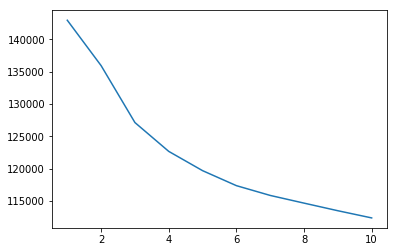

In [112]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(i,init='k-means++')
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)
    print(float(i)/10)
plt.plot(range(1,11),wcss)

## Clustering

In [55]:
kmeans = KMeans(6,init='k-means++')
y_kmeans = kmeans.fit_predict(features)

In [91]:
dict_time = {}

In [92]:
unique,counts = np.unique(y_kmeans,return_counts=True)
dict_time = dict(zip(unique,counts))

In [93]:
dict_time

{0: 291, 1: 296, 2: 371, 3: 15, 4: 427, 5: 343}

## SVM

In [35]:
t_j = 0
j = 0
x_svm = []
y_svm = []
for subdirs,dirs,files in os.walk(data_folder+'dev-clean/Spectrograms'):
    t_j+=1
for subdirs,dirs,files in os.walk(data_folder+'dev-clean/Spectrograms'):
    for file in files:
        if file.endswith('.png'):
            image = cv2.imread(subdirs+'/'+file)
            image = cv2.resize(image,(im_size,im_size))
            image = np.expand_dims(image,axis=0)
            x_svm.append(model2.predict(image))
            y_svm.append(dict_y.get(int(subdirs.split('/')[-1][:-4])))
    j+=1
    print(float(j)/t_j*100)

2.4390243902439024
4.878048780487805
7.317073170731707
9.75609756097561
12.195121951219512
14.634146341463413
17.073170731707318
19.51219512195122
21.951219512195124
24.390243902439025
26.82926829268293
29.268292682926827
31.70731707317073
34.146341463414636
36.58536585365854
39.02439024390244
41.46341463414634
43.90243902439025
46.34146341463415
48.78048780487805
51.21951219512195
53.65853658536586
56.09756097560976
58.536585365853654
60.97560975609756
63.41463414634146
65.85365853658537
68.29268292682927
70.73170731707317
73.17073170731707
75.60975609756098
78.04878048780488
80.48780487804879
82.92682926829268
85.36585365853658
87.8048780487805
90.2439024390244
92.6829268292683
95.1219512195122
97.5609756097561
100.0


In [36]:
import random

In [37]:
x_svm2 = x_svm
y_svm2 = y_svm

In [38]:
x_svm = []
y_svm = []
test_indices = random.sample(range(len(x_svm2)),1000)
for i in test_indices:
    x_svm.append(x_svm2[i])
    y_svm.append(y_svm2[i])

In [39]:
x_svm = np.array(x_svm).reshape(len(x_svm),-1)
y_svm = np.array(y_svm).reshape(len(y_svm),-1)

In [40]:
x_svm.shape

(1000, 65536)

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
x_svm_train,x_svm_test,y_svm_train,y_svm_test = train_test_split(x_svm,y_svm,test_size=0.2)

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
sc =  StandardScaler()
x_svm_train = sc.fit_transform(x_svm_train)
x_svm_test = sc.transform(x_svm_test)

In [45]:
from sklearn.svm import SVC

In [46]:
svm = SVC(kernel='rbf')

In [47]:
svm.fit(x_svm_train,y_svm_train)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [48]:
y_svm_pred = svm.predict(x_svm_test)

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
cm = confusion_matrix(y_svm_test,y_svm_pred)

In [51]:
cm

array([[67, 35],
       [34, 64]])

In [52]:
y_svm_pred = svm.predict(features)

In [76]:
y_svm_pred.shape

(1743,)

In [56]:
print(y_svm_pred,y_kmeans)

[0 0 0 ... 0 0 0] [3 3 3 ... 3 3 3]


In [89]:
dict_gender = {}
for i in range(6):
    for j in range(len(y_kmeans)):
        c1 = 0
        c2 = 0
        if(y_kmeans[j]==i):
            c1 += 1
            c2 += y_svm_pred[i]
        if(c1!=0):
            dict_gender[i] = 1 if(float(c2)/c1>0.5) else 0
            

In [90]:
dict_gender

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}

In [94]:
dict_time

{0: 291, 1: 296, 2: 371, 3: 15, 4: 427, 5: 343}